In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.date, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, self.signal_features.shape[1]) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        
        #股息
        import yfinance as yf
        self.Ticker = yf.Ticker("2330.TW")#抓取股票
        self.Dividends = self.Ticker.actions['Dividends']#抓取股息資料
        self.Dividends_Date = self.Dividends.index.astype('string')#將股息日期->String
        self.Dividends_Date = np.array(self.Dividends_Date)#將股息日期->np.array
        self.Dividends = np.array(self.Dividends) #抓取股息價錢
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-10).tolist()
        long_ticks = (np.array(long_ticks)-10).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")
        plt.savefig('2330_BBands_TotalProfit.jpg')
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [2]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        date = self.df.loc[:, 'index'].to_numpy() #prices：日期
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】
        
        
        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, date, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string

        
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                    
                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = current_price #買入成本 = 今天收盤
                    Sold = last_trade_price #賣出成本 = 明天開盤

                    price_diff = Sold - Buy #盈虧 = 賣出成本 - 買入成本




                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = last_trade_price #買入成本 = 明天開盤
                    Sold = current_price #賣出成本 = 今天收盤

                    price_diff = Sold - Buy #盈虧 = 賣出成本 - 買入成本

        
            step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                
                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = current_price
                    Sold = last_trade_price

                    price_diff = Sold - Buy#最後賺到的錢
                    long_profit_percentage = (Sold - Buy)/Buy
                    self._total_profit += long_profit_percentage

                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = last_trade_price
                    Sold = current_price

                    price_diff = Sold - Buy#最後賺到的錢
                    short_profit_percentage = (Sold - Buy)/Buy 
                    self._total_profit += short_profit_percentage  
                       
                
            step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [3]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\cherr\.conda\envs\Python37TensorFlow20V2\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
if isinstance('AXP', str):
    # load it from yahoo_fin library
    df = si.get_data('AXP')
df = df.dropna()#丟棄空值
df = df.reset_index()
pd.set_option('display.float_format', lambda x: '%.3f' % x)#設定顯示小數點後3位數

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
volume = df['volume']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI

#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#成交量均線
volume10Day_mean=volume.ewm(span=10,adjust=False).mean() #10日移動平均成交量
volume10Day_mean = volume10Day_mean>volume #10日移動平均成交量 > 當日成交量【**技術指標**】
df_volume10day_mean=pd.DataFrame(volume10Day_mean) #變成DataFrame
labelencoder = LabelEncoder() #將True False 變成 1 0
df_volume10day_mean['volume'] = labelencoder.fit_transform(df_volume10day_mean['volume'])#將True False 變成 1 0
ct = ColumnTransformer([("volume", OneHotEncoder(), [0])], remainder = 'passthrough') #將1 0 變成 OneHotEncoder
df_volume10day_mean = ct.fit_transform(df_volume10day_mean)#將1 0 變成 OneHotEncoder
df_volume10day_mean = pd.DataFrame(df_volume10day_mean, columns = ['Volume_lower','Volume_greater'])
df_volume10day_mean['Volume_lower'] = pd.to_numeric(df_volume10day_mean['Volume_lower'], downcast='integer')
df_volume10day_mean['Volume_greater'] = pd.to_numeric(df_volume10day_mean['Volume_greater'], downcast='integer')







#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330 = pd.merge(df2330,df_volume10day_mean,left_index=True,right_index=True) #合併布林通道

df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [5]:
#---------------------------------------------------------------------------
# normalizer = Normalizer()#創建標準化函數
# df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
# df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
# df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
# df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
#                                                       3:'FH',4:'FL',
#                                                       5:'UpLine',6:'DownLine',
#                                                       7:'RSI',
#                                                       8:'K_Value',9:'D_Value',
#                                                       10:'DIF',11:'MACD',
#                                                       12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
# df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
# df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
# df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df = df2330
df

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
0,1972-06-28,3.404,3.404,3.404,3.404,1.170,0,AXP,3.235,3.508,...,44.318,42.671,36.544,-0.072,-0.071,3.661,3.444,3.227,1,0
1,1972-06-29,3.484,3.484,3.484,3.484,1.197,0,AXP,3.235,3.508,...,50.000,58.839,43.976,-0.060,-0.069,3.619,3.433,3.248,1,0
2,1972-06-30,3.589,3.589,3.589,3.589,1.233,0,AXP,3.235,3.589,...,58.491,72.559,53.504,-0.042,-0.064,3.595,3.429,3.263,1,0
3,1972-07-03,3.725,3.725,3.725,3.725,1.280,0,AXP,3.235,3.725,...,66.949,81.706,62.905,-0.016,-0.054,3.632,3.435,3.238,1,0
4,1972-07-05,3.862,3.862,3.862,3.862,1.327,0,AXP,3.235,3.862,...,71.642,87.804,71.204,0.015,-0.040,3.728,3.458,3.187,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12774,2023-02-24,173.690,174.940,172.190,174.250,174.250,1667400,AXP,172.190,182.150,...,33.233,27.196,39.448,4.192,5.588,182.524,176.706,170.889,0,1
12775,2023-02-27,175.530,175.690,173.080,173.300,173.300,1909000,AXP,172.190,182.150,...,29.526,21.845,33.581,3.693,5.209,182.438,176.756,171.074,0,1
12776,2023-02-28,174.010,175.340,173.580,173.990,173.990,2301400,AXP,172.190,180.740,...,31.110,21.581,29.581,3.316,4.830,182.340,176.822,171.305,0,1
12777,2023-03-01,173.510,177.200,173.010,175.910,175.910,2566500,AXP,172.190,179.880,...,39.589,30.512,29.891,3.135,4.491,182.338,176.872,171.405,1,0


# 查找DF的標籤

In [6]:
dfStartDate_Train = df[(df['index']=='2020-01-02')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

11982

In [7]:
dfEndDate_Train = df[(df['index']=='2022-12-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

12737

In [8]:
df[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
11982,2020-01-02,124.660,126.270,124.230,125.850,120.653,2708000,AXP,123.700,126.280,...,56.030,61.247,63.112,1.443,1.399,128.045,123.208,118.370,1,0
11983,2020-01-03,124.320,125.100,123.940,124.600,119.455,2090600,AXP,123.700,126.280,...,54.802,52.459,59.561,1.352,1.390,127.759,123.540,119.322,0,1
11984,2020-01-06,123.370,124.160,123.120,124.060,118.937,2855200,AXP,123.120,126.270,...,44.972,44.920,54.681,1.222,1.356,127.291,123.829,120.368,1,0
11985,2020-01-07,123.470,124.400,123.360,123.410,118.314,2042300,AXP,123.120,126.270,...,45.176,33.015,47.459,1.055,1.296,127.111,123.969,120.828,0,1
11986,2020-01-08,124.050,126.360,123.800,125.540,120.356,3458200,AXP,123.120,126.360,...,53.423,46.907,47.275,1.081,1.253,126.987,124.224,121.460,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12733,2022-12-23,145.230,147.140,144.520,147.020,146.512,1671800,AXP,142.720,161.550,...,32.846,18.910,21.387,-1.383,-0.176,161.368,152.315,143.262,0,1
12734,2022-12-27,147.290,147.860,145.670,146.390,145.884,1858500,AXP,142.720,158.620,...,32.876,20.301,21.025,-1.503,-0.441,161.491,152.091,142.691,0,1
12735,2022-12-28,146.210,146.820,143.940,144.010,143.513,1490200,AXP,142.720,152.280,...,30.004,18.032,20.027,-1.769,-0.707,161.533,151.570,141.608,0,1
12736,2022-12-29,145.080,147.620,144.400,147.320,146.811,1758500,AXP,142.720,148.590,...,29.720,38.143,26.066,-1.693,-0.904,160.782,151.057,141.332,0,1


In [9]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    date = df.loc[:, 'index'].to_numpy()[start:end]#抓取Date
    signal_features = df.loc[:, ['K_Value', 'D_Value']].to_numpy()[start:end]#抓取特徵資料
    return open, close, high, low, volnume, date, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, date,signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._date = date
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._date, self._signal_features

    
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [10]:
policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[64,64,64], pi=[64,64,64])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=5000000)

Wrapping the env in a DummyVecEnv.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | 0.205    |
| fps                | 15       |
| nupdates           | 1        |
| policy_entropy     | 0.645    |
| total_timesteps    | 5        |
| value_loss         | 1.26     |
---------------------------------
---------------------------------
| explained_variance | -0.0168  |
| fps                | 344      |
| nupdates           | 100      |
| policy_entropy     | 0.67     |
| total_timesteps    | 500      |
| value_loss         | 3.51     |
---------------------------------
---------------------------------
| explained_variance | 0.0117 

---------------------------------
| explained_variance | 0.00663  |
| fps                | 216      |
| nupdates           | 1500     |
| policy_entropy     | 0.0706   |
| total_timesteps    | 7500     |
| value_loss         | 4.98     |
---------------------------------
---------------------------------
| explained_variance | 0.00369  |
| fps                | 213      |
| nupdates           | 1600     |
| policy_entropy     | 0.0537   |
| total_timesteps    | 8000     |
| value_loss         | 0.5      |
---------------------------------
---------------------------------
| explained_variance | 0.00162  |
| fps                | 210      |
| nupdates           | 1700     |
| policy_entropy     | 0.0135   |
| total_timesteps    | 8500     |
| value_loss         | 20.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0024   |
| fps                | 206      |
| nupdates           | 1800     |
| policy_entropy     | 0.00583  |
| total_timest

---------------------------------
| explained_variance | -0.00577 |
| fps                | 169      |
| nupdates           | 4500     |
| policy_entropy     | 0.0189   |
| total_timesteps    | 22500    |
| value_loss         | 15.4     |
---------------------------------
---------------------------------
| explained_variance | 0.152    |
| fps                | 168      |
| nupdates           | 4600     |
| policy_entropy     | 0.0637   |
| total_timesteps    | 23000    |
| value_loss         | 0.375    |
---------------------------------
---------------------------------
| explained_variance | -0.00382 |
| fps                | 168      |
| nupdates           | 4700     |
| policy_entropy     | 0.153    |
| total_timesteps    | 23500    |
| value_loss         | 32       |
---------------------------------
---------------------------------
| explained_variance | -0.0106  |
| fps                | 168      |
| nupdates           | 4800     |
| policy_entropy     | 0.0292   |
| total_timest

---------------------------------
| explained_variance | 0.152    |
| fps                | 161      |
| nupdates           | 7600     |
| policy_entropy     | 0.00374  |
| total_timesteps    | 38000    |
| value_loss         | 2.01     |
---------------------------------
---------------------------------
| explained_variance | -0.107   |
| fps                | 160      |
| nupdates           | 7700     |
| policy_entropy     | 0.00362  |
| total_timesteps    | 38500    |
| value_loss         | 5.7      |
---------------------------------
---------------------------------
| explained_variance | -0.22    |
| fps                | 160      |
| nupdates           | 7800     |
| policy_entropy     | 0.00333  |
| total_timesteps    | 39000    |
| value_loss         | 2.64     |
---------------------------------
---------------------------------
| explained_variance | 0.0114   |
| fps                | 160      |
| nupdates           | 7900     |
| policy_entropy     | 0.00252  |
| total_timest

---------------------------------
| explained_variance | 0.058    |
| fps                | 157      |
| nupdates           | 10700    |
| policy_entropy     | 0.00527  |
| total_timesteps    | 53500    |
| value_loss         | 9.74     |
---------------------------------
---------------------------------
| explained_variance | 0.174    |
| fps                | 157      |
| nupdates           | 10800    |
| policy_entropy     | 0.00691  |
| total_timesteps    | 54000    |
| value_loss         | 0.733    |
---------------------------------
---------------------------------
| explained_variance | -0.0196  |
| fps                | 157      |
| nupdates           | 10900    |
| policy_entropy     | 0.00505  |
| total_timesteps    | 54500    |
| value_loss         | 143      |
---------------------------------
---------------------------------
| explained_variance | -0.164   |
| fps                | 157      |
| nupdates           | 11000    |
| policy_entropy     | 0.00426  |
| total_timest

---------------------------------
| explained_variance | -0.32    |
| fps                | 155      |
| nupdates           | 13800    |
| policy_entropy     | 0.075    |
| total_timesteps    | 69000    |
| value_loss         | 0.144    |
---------------------------------
---------------------------------
| explained_variance | 0.117    |
| fps                | 155      |
| nupdates           | 13900    |
| policy_entropy     | 0.245    |
| total_timesteps    | 69500    |
| value_loss         | 37.3     |
---------------------------------
---------------------------------
| explained_variance | 0.00049  |
| fps                | 155      |
| nupdates           | 14000    |
| policy_entropy     | 0.0864   |
| total_timesteps    | 70000    |
| value_loss         | 0.74     |
---------------------------------
---------------------------------
| explained_variance | -0.35    |
| fps                | 155      |
| nupdates           | 14100    |
| policy_entropy     | 0.085    |
| total_timest

---------------------------------
| explained_variance | 0.0589   |
| fps                | 154      |
| nupdates           | 16900    |
| policy_entropy     | 0.0236   |
| total_timesteps    | 84500    |
| value_loss         | 4.03     |
---------------------------------
---------------------------------
| explained_variance | 0.0208   |
| fps                | 154      |
| nupdates           | 17000    |
| policy_entropy     | 0.00761  |
| total_timesteps    | 85000    |
| value_loss         | 5.1      |
---------------------------------
---------------------------------
| explained_variance | 0.0662   |
| fps                | 154      |
| nupdates           | 17100    |
| policy_entropy     | 0.00521  |
| total_timesteps    | 85500    |
| value_loss         | 17.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0149   |
| fps                | 154      |
| nupdates           | 17200    |
| policy_entropy     | 0.00374  |
| total_timest

---------------------------------
| explained_variance | -0.00909 |
| fps                | 154      |
| nupdates           | 20000    |
| policy_entropy     | 0.0112   |
| total_timesteps    | 100000   |
| value_loss         | 32.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0243   |
| fps                | 154      |
| nupdates           | 20100    |
| policy_entropy     | 0.0132   |
| total_timesteps    | 100500   |
| value_loss         | 2.66     |
---------------------------------
---------------------------------
| explained_variance | -0.00495 |
| fps                | 154      |
| nupdates           | 20200    |
| policy_entropy     | 0.0221   |
| total_timesteps    | 101000   |
| value_loss         | 4.23     |
---------------------------------
---------------------------------
| explained_variance | 0.284    |
| fps                | 154      |
| nupdates           | 20300    |
| policy_entropy     | 0.0902   |
| total_timest

---------------------------------
| explained_variance | 0.0125   |
| fps                | 153      |
| nupdates           | 23100    |
| policy_entropy     | 0.0055   |
| total_timesteps    | 115500   |
| value_loss         | 1.17     |
---------------------------------
---------------------------------
| explained_variance | 0.0103   |
| fps                | 153      |
| nupdates           | 23200    |
| policy_entropy     | 0.00543  |
| total_timesteps    | 116000   |
| value_loss         | 5.44     |
---------------------------------
---------------------------------
| explained_variance | 0.0287   |
| fps                | 153      |
| nupdates           | 23300    |
| policy_entropy     | 0.00799  |
| total_timesteps    | 116500   |
| value_loss         | 5.82     |
---------------------------------
---------------------------------
| explained_variance | -0.0623  |
| fps                | 153      |
| nupdates           | 23400    |
| policy_entropy     | 0.0103   |
| total_timest

---------------------------------
| explained_variance | -0.0431  |
| fps                | 153      |
| nupdates           | 26200    |
| policy_entropy     | 0.00342  |
| total_timesteps    | 131000   |
| value_loss         | 2.81     |
---------------------------------
---------------------------------
| explained_variance | -0.00468 |
| fps                | 153      |
| nupdates           | 26300    |
| policy_entropy     | 0.0041   |
| total_timesteps    | 131500   |
| value_loss         | 2.84     |
---------------------------------
---------------------------------
| explained_variance | 0.00579  |
| fps                | 153      |
| nupdates           | 26400    |
| policy_entropy     | 0.00859  |
| total_timesteps    | 132000   |
| value_loss         | 49       |
---------------------------------
---------------------------------
| explained_variance | 0.52     |
| fps                | 153      |
| nupdates           | 26500    |
| policy_entropy     | 0.0485   |
| total_timest

---------------------------------
| explained_variance | -0.14    |
| fps                | 152      |
| nupdates           | 29300    |
| policy_entropy     | 0.0072   |
| total_timesteps    | 146500   |
| value_loss         | 21.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0121   |
| fps                | 152      |
| nupdates           | 29400    |
| policy_entropy     | 0.0698   |
| total_timesteps    | 147000   |
| value_loss         | 0.437    |
---------------------------------
---------------------------------
| explained_variance | 0.0869   |
| fps                | 152      |
| nupdates           | 29500    |
| policy_entropy     | 0.0166   |
| total_timesteps    | 147500   |
| value_loss         | 15.4     |
---------------------------------
---------------------------------
| explained_variance | 0.454    |
| fps                | 152      |
| nupdates           | 29600    |
| policy_entropy     | 0.00721  |
| total_timest

---------------------------------
| explained_variance | -0.027   |
| fps                | 152      |
| nupdates           | 32400    |
| policy_entropy     | 0.00431  |
| total_timesteps    | 162000   |
| value_loss         | 176      |
---------------------------------
---------------------------------
| explained_variance | -0.00808 |
| fps                | 152      |
| nupdates           | 32500    |
| policy_entropy     | 0.0027   |
| total_timesteps    | 162500   |
| value_loss         | 6.81     |
---------------------------------
---------------------------------
| explained_variance | -0.0584  |
| fps                | 152      |
| nupdates           | 32600    |
| policy_entropy     | 0.00305  |
| total_timesteps    | 163000   |
| value_loss         | 10.9     |
---------------------------------
---------------------------------
| explained_variance | -1.59    |
| fps                | 152      |
| nupdates           | 32700    |
| policy_entropy     | 0.00338  |
| total_timest

---------------------------------
| explained_variance | 0.0537   |
| fps                | 152      |
| nupdates           | 35500    |
| policy_entropy     | 0.00498  |
| total_timesteps    | 177500   |
| value_loss         | 2.68     |
---------------------------------
---------------------------------
| explained_variance | -0.102   |
| fps                | 152      |
| nupdates           | 35600    |
| policy_entropy     | 0.00525  |
| total_timesteps    | 178000   |
| value_loss         | 0.329    |
---------------------------------
---------------------------------
| explained_variance | 0.144    |
| fps                | 152      |
| nupdates           | 35700    |
| policy_entropy     | 0.00511  |
| total_timesteps    | 178500   |
| value_loss         | 22.2     |
---------------------------------
---------------------------------
| explained_variance | 0.0827   |
| fps                | 152      |
| nupdates           | 35800    |
| policy_entropy     | 0.00548  |
| total_timest

---------------------------------
| explained_variance | 0.0322   |
| fps                | 151      |
| nupdates           | 38600    |
| policy_entropy     | 0.143    |
| total_timesteps    | 193000   |
| value_loss         | 41.2     |
---------------------------------
---------------------------------
| explained_variance | -0.0121  |
| fps                | 151      |
| nupdates           | 38700    |
| policy_entropy     | 0.0379   |
| total_timesteps    | 193500   |
| value_loss         | 3.43     |
---------------------------------
---------------------------------
| explained_variance | -0.0278  |
| fps                | 151      |
| nupdates           | 38800    |
| policy_entropy     | 0.0418   |
| total_timesteps    | 194000   |
| value_loss         | 1.33     |
---------------------------------
---------------------------------
| explained_variance | -0.00776 |
| fps                | 151      |
| nupdates           | 38900    |
| policy_entropy     | 0.0214   |
| total_timest

---------------------------------
| explained_variance | 0.157    |
| fps                | 151      |
| nupdates           | 41700    |
| policy_entropy     | 0.00243  |
| total_timesteps    | 208500   |
| value_loss         | 4.91     |
---------------------------------
---------------------------------
| explained_variance | 0.112    |
| fps                | 151      |
| nupdates           | 41800    |
| policy_entropy     | 0.00263  |
| total_timesteps    | 209000   |
| value_loss         | 1.12     |
---------------------------------
---------------------------------
| explained_variance | -0.0716  |
| fps                | 151      |
| nupdates           | 41900    |
| policy_entropy     | 0.00271  |
| total_timesteps    | 209500   |
| value_loss         | 9.94     |
---------------------------------
---------------------------------
| explained_variance | 0.0259   |
| fps                | 151      |
| nupdates           | 42000    |
| policy_entropy     | 0.00284  |
| total_timest

---------------------------------
| explained_variance | -0.0337  |
| fps                | 151      |
| nupdates           | 44800    |
| policy_entropy     | 0.00377  |
| total_timesteps    | 224000   |
| value_loss         | 3.84     |
---------------------------------
---------------------------------
| explained_variance | -0.00844 |
| fps                | 151      |
| nupdates           | 44900    |
| policy_entropy     | 0.00218  |
| total_timesteps    | 224500   |
| value_loss         | 34       |
---------------------------------
---------------------------------
| explained_variance | 0.255    |
| fps                | 151      |
| nupdates           | 45000    |
| policy_entropy     | 0.00221  |
| total_timesteps    | 225000   |
| value_loss         | 5.06     |
---------------------------------
---------------------------------
| explained_variance | 0.0908   |
| fps                | 151      |
| nupdates           | 45100    |
| policy_entropy     | 0.00197  |
| total_timest

---------------------------------
| explained_variance | -0.00331 |
| fps                | 151      |
| nupdates           | 47900    |
| policy_entropy     | 0.00348  |
| total_timesteps    | 239500   |
| value_loss         | 2.83     |
---------------------------------
---------------------------------
| explained_variance | -0.00198 |
| fps                | 151      |
| nupdates           | 48000    |
| policy_entropy     | 0.00421  |
| total_timesteps    | 240000   |
| value_loss         | 3.94     |
---------------------------------
---------------------------------
| explained_variance | -0.0413  |
| fps                | 151      |
| nupdates           | 48100    |
| policy_entropy     | 0.00413  |
| total_timesteps    | 240500   |
| value_loss         | 7.27     |
---------------------------------
---------------------------------
| explained_variance | -0.107   |
| fps                | 151      |
| nupdates           | 48200    |
| policy_entropy     | 0.00314  |
| total_timest

---------------------------------
| explained_variance | 0.0674   |
| fps                | 151      |
| nupdates           | 51000    |
| policy_entropy     | 0.00346  |
| total_timesteps    | 255000   |
| value_loss         | 4.63     |
---------------------------------
---------------------------------
| explained_variance | -0.121   |
| fps                | 151      |
| nupdates           | 51100    |
| policy_entropy     | 0.00491  |
| total_timesteps    | 255500   |
| value_loss         | 1.79     |
---------------------------------
---------------------------------
| explained_variance | 0.377    |
| fps                | 151      |
| nupdates           | 51200    |
| policy_entropy     | 0.00253  |
| total_timesteps    | 256000   |
| value_loss         | 0.303    |
---------------------------------
---------------------------------
| explained_variance | 0.0454   |
| fps                | 151      |
| nupdates           | 51300    |
| policy_entropy     | 0.00246  |
| total_timest

---------------------------------
| explained_variance | 0.475    |
| fps                | 151      |
| nupdates           | 54100    |
| policy_entropy     | 0.00493  |
| total_timesteps    | 270500   |
| value_loss         | 1.54     |
---------------------------------
---------------------------------
| explained_variance | -0.0285  |
| fps                | 151      |
| nupdates           | 54200    |
| policy_entropy     | 0.00355  |
| total_timesteps    | 271000   |
| value_loss         | 2.24     |
---------------------------------
---------------------------------
| explained_variance | 0.143    |
| fps                | 151      |
| nupdates           | 54300    |
| policy_entropy     | 0.00678  |
| total_timesteps    | 271500   |
| value_loss         | 10.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0932   |
| fps                | 151      |
| nupdates           | 54400    |
| policy_entropy     | 0.00674  |
| total_timest

---------------------------------
| explained_variance | -0.294   |
| fps                | 151      |
| nupdates           | 57200    |
| policy_entropy     | 0.0115   |
| total_timesteps    | 286000   |
| value_loss         | 0.688    |
---------------------------------
---------------------------------
| explained_variance | 0.0241   |
| fps                | 151      |
| nupdates           | 57300    |
| policy_entropy     | 0.00876  |
| total_timesteps    | 286500   |
| value_loss         | 5.23     |
---------------------------------
---------------------------------
| explained_variance | 0.461    |
| fps                | 151      |
| nupdates           | 57400    |
| policy_entropy     | 0.0102   |
| total_timesteps    | 287000   |
| value_loss         | 2.46     |
---------------------------------
---------------------------------
| explained_variance | 0.0611   |
| fps                | 151      |
| nupdates           | 57500    |
| policy_entropy     | 0.03     |
| total_timest

---------------------------------
| explained_variance | 0.146    |
| fps                | 151      |
| nupdates           | 60300    |
| policy_entropy     | 0.00698  |
| total_timesteps    | 301500   |
| value_loss         | 2.11     |
---------------------------------
---------------------------------
| explained_variance | -0.0313  |
| fps                | 151      |
| nupdates           | 60400    |
| policy_entropy     | 0.0049   |
| total_timesteps    | 302000   |
| value_loss         | 12.4     |
---------------------------------
---------------------------------
| explained_variance | 0.191    |
| fps                | 151      |
| nupdates           | 60500    |
| policy_entropy     | 0.00811  |
| total_timesteps    | 302500   |
| value_loss         | 74.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0336   |
| fps                | 151      |
| nupdates           | 60600    |
| policy_entropy     | 0.00616  |
| total_timest

---------------------------------
| explained_variance | 0.0207   |
| fps                | 150      |
| nupdates           | 63400    |
| policy_entropy     | 0.00283  |
| total_timesteps    | 317000   |
| value_loss         | 2.74     |
---------------------------------
---------------------------------
| explained_variance | -0.00673 |
| fps                | 150      |
| nupdates           | 63500    |
| policy_entropy     | 0.00302  |
| total_timesteps    | 317500   |
| value_loss         | 10.8     |
---------------------------------
---------------------------------
| explained_variance | 0.32     |
| fps                | 150      |
| nupdates           | 63600    |
| policy_entropy     | 0.00404  |
| total_timesteps    | 318000   |
| value_loss         | 71.3     |
---------------------------------
---------------------------------
| explained_variance | -0.0215  |
| fps                | 150      |
| nupdates           | 63700    |
| policy_entropy     | 0.00528  |
| total_timest

---------------------------------
| explained_variance | 0.0786   |
| fps                | 150      |
| nupdates           | 66500    |
| policy_entropy     | 0.00117  |
| total_timesteps    | 332500   |
| value_loss         | 85.1     |
---------------------------------
---------------------------------
| explained_variance | 0.00817  |
| fps                | 150      |
| nupdates           | 66600    |
| policy_entropy     | 0.0016   |
| total_timesteps    | 333000   |
| value_loss         | 0.534    |
---------------------------------
---------------------------------
| explained_variance | 0.305    |
| fps                | 150      |
| nupdates           | 66700    |
| policy_entropy     | 0.00245  |
| total_timesteps    | 333500   |
| value_loss         | 11.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0814   |
| fps                | 150      |
| nupdates           | 66800    |
| policy_entropy     | 0.00113  |
| total_timest

---------------------------------
| explained_variance | 0.0184   |
| fps                | 150      |
| nupdates           | 69600    |
| policy_entropy     | 0.00594  |
| total_timesteps    | 348000   |
| value_loss         | 4        |
---------------------------------
----------------------------------
| explained_variance | -0.000916 |
| fps                | 150       |
| nupdates           | 69700     |
| policy_entropy     | 0.00256   |
| total_timesteps    | 348500    |
| value_loss         | 2.41      |
----------------------------------
---------------------------------
| explained_variance | -0.0369  |
| fps                | 150      |
| nupdates           | 69800    |
| policy_entropy     | 0.00221  |
| total_timesteps    | 349000   |
| value_loss         | 10.7     |
---------------------------------
---------------------------------
| explained_variance | -0.0556  |
| fps                | 150      |
| nupdates           | 69900    |
| policy_entropy     | 0.00264  |
| tota

---------------------------------
| explained_variance | -0.00507 |
| fps                | 150      |
| nupdates           | 72700    |
| policy_entropy     | 0.00246  |
| total_timesteps    | 363500   |
| value_loss         | 18.8     |
---------------------------------
---------------------------------
| explained_variance | -0.0036  |
| fps                | 150      |
| nupdates           | 72800    |
| policy_entropy     | 0.0027   |
| total_timesteps    | 364000   |
| value_loss         | 0.756    |
---------------------------------
---------------------------------
| explained_variance | -0.0465  |
| fps                | 150      |
| nupdates           | 72900    |
| policy_entropy     | 0.00453  |
| total_timesteps    | 364500   |
| value_loss         | 83.2     |
---------------------------------
---------------------------------
| explained_variance | 0.606    |
| fps                | 150      |
| nupdates           | 73000    |
| policy_entropy     | 0.0026   |
| total_timest

---------------------------------
| explained_variance | 0.0232   |
| fps                | 150      |
| nupdates           | 75800    |
| policy_entropy     | 0.00528  |
| total_timesteps    | 379000   |
| value_loss         | 1.39     |
---------------------------------
---------------------------------
| explained_variance | -0.0148  |
| fps                | 150      |
| nupdates           | 75900    |
| policy_entropy     | 0.00455  |
| total_timesteps    | 379500   |
| value_loss         | 8.19     |
---------------------------------
---------------------------------
| explained_variance | 0.225    |
| fps                | 150      |
| nupdates           | 76000    |
| policy_entropy     | 0.00475  |
| total_timesteps    | 380000   |
| value_loss         | 40.6     |
---------------------------------
---------------------------------
| explained_variance | -0.163   |
| fps                | 150      |
| nupdates           | 76100    |
| policy_entropy     | 0.00336  |
| total_timest

---------------------------------
| explained_variance | 0.15     |
| fps                | 150      |
| nupdates           | 78900    |
| policy_entropy     | 0.0153   |
| total_timesteps    | 394500   |
| value_loss         | 2.33     |
---------------------------------
---------------------------------
| explained_variance | -0.0695  |
| fps                | 150      |
| nupdates           | 79000    |
| policy_entropy     | 0.00514  |
| total_timesteps    | 395000   |
| value_loss         | 0.218    |
---------------------------------
----------------------------------
| explained_variance | -0.000214 |
| fps                | 150       |
| nupdates           | 79100     |
| policy_entropy     | 0.00565   |
| total_timesteps    | 395500    |
| value_loss         | 13.1      |
----------------------------------
---------------------------------
| explained_variance | 0.293    |
| fps                | 150      |
| nupdates           | 79200    |
| policy_entropy     | 0.0142   |
| tota

---------------------------------
| explained_variance | -0.00515 |
| fps                | 150      |
| nupdates           | 82000    |
| policy_entropy     | 0.00596  |
| total_timesteps    | 410000   |
| value_loss         | 1.17     |
---------------------------------
---------------------------------
| explained_variance | -0.0824  |
| fps                | 150      |
| nupdates           | 82100    |
| policy_entropy     | 0.00559  |
| total_timesteps    | 410500   |
| value_loss         | 5.51     |
---------------------------------
---------------------------------
| explained_variance | -0.366   |
| fps                | 150      |
| nupdates           | 82200    |
| policy_entropy     | 0.00873  |
| total_timesteps    | 411000   |
| value_loss         | 2.84     |
---------------------------------
---------------------------------
| explained_variance | -0.00166 |
| fps                | 150      |
| nupdates           | 82300    |
| policy_entropy     | 0.00621  |
| total_timest

---------------------------------
| explained_variance | -0.602   |
| fps                | 150      |
| nupdates           | 85100    |
| policy_entropy     | 0.017    |
| total_timesteps    | 425500   |
| value_loss         | 3.66     |
---------------------------------
---------------------------------
| explained_variance | 0.0205   |
| fps                | 150      |
| nupdates           | 85200    |
| policy_entropy     | 0.01     |
| total_timesteps    | 426000   |
| value_loss         | 1.06     |
---------------------------------
---------------------------------
| explained_variance | 0.0141   |
| fps                | 150      |
| nupdates           | 85300    |
| policy_entropy     | 0.0131   |
| total_timesteps    | 426500   |
| value_loss         | 9.43     |
---------------------------------
---------------------------------
| explained_variance | 0.143    |
| fps                | 150      |
| nupdates           | 85400    |
| policy_entropy     | 0.0481   |
| total_timest

---------------------------------
| explained_variance | 0.0971   |
| fps                | 150      |
| nupdates           | 88200    |
| policy_entropy     | 0.0723   |
| total_timesteps    | 441000   |
| value_loss         | 1.86     |
---------------------------------
---------------------------------
| explained_variance | -0.198   |
| fps                | 150      |
| nupdates           | 88300    |
| policy_entropy     | 0.0762   |
| total_timesteps    | 441500   |
| value_loss         | 0.675    |
---------------------------------
---------------------------------
| explained_variance | 0.0354   |
| fps                | 150      |
| nupdates           | 88400    |
| policy_entropy     | 0.143    |
| total_timesteps    | 442000   |
| value_loss         | 16.5     |
---------------------------------
---------------------------------
| explained_variance | 0.00698  |
| fps                | 150      |
| nupdates           | 88500    |
| policy_entropy     | 0.0562   |
| total_timest

---------------------------------
| explained_variance | 0.0376   |
| fps                | 150      |
| nupdates           | 91300    |
| policy_entropy     | 0.00915  |
| total_timesteps    | 456500   |
| value_loss         | 9.69     |
---------------------------------
---------------------------------
| explained_variance | -0.00672 |
| fps                | 150      |
| nupdates           | 91400    |
| policy_entropy     | 0.00823  |
| total_timesteps    | 457000   |
| value_loss         | 0.397    |
---------------------------------
---------------------------------
| explained_variance | -0.0553  |
| fps                | 150      |
| nupdates           | 91500    |
| policy_entropy     | 0.00784  |
| total_timesteps    | 457500   |
| value_loss         | 12.1     |
---------------------------------
---------------------------------
| explained_variance | -0.0204  |
| fps                | 150      |
| nupdates           | 91600    |
| policy_entropy     | 0.00945  |
| total_timest

---------------------------------
| explained_variance | -0.0411  |
| fps                | 150      |
| nupdates           | 94400    |
| policy_entropy     | 0.00219  |
| total_timesteps    | 472000   |
| value_loss         | 8        |
---------------------------------
---------------------------------
| explained_variance | -1.1     |
| fps                | 150      |
| nupdates           | 94500    |
| policy_entropy     | 0.00513  |
| total_timesteps    | 472500   |
| value_loss         | 214      |
---------------------------------
---------------------------------
| explained_variance | 0.43     |
| fps                | 150      |
| nupdates           | 94600    |
| policy_entropy     | 0.00268  |
| total_timesteps    | 473000   |
| value_loss         | 1.92     |
---------------------------------
---------------------------------
| explained_variance | -0.0354  |
| fps                | 150      |
| nupdates           | 94700    |
| policy_entropy     | 0.00308  |
| total_timest

---------------------------------
| explained_variance | -0.0499  |
| fps                | 150      |
| nupdates           | 97500    |
| policy_entropy     | 0.00138  |
| total_timesteps    | 487500   |
| value_loss         | 29.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0118   |
| fps                | 150      |
| nupdates           | 97600    |
| policy_entropy     | 0.00242  |
| total_timesteps    | 488000   |
| value_loss         | 13.8     |
---------------------------------
---------------------------------
| explained_variance | -0.0944  |
| fps                | 150      |
| nupdates           | 97700    |
| policy_entropy     | 0.0027   |
| total_timesteps    | 488500   |
| value_loss         | 7.79     |
---------------------------------
---------------------------------
| explained_variance | 0.262    |
| fps                | 150      |
| nupdates           | 97800    |
| policy_entropy     | 0.00418  |
| total_timest

---------------------------------
| explained_variance | -0.00723 |
| fps                | 150      |
| nupdates           | 100600   |
| policy_entropy     | 0.00334  |
| total_timesteps    | 503000   |
| value_loss         | 0.334    |
---------------------------------
---------------------------------
| explained_variance | 0.0456   |
| fps                | 150      |
| nupdates           | 100700   |
| policy_entropy     | 0.00466  |
| total_timesteps    | 503500   |
| value_loss         | 43.6     |
---------------------------------
---------------------------------
| explained_variance | 0.049    |
| fps                | 150      |
| nupdates           | 100800   |
| policy_entropy     | 0.00233  |
| total_timesteps    | 504000   |
| value_loss         | 0.132    |
---------------------------------
---------------------------------
| explained_variance | -0.00683 |
| fps                | 150      |
| nupdates           | 100900   |
| policy_entropy     | 0.00227  |
| total_timest

---------------------------------
| explained_variance | 0.00131  |
| fps                | 150      |
| nupdates           | 103700   |
| policy_entropy     | 0.0207   |
| total_timesteps    | 518500   |
| value_loss         | 13.5     |
---------------------------------
---------------------------------
| explained_variance | 0.00253  |
| fps                | 150      |
| nupdates           | 103800   |
| policy_entropy     | 0.00661  |
| total_timesteps    | 519000   |
| value_loss         | 6.28     |
---------------------------------
---------------------------------
| explained_variance | 0.231    |
| fps                | 150      |
| nupdates           | 103900   |
| policy_entropy     | 0.00331  |
| total_timesteps    | 519500   |
| value_loss         | 3.8      |
---------------------------------
---------------------------------
| explained_variance | -0.678   |
| fps                | 150      |
| nupdates           | 104000   |
| policy_entropy     | 0.00628  |
| total_timest

----------------------------------
| explained_variance | -0.000521 |
| fps                | 150       |
| nupdates           | 106800    |
| policy_entropy     | 0.0109    |
| total_timesteps    | 534000    |
| value_loss         | 4.85      |
----------------------------------
---------------------------------
| explained_variance | -0.48    |
| fps                | 150      |
| nupdates           | 106900   |
| policy_entropy     | 0.0365   |
| total_timesteps    | 534500   |
| value_loss         | 0.431    |
---------------------------------
---------------------------------
| explained_variance | -0.0208  |
| fps                | 150      |
| nupdates           | 107000   |
| policy_entropy     | 0.00248  |
| total_timesteps    | 535000   |
| value_loss         | 6.93     |
---------------------------------
---------------------------------
| explained_variance | 0.891    |
| fps                | 150      |
| nupdates           | 107100   |
| policy_entropy     | 0.0158   |
| tota

---------------------------------
| explained_variance | 0.00872  |
| fps                | 150      |
| nupdates           | 109900   |
| policy_entropy     | 0.0028   |
| total_timesteps    | 549500   |
| value_loss         | 63.8     |
---------------------------------
---------------------------------
| explained_variance | 0.00232  |
| fps                | 150      |
| nupdates           | 110000   |
| policy_entropy     | 0.0017   |
| total_timesteps    | 550000   |
| value_loss         | 23.2     |
---------------------------------
---------------------------------
| explained_variance | 0.371    |
| fps                | 150      |
| nupdates           | 110100   |
| policy_entropy     | 0.00183  |
| total_timesteps    | 550500   |
| value_loss         | 1.27     |
---------------------------------
---------------------------------
| explained_variance | 0.0129   |
| fps                | 150      |
| nupdates           | 110200   |
| policy_entropy     | 0.00223  |
| total_timest

---------------------------------
| explained_variance | 0.0262   |
| fps                | 150      |
| nupdates           | 113000   |
| policy_entropy     | 0.002    |
| total_timesteps    | 565000   |
| value_loss         | 31.1     |
---------------------------------
---------------------------------
| explained_variance | -0.472   |
| fps                | 150      |
| nupdates           | 113100   |
| policy_entropy     | 0.00223  |
| total_timesteps    | 565500   |
| value_loss         | 0.301    |
---------------------------------
---------------------------------
| explained_variance | 0.0244   |
| fps                | 150      |
| nupdates           | 113200   |
| policy_entropy     | 0.00199  |
| total_timesteps    | 566000   |
| value_loss         | 4.88     |
---------------------------------
---------------------------------
| explained_variance | 0.0523   |
| fps                | 150      |
| nupdates           | 113300   |
| policy_entropy     | 0.00448  |
| total_timest

---------------------------------
| explained_variance | 0.429    |
| fps                | 150      |
| nupdates           | 116100   |
| policy_entropy     | 0.133    |
| total_timesteps    | 580500   |
| value_loss         | 0.568    |
---------------------------------
---------------------------------
| explained_variance | 0.113    |
| fps                | 150      |
| nupdates           | 116200   |
| policy_entropy     | 0.176    |
| total_timesteps    | 581000   |
| value_loss         | 27.7     |
---------------------------------
---------------------------------
| explained_variance | -0.359   |
| fps                | 150      |
| nupdates           | 116300   |
| policy_entropy     | 0.388    |
| total_timesteps    | 581500   |
| value_loss         | 8.42     |
---------------------------------
---------------------------------
| explained_variance | 0.0457   |
| fps                | 150      |
| nupdates           | 116400   |
| policy_entropy     | 0.198    |
| total_timest

---------------------------------
| explained_variance | -0.0031  |
| fps                | 150      |
| nupdates           | 119200   |
| policy_entropy     | 0.00614  |
| total_timesteps    | 596000   |
| value_loss         | 2.5      |
---------------------------------
---------------------------------
| explained_variance | -0.00228 |
| fps                | 150      |
| nupdates           | 119300   |
| policy_entropy     | 0.00798  |
| total_timesteps    | 596500   |
| value_loss         | 3.71     |
---------------------------------
---------------------------------
| explained_variance | 0.00599  |
| fps                | 150      |
| nupdates           | 119400   |
| policy_entropy     | 0.0174   |
| total_timesteps    | 597000   |
| value_loss         | 12       |
---------------------------------
---------------------------------
| explained_variance | -0.0685  |
| fps                | 150      |
| nupdates           | 119500   |
| policy_entropy     | 0.0813   |
| total_timest

---------------------------------
| explained_variance | -0.00765 |
| fps                | 150      |
| nupdates           | 122300   |
| policy_entropy     | 0.00275  |
| total_timesteps    | 611500   |
| value_loss         | 1.79     |
---------------------------------
---------------------------------
| explained_variance | 3.47e-05 |
| fps                | 150      |
| nupdates           | 122400   |
| policy_entropy     | 0.0101   |
| total_timesteps    | 612000   |
| value_loss         | 4.65     |
---------------------------------
---------------------------------
| explained_variance | 0.000804 |
| fps                | 150      |
| nupdates           | 122500   |
| policy_entropy     | 0.171    |
| total_timesteps    | 612500   |
| value_loss         | 0.465    |
---------------------------------
---------------------------------
| explained_variance | 0.000391 |
| fps                | 150      |
| nupdates           | 122600   |
| policy_entropy     | 0.00251  |
| total_timest

---------------------------------
| explained_variance | -0.182   |
| fps                | 150      |
| nupdates           | 125400   |
| policy_entropy     | 0.00164  |
| total_timesteps    | 627000   |
| value_loss         | 4.57     |
---------------------------------
---------------------------------
| explained_variance | 0.000993 |
| fps                | 150      |
| nupdates           | 125500   |
| policy_entropy     | 0.643    |
| total_timesteps    | 627500   |
| value_loss         | 5.58     |
---------------------------------
---------------------------------
| explained_variance | 0.0395   |
| fps                | 150      |
| nupdates           | 125600   |
| policy_entropy     | 0.00655  |
| total_timesteps    | 628000   |
| value_loss         | 17.2     |
---------------------------------
---------------------------------
| explained_variance | 2.19e-05 |
| fps                | 150      |
| nupdates           | 125700   |
| policy_entropy     | 0.00953  |
| total_timest

---------------------------------
| explained_variance | 0.0364   |
| fps                | 150      |
| nupdates           | 128500   |
| policy_entropy     | 0.00204  |
| total_timesteps    | 642500   |
| value_loss         | 12.6     |
---------------------------------
---------------------------------
| explained_variance | -0.368   |
| fps                | 150      |
| nupdates           | 128600   |
| policy_entropy     | 0.00773  |
| total_timesteps    | 643000   |
| value_loss         | 0.785    |
---------------------------------
---------------------------------
| explained_variance | -0.118   |
| fps                | 150      |
| nupdates           | 128700   |
| policy_entropy     | 0.121    |
| total_timesteps    | 643500   |
| value_loss         | 2.11     |
---------------------------------
---------------------------------
| explained_variance | 0.0358   |
| fps                | 150      |
| nupdates           | 128800   |
| policy_entropy     | 0.14     |
| total_timest

---------------------------------
| explained_variance | -0.00359 |
| fps                | 150      |
| nupdates           | 131600   |
| policy_entropy     | 0.0366   |
| total_timesteps    | 658000   |
| value_loss         | 2.09     |
---------------------------------
---------------------------------
| explained_variance | 0.0211   |
| fps                | 150      |
| nupdates           | 131700   |
| policy_entropy     | 0.0311   |
| total_timesteps    | 658500   |
| value_loss         | 10.5     |
---------------------------------
---------------------------------
| explained_variance | 0.0438   |
| fps                | 150      |
| nupdates           | 131800   |
| policy_entropy     | 0.0446   |
| total_timesteps    | 659000   |
| value_loss         | 25.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0541   |
| fps                | 150      |
| nupdates           | 131900   |
| policy_entropy     | 0.0294   |
| total_timest

---------------------------------
| explained_variance | -0.015   |
| fps                | 150      |
| nupdates           | 134700   |
| policy_entropy     | 0.0889   |
| total_timesteps    | 673500   |
| value_loss         | 4.22     |
---------------------------------
---------------------------------
| explained_variance | -0.271   |
| fps                | 150      |
| nupdates           | 134800   |
| policy_entropy     | 0.0298   |
| total_timesteps    | 674000   |
| value_loss         | 0.843    |
---------------------------------
---------------------------------
| explained_variance | -0.173   |
| fps                | 150      |
| nupdates           | 134900   |
| policy_entropy     | 0.322    |
| total_timesteps    | 674500   |
| value_loss         | 4.03     |
---------------------------------
---------------------------------
| explained_variance | -0.69    |
| fps                | 150      |
| nupdates           | 135000   |
| policy_entropy     | 0.33     |
| total_timest

---------------------------------
| explained_variance | -0.00825 |
| fps                | 150      |
| nupdates           | 137800   |
| policy_entropy     | 0.00603  |
| total_timesteps    | 689000   |
| value_loss         | 7.63     |
---------------------------------
---------------------------------
| explained_variance | -0.0946  |
| fps                | 150      |
| nupdates           | 137900   |
| policy_entropy     | 0.00784  |
| total_timesteps    | 689500   |
| value_loss         | 0.561    |
---------------------------------
---------------------------------
| explained_variance | 5.5e-05  |
| fps                | 150      |
| nupdates           | 138000   |
| policy_entropy     | 0.00806  |
| total_timesteps    | 690000   |
| value_loss         | 0.832    |
---------------------------------
---------------------------------
| explained_variance | 0.0217   |
| fps                | 150      |
| nupdates           | 138100   |
| policy_entropy     | 0.00758  |
| total_timest

---------------------------------
| explained_variance | 0.0467   |
| fps                | 150      |
| nupdates           | 140900   |
| policy_entropy     | 0.133    |
| total_timesteps    | 704500   |
| value_loss         | 30.9     |
---------------------------------
---------------------------------
| explained_variance | 0.0261   |
| fps                | 150      |
| nupdates           | 141000   |
| policy_entropy     | 0.0168   |
| total_timesteps    | 705000   |
| value_loss         | 6.68     |
---------------------------------
---------------------------------
| explained_variance | 0.0318   |
| fps                | 150      |
| nupdates           | 141100   |
| policy_entropy     | 0.0213   |
| total_timesteps    | 705500   |
| value_loss         | 0.497    |
---------------------------------
---------------------------------
| explained_variance | 0.00604  |
| fps                | 150      |
| nupdates           | 141200   |
| policy_entropy     | 0.013    |
| total_timest

---------------------------------
| explained_variance | -0.804   |
| fps                | 150      |
| nupdates           | 144000   |
| policy_entropy     | 0.0833   |
| total_timesteps    | 720000   |
| value_loss         | 1.33     |
---------------------------------
---------------------------------
| explained_variance | -0.0247  |
| fps                | 150      |
| nupdates           | 144100   |
| policy_entropy     | 0.00761  |
| total_timesteps    | 720500   |
| value_loss         | 0.0752   |
---------------------------------
---------------------------------
| explained_variance | -0.31    |
| fps                | 150      |
| nupdates           | 144200   |
| policy_entropy     | 0.322    |
| total_timesteps    | 721000   |
| value_loss         | 0.181    |
---------------------------------
---------------------------------
| explained_variance | 0.178    |
| fps                | 150      |
| nupdates           | 144300   |
| policy_entropy     | 0.0869   |
| total_timest

---------------------------------
| explained_variance | 0.0165   |
| fps                | 150      |
| nupdates           | 147100   |
| policy_entropy     | 0.00299  |
| total_timesteps    | 735500   |
| value_loss         | 2.17     |
---------------------------------
---------------------------------
| explained_variance | -0.0317  |
| fps                | 150      |
| nupdates           | 147200   |
| policy_entropy     | 0.0036   |
| total_timesteps    | 736000   |
| value_loss         | 14.2     |
---------------------------------
---------------------------------
| explained_variance | -0.0901  |
| fps                | 150      |
| nupdates           | 147300   |
| policy_entropy     | 0.034    |
| total_timesteps    | 736500   |
| value_loss         | 2.33     |
---------------------------------
---------------------------------
| explained_variance | -0.0109  |
| fps                | 150      |
| nupdates           | 147400   |
| policy_entropy     | 0.0139   |
| total_timest

---------------------------------
| explained_variance | -0.00558 |
| fps                | 150      |
| nupdates           | 150200   |
| policy_entropy     | 0.00546  |
| total_timesteps    | 751000   |
| value_loss         | 4.15     |
---------------------------------
---------------------------------
| explained_variance | 0.007    |
| fps                | 150      |
| nupdates           | 150300   |
| policy_entropy     | 0.0154   |
| total_timesteps    | 751500   |
| value_loss         | 37.5     |
---------------------------------
---------------------------------
| explained_variance | -0.0023  |
| fps                | 150      |
| nupdates           | 150400   |
| policy_entropy     | 0.0127   |
| total_timesteps    | 752000   |
| value_loss         | 1.73     |
---------------------------------
---------------------------------
| explained_variance | -0.0525  |
| fps                | 150      |
| nupdates           | 150500   |
| policy_entropy     | 0.00467  |
| total_timest

---------------------------------
| explained_variance | -0.275   |
| fps                | 150      |
| nupdates           | 153300   |
| policy_entropy     | 0.0216   |
| total_timesteps    | 766500   |
| value_loss         | 2.56     |
---------------------------------
---------------------------------
| explained_variance | 0.0123   |
| fps                | 150      |
| nupdates           | 153400   |
| policy_entropy     | 0.53     |
| total_timesteps    | 767000   |
| value_loss         | 1.05     |
---------------------------------
---------------------------------
| explained_variance | -0.0352  |
| fps                | 150      |
| nupdates           | 153500   |
| policy_entropy     | 0.596    |
| total_timesteps    | 767500   |
| value_loss         | 1.12     |
---------------------------------
---------------------------------
| explained_variance | 0.0048   |
| fps                | 150      |
| nupdates           | 153600   |
| policy_entropy     | 0.0923   |
| total_timest

---------------------------------
| explained_variance | -0.0003  |
| fps                | 150      |
| nupdates           | 156400   |
| policy_entropy     | 0.00559  |
| total_timesteps    | 782000   |
| value_loss         | 1.27     |
---------------------------------
---------------------------------
| explained_variance | 0.0571   |
| fps                | 150      |
| nupdates           | 156500   |
| policy_entropy     | 0.00876  |
| total_timesteps    | 782500   |
| value_loss         | 21.1     |
---------------------------------
---------------------------------
| explained_variance | 0.00151  |
| fps                | 150      |
| nupdates           | 156600   |
| policy_entropy     | 0.00572  |
| total_timesteps    | 783000   |
| value_loss         | 3.78     |
---------------------------------
---------------------------------
| explained_variance | -0.182   |
| fps                | 150      |
| nupdates           | 156700   |
| policy_entropy     | 0.0691   |
| total_timest

---------------------------------
| explained_variance | -1.26    |
| fps                | 150      |
| nupdates           | 159500   |
| policy_entropy     | 0.0158   |
| total_timesteps    | 797500   |
| value_loss         | 7.9      |
---------------------------------
---------------------------------
| explained_variance | 0.0409   |
| fps                | 150      |
| nupdates           | 159600   |
| policy_entropy     | 0.303    |
| total_timesteps    | 798000   |
| value_loss         | 1.13     |
---------------------------------
---------------------------------
| explained_variance | -0.218   |
| fps                | 150      |
| nupdates           | 159700   |
| policy_entropy     | 0.196    |
| total_timesteps    | 798500   |
| value_loss         | 0.575    |
---------------------------------
---------------------------------
| explained_variance | -0.00138 |
| fps                | 150      |
| nupdates           | 159800   |
| policy_entropy     | 0.0439   |
| total_timest

---------------------------------
| explained_variance | -0.00611 |
| fps                | 150      |
| nupdates           | 162600   |
| policy_entropy     | 0.606    |
| total_timesteps    | 813000   |
| value_loss         | 2.59     |
---------------------------------
---------------------------------
| explained_variance | 0.0549   |
| fps                | 150      |
| nupdates           | 162700   |
| policy_entropy     | 0.0744   |
| total_timesteps    | 813500   |
| value_loss         | 53.2     |
---------------------------------
---------------------------------
| explained_variance | 0.027    |
| fps                | 150      |
| nupdates           | 162800   |
| policy_entropy     | 0.0077   |
| total_timesteps    | 814000   |
| value_loss         | 52.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0885   |
| fps                | 150      |
| nupdates           | 162900   |
| policy_entropy     | 0.0197   |
| total_timest

---------------------------------
| explained_variance | 0.0701   |
| fps                | 150      |
| nupdates           | 165700   |
| policy_entropy     | 0.0119   |
| total_timesteps    | 828500   |
| value_loss         | 8.84     |
---------------------------------
---------------------------------
| explained_variance | -0.411   |
| fps                | 150      |
| nupdates           | 165800   |
| policy_entropy     | 0.219    |
| total_timesteps    | 829000   |
| value_loss         | 0.613    |
---------------------------------
---------------------------------
| explained_variance | -0.305   |
| fps                | 150      |
| nupdates           | 165900   |
| policy_entropy     | 0.00642  |
| total_timesteps    | 829500   |
| value_loss         | 0.164    |
---------------------------------
---------------------------------
| explained_variance | -0.0849  |
| fps                | 150      |
| nupdates           | 166000   |
| policy_entropy     | 0.00632  |
| total_timest

---------------------------------
| explained_variance | 0.000687 |
| fps                | 150      |
| nupdates           | 168800   |
| policy_entropy     | 0.00141  |
| total_timesteps    | 844000   |
| value_loss         | 1.26     |
---------------------------------
---------------------------------
| explained_variance | 0.0325   |
| fps                | 150      |
| nupdates           | 168900   |
| policy_entropy     | 0.00346  |
| total_timesteps    | 844500   |
| value_loss         | 169      |
---------------------------------
---------------------------------
| explained_variance | 0.0998   |
| fps                | 150      |
| nupdates           | 169000   |
| policy_entropy     | 0.00143  |
| total_timesteps    | 845000   |
| value_loss         | 1.55     |
---------------------------------
---------------------------------
| explained_variance | -0.0754  |
| fps                | 150      |
| nupdates           | 169100   |
| policy_entropy     | 0.0014   |
| total_timest

---------------------------------
| explained_variance | 0.0348   |
| fps                | 150      |
| nupdates           | 171900   |
| policy_entropy     | 0.533    |
| total_timesteps    | 859500   |
| value_loss         | 1.71     |
---------------------------------
---------------------------------
| explained_variance | 0.0332   |
| fps                | 150      |
| nupdates           | 172000   |
| policy_entropy     | 0.0119   |
| total_timesteps    | 860000   |
| value_loss         | 8.88     |
---------------------------------
---------------------------------
| explained_variance | -0.189   |
| fps                | 150      |
| nupdates           | 172100   |
| policy_entropy     | 0.148    |
| total_timesteps    | 860500   |
| value_loss         | 1.77     |
---------------------------------
---------------------------------
| explained_variance | -0.101   |
| fps                | 150      |
| nupdates           | 172200   |
| policy_entropy     | 0.00634  |
| total_timest

---------------------------------
| explained_variance | 0.238    |
| fps                | 150      |
| nupdates           | 175000   |
| policy_entropy     | 0.00331  |
| total_timesteps    | 875000   |
| value_loss         | 1.63     |
---------------------------------
---------------------------------
| explained_variance | 0.022    |
| fps                | 150      |
| nupdates           | 175100   |
| policy_entropy     | 0.141    |
| total_timesteps    | 875500   |
| value_loss         | 271      |
---------------------------------
---------------------------------
| explained_variance | 0.446    |
| fps                | 150      |
| nupdates           | 175200   |
| policy_entropy     | 0.00887  |
| total_timesteps    | 876000   |
| value_loss         | 15.1     |
---------------------------------
----------------------------------
| explained_variance | -0.000463 |
| fps                | 150       |
| nupdates           | 175300    |
| policy_entropy     | 0.0147    |
| total_t

---------------------------------
| explained_variance | -1.38    |
| fps                | 150      |
| nupdates           | 178100   |
| policy_entropy     | 0.134    |
| total_timesteps    | 890500   |
| value_loss         | 4.72     |
---------------------------------
---------------------------------
| explained_variance | -0.275   |
| fps                | 150      |
| nupdates           | 178200   |
| policy_entropy     | 0.619    |
| total_timesteps    | 891000   |
| value_loss         | 36.6     |
---------------------------------
---------------------------------
| explained_variance | -0.236   |
| fps                | 150      |
| nupdates           | 178300   |
| policy_entropy     | 0.647    |
| total_timesteps    | 891500   |
| value_loss         | 2.06     |
---------------------------------
---------------------------------
| explained_variance | -4.4     |
| fps                | 150      |
| nupdates           | 178400   |
| policy_entropy     | 0.176    |
| total_timest

---------------------------------
| explained_variance | -0.209   |
| fps                | 150      |
| nupdates           | 181200   |
| policy_entropy     | 0.00316  |
| total_timesteps    | 906000   |
| value_loss         | 1.4      |
---------------------------------
---------------------------------
| explained_variance | 0.0291   |
| fps                | 150      |
| nupdates           | 181300   |
| policy_entropy     | 0.0026   |
| total_timesteps    | 906500   |
| value_loss         | 12.5     |
---------------------------------
---------------------------------
| explained_variance | 0.284    |
| fps                | 150      |
| nupdates           | 181400   |
| policy_entropy     | 0.00353  |
| total_timesteps    | 907000   |
| value_loss         | 25.7     |
---------------------------------
---------------------------------
| explained_variance | 0.000517 |
| fps                | 150      |
| nupdates           | 181500   |
| policy_entropy     | 0.0059   |
| total_timest

---------------------------------
| explained_variance | -0.0398  |
| fps                | 150      |
| nupdates           | 184300   |
| policy_entropy     | 0.0125   |
| total_timesteps    | 921500   |
| value_loss         | 3.37     |
---------------------------------
---------------------------------
| explained_variance | 0.00886  |
| fps                | 150      |
| nupdates           | 184400   |
| policy_entropy     | 0.00505  |
| total_timesteps    | 922000   |
| value_loss         | 6.48     |
---------------------------------
---------------------------------
| explained_variance | 0.00901  |
| fps                | 150      |
| nupdates           | 184500   |
| policy_entropy     | 0.00494  |
| total_timesteps    | 922500   |
| value_loss         | 2.66     |
---------------------------------
---------------------------------
| explained_variance | 0.0971   |
| fps                | 150      |
| nupdates           | 184600   |
| policy_entropy     | 0.089    |
| total_timest

---------------------------------
| explained_variance | -0.0467  |
| fps                | 150      |
| nupdates           | 187400   |
| policy_entropy     | 0.0123   |
| total_timesteps    | 937000   |
| value_loss         | 4.67     |
---------------------------------
---------------------------------
| explained_variance | 0.0798   |
| fps                | 150      |
| nupdates           | 187500   |
| policy_entropy     | 0.0237   |
| total_timesteps    | 937500   |
| value_loss         | 12.3     |
---------------------------------
---------------------------------
| explained_variance | 0.39     |
| fps                | 150      |
| nupdates           | 187600   |
| policy_entropy     | 0.0263   |
| total_timesteps    | 938000   |
| value_loss         | 1.98     |
---------------------------------
---------------------------------
| explained_variance | -0.172   |
| fps                | 150      |
| nupdates           | 187700   |
| policy_entropy     | 0.0345   |
| total_timest

---------------------------------
| explained_variance | 0.0332   |
| fps                | 150      |
| nupdates           | 190500   |
| policy_entropy     | 0.0225   |
| total_timesteps    | 952500   |
| value_loss         | 5.35     |
---------------------------------
---------------------------------
| explained_variance | 0.0631   |
| fps                | 150      |
| nupdates           | 190600   |
| policy_entropy     | 0.212    |
| total_timesteps    | 953000   |
| value_loss         | 2.36     |
---------------------------------
---------------------------------
| explained_variance | 0.000197 |
| fps                | 150      |
| nupdates           | 190700   |
| policy_entropy     | 0.0226   |
| total_timesteps    | 953500   |
| value_loss         | 20.4     |
---------------------------------
---------------------------------
| explained_variance | 0.138    |
| fps                | 150      |
| nupdates           | 190800   |
| policy_entropy     | 0.411    |
| total_timest

---------------------------------
| explained_variance | 0.19     |
| fps                | 150      |
| nupdates           | 193600   |
| policy_entropy     | 0.0512   |
| total_timesteps    | 968000   |
| value_loss         | 0.375    |
---------------------------------
---------------------------------
| explained_variance | 0.00925  |
| fps                | 150      |
| nupdates           | 193700   |
| policy_entropy     | 0.0552   |
| total_timesteps    | 968500   |
| value_loss         | 18.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0184   |
| fps                | 150      |
| nupdates           | 193800   |
| policy_entropy     | 0.0286   |
| total_timesteps    | 969000   |
| value_loss         | 6.77     |
---------------------------------
---------------------------------
| explained_variance | 0.112    |
| fps                | 150      |
| nupdates           | 193900   |
| policy_entropy     | 0.00339  |
| total_timest

---------------------------------
| explained_variance | -0.0656  |
| fps                | 150      |
| nupdates           | 196700   |
| policy_entropy     | 0.0613   |
| total_timesteps    | 983500   |
| value_loss         | 5.08     |
---------------------------------
---------------------------------
| explained_variance | -0.922   |
| fps                | 150      |
| nupdates           | 196800   |
| policy_entropy     | 0.0231   |
| total_timesteps    | 984000   |
| value_loss         | 3.51     |
---------------------------------
---------------------------------
| explained_variance | 0.0657   |
| fps                | 150      |
| nupdates           | 196900   |
| policy_entropy     | 0.00601  |
| total_timesteps    | 984500   |
| value_loss         | 2.23     |
---------------------------------
---------------------------------
| explained_variance | 0.503    |
| fps                | 150      |
| nupdates           | 197000   |
| policy_entropy     | 0.059    |
| total_timest

---------------------------------
| explained_variance | 0.54     |
| fps                | 150      |
| nupdates           | 199800   |
| policy_entropy     | 0.076    |
| total_timesteps    | 999000   |
| value_loss         | 0.418    |
---------------------------------
---------------------------------
| explained_variance | -0.0203  |
| fps                | 150      |
| nupdates           | 199900   |
| policy_entropy     | 0.0997   |
| total_timesteps    | 999500   |
| value_loss         | 142      |
---------------------------------
---------------------------------
| explained_variance | -1.13    |
| fps                | 150      |
| nupdates           | 200000   |
| policy_entropy     | 0.145    |
| total_timesteps    | 1000000  |
| value_loss         | 5.42     |
---------------------------------
---------------------------------
| explained_variance | 0.0861   |
| fps                | 150      |
| nupdates           | 200100   |
| policy_entropy     | 0.29     |
| total_timest

---------------------------------
| explained_variance | -0.992   |
| fps                | 150      |
| nupdates           | 202900   |
| policy_entropy     | 0.283    |
| total_timesteps    | 1014500  |
| value_loss         | 32.5     |
---------------------------------
---------------------------------
| explained_variance | -0.061   |
| fps                | 150      |
| nupdates           | 203000   |
| policy_entropy     | 0.0567   |
| total_timesteps    | 1015000  |
| value_loss         | 1.36     |
---------------------------------
---------------------------------
| explained_variance | 0.075    |
| fps                | 150      |
| nupdates           | 203100   |
| policy_entropy     | 0.37     |
| total_timesteps    | 1015500  |
| value_loss         | 4.08     |
---------------------------------
---------------------------------
| explained_variance | 0.0169   |
| fps                | 150      |
| nupdates           | 203200   |
| policy_entropy     | 0.0292   |
| total_timest

---------------------------------
| explained_variance | -0.00701 |
| fps                | 150      |
| nupdates           | 206000   |
| policy_entropy     | 0.00226  |
| total_timesteps    | 1030000  |
| value_loss         | 5.49     |
---------------------------------
---------------------------------
| explained_variance | 0.157    |
| fps                | 150      |
| nupdates           | 206100   |
| policy_entropy     | 0.00251  |
| total_timesteps    | 1030500  |
| value_loss         | 17.3     |
---------------------------------
---------------------------------
| explained_variance | 0.122    |
| fps                | 150      |
| nupdates           | 206200   |
| policy_entropy     | 0.00291  |
| total_timesteps    | 1031000  |
| value_loss         | 6.74     |
---------------------------------
---------------------------------
| explained_variance | 0.0413   |
| fps                | 150      |
| nupdates           | 206300   |
| policy_entropy     | 0.3      |
| total_timest

---------------------------------
| explained_variance | 0.658    |
| fps                | 150      |
| nupdates           | 209100   |
| policy_entropy     | 0.0172   |
| total_timesteps    | 1045500  |
| value_loss         | 1.04     |
---------------------------------
---------------------------------
| explained_variance | 9.78e-05 |
| fps                | 150      |
| nupdates           | 209200   |
| policy_entropy     | 0.00884  |
| total_timesteps    | 1046000  |
| value_loss         | 4.47     |
---------------------------------
---------------------------------
| explained_variance | 0.0987   |
| fps                | 150      |
| nupdates           | 209300   |
| policy_entropy     | 0.349    |
| total_timesteps    | 1046500  |
| value_loss         | 0.699    |
---------------------------------
---------------------------------
| explained_variance | 0.0144   |
| fps                | 150      |
| nupdates           | 209400   |
| policy_entropy     | 0.0386   |
| total_timest

---------------------------------
| explained_variance | 0.0115   |
| fps                | 150      |
| nupdates           | 212200   |
| policy_entropy     | 0.00301  |
| total_timesteps    | 1061000  |
| value_loss         | 5.34     |
---------------------------------
---------------------------------
| explained_variance | -0.00449 |
| fps                | 150      |
| nupdates           | 212300   |
| policy_entropy     | 0.00419  |
| total_timesteps    | 1061500  |
| value_loss         | 5.77     |
---------------------------------
---------------------------------
| explained_variance | -0.00693 |
| fps                | 150      |
| nupdates           | 212400   |
| policy_entropy     | 0.00322  |
| total_timesteps    | 1062000  |
| value_loss         | 16.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0946   |
| fps                | 150      |
| nupdates           | 212500   |
| policy_entropy     | 0.0933   |
| total_timest

---------------------------------
| explained_variance | 0.251    |
| fps                | 150      |
| nupdates           | 215300   |
| policy_entropy     | 0.000795 |
| total_timesteps    | 1076500  |
| value_loss         | 1.99     |
---------------------------------
---------------------------------
| explained_variance | -0.0482  |
| fps                | 150      |
| nupdates           | 215400   |
| policy_entropy     | 0.00071  |
| total_timesteps    | 1077000  |
| value_loss         | 48.6     |
---------------------------------
---------------------------------
| explained_variance | -0.115   |
| fps                | 150      |
| nupdates           | 215500   |
| policy_entropy     | 0.174    |
| total_timesteps    | 1077500  |
| value_loss         | 3.54     |
---------------------------------
---------------------------------
| explained_variance | -0.0658  |
| fps                | 150      |
| nupdates           | 215600   |
| policy_entropy     | 0.0939   |
| total_timest

---------------------------------
| explained_variance | 0.0525   |
| fps                | 150      |
| nupdates           | 218400   |
| policy_entropy     | 0.0021   |
| total_timesteps    | 1092000  |
| value_loss         | 0.684    |
---------------------------------
---------------------------------
| explained_variance | 0.0864   |
| fps                | 150      |
| nupdates           | 218500   |
| policy_entropy     | 0.00235  |
| total_timesteps    | 1092500  |
| value_loss         | 16.2     |
---------------------------------
---------------------------------
| explained_variance | -0.419   |
| fps                | 150      |
| nupdates           | 218600   |
| policy_entropy     | 0.00302  |
| total_timesteps    | 1093000  |
| value_loss         | 6.48     |
---------------------------------
---------------------------------
| explained_variance | 0.3      |
| fps                | 150      |
| nupdates           | 218700   |
| policy_entropy     | 0.04     |
| total_timest

---------------------------------
| explained_variance | 0.00388  |
| fps                | 150      |
| nupdates           | 221500   |
| policy_entropy     | 0.0384   |
| total_timesteps    | 1107500  |
| value_loss         | 7.1      |
---------------------------------
---------------------------------
| explained_variance | -0.0486  |
| fps                | 150      |
| nupdates           | 221600   |
| policy_entropy     | 0.0121   |
| total_timesteps    | 1108000  |
| value_loss         | 10.3     |
---------------------------------
---------------------------------
| explained_variance | 0.486    |
| fps                | 150      |
| nupdates           | 221700   |
| policy_entropy     | 0.0374   |
| total_timesteps    | 1108500  |
| value_loss         | 0.0391   |
---------------------------------
---------------------------------
| explained_variance | 0.0966   |
| fps                | 150      |
| nupdates           | 221800   |
| policy_entropy     | 0.0318   |
| total_timest

---------------------------------
| explained_variance | -0.00654 |
| fps                | 150      |
| nupdates           | 224600   |
| policy_entropy     | 0.00307  |
| total_timesteps    | 1123000  |
| value_loss         | 0.516    |
---------------------------------
---------------------------------
| explained_variance | 0.0855   |
| fps                | 150      |
| nupdates           | 224700   |
| policy_entropy     | 0.00378  |
| total_timesteps    | 1123500  |
| value_loss         | 25.1     |
---------------------------------
---------------------------------
| explained_variance | 0.348    |
| fps                | 150      |
| nupdates           | 224800   |
| policy_entropy     | 0.00541  |
| total_timesteps    | 1124000  |
| value_loss         | 1.04     |
---------------------------------
---------------------------------
| explained_variance | 0.0147   |
| fps                | 150      |
| nupdates           | 224900   |
| policy_entropy     | 0.00218  |
| total_timest

---------------------------------
| explained_variance | -0.0612  |
| fps                | 150      |
| nupdates           | 227700   |
| policy_entropy     | 0.0655   |
| total_timesteps    | 1138500  |
| value_loss         | 3.31     |
---------------------------------
---------------------------------
| explained_variance | -0.0263  |
| fps                | 150      |
| nupdates           | 227800   |
| policy_entropy     | 0.00305  |
| total_timesteps    | 1139000  |
| value_loss         | 1.24     |
---------------------------------
---------------------------------
| explained_variance | -0.0738  |
| fps                | 150      |
| nupdates           | 227900   |
| policy_entropy     | 0.00403  |
| total_timesteps    | 1139500  |
| value_loss         | 33.9     |
---------------------------------
---------------------------------
| explained_variance | 0.674    |
| fps                | 150      |
| nupdates           | 228000   |
| policy_entropy     | 0.0879   |
| total_timest

---------------------------------
| explained_variance | -0.0552  |
| fps                | 150      |
| nupdates           | 230800   |
| policy_entropy     | 0.00159  |
| total_timesteps    | 1154000  |
| value_loss         | 1.3      |
---------------------------------
---------------------------------
| explained_variance | 0.0459   |
| fps                | 150      |
| nupdates           | 230900   |
| policy_entropy     | 0.00122  |
| total_timesteps    | 1154500  |
| value_loss         | 7.02     |
---------------------------------
---------------------------------
| explained_variance | -0.315   |
| fps                | 150      |
| nupdates           | 231000   |
| policy_entropy     | 0.01     |
| total_timesteps    | 1155000  |
| value_loss         | 2.31     |
---------------------------------
---------------------------------
| explained_variance | 0.01     |
| fps                | 150      |
| nupdates           | 231100   |
| policy_entropy     | 0.00133  |
| total_timest

---------------------------------
| explained_variance | 0.0235   |
| fps                | 150      |
| nupdates           | 233900   |
| policy_entropy     | 0.000882 |
| total_timesteps    | 1169500  |
| value_loss         | 31.4     |
---------------------------------
---------------------------------
| explained_variance | 0.206    |
| fps                | 150      |
| nupdates           | 234000   |
| policy_entropy     | 0.000556 |
| total_timesteps    | 1170000  |
| value_loss         | 4.97     |
---------------------------------
---------------------------------
| explained_variance | 0.113    |
| fps                | 150      |
| nupdates           | 234100   |
| policy_entropy     | 0.000331 |
| total_timesteps    | 1170500  |
| value_loss         | 1.97     |
---------------------------------
---------------------------------
| explained_variance | 0.186    |
| fps                | 150      |
| nupdates           | 234200   |
| policy_entropy     | 0.0318   |
| total_timest

---------------------------------
| explained_variance | -0.0874  |
| fps                | 150      |
| nupdates           | 237000   |
| policy_entropy     | 0.000486 |
| total_timesteps    | 1185000  |
| value_loss         | 4.3      |
---------------------------------
---------------------------------
| explained_variance | 0.111    |
| fps                | 150      |
| nupdates           | 237100   |
| policy_entropy     | 0.000455 |
| total_timesteps    | 1185500  |
| value_loss         | 8.45     |
---------------------------------
---------------------------------
| explained_variance | -0.0229  |
| fps                | 150      |
| nupdates           | 237200   |
| policy_entropy     | 0.00105  |
| total_timesteps    | 1186000  |
| value_loss         | 22.9     |
---------------------------------
---------------------------------
| explained_variance | 0.000613 |
| fps                | 150      |
| nupdates           | 237300   |
| policy_entropy     | 0.407    |
| total_timest

---------------------------------
| explained_variance | 0.0128   |
| fps                | 150      |
| nupdates           | 240100   |
| policy_entropy     | 0.000421 |
| total_timesteps    | 1200500  |
| value_loss         | 1.53     |
---------------------------------
---------------------------------
| explained_variance | 0.211    |
| fps                | 150      |
| nupdates           | 240200   |
| policy_entropy     | 0.000532 |
| total_timesteps    | 1201000  |
| value_loss         | 0.643    |
---------------------------------
---------------------------------
| explained_variance | -0.884   |
| fps                | 150      |
| nupdates           | 240300   |
| policy_entropy     | 0.00764  |
| total_timesteps    | 1201500  |
| value_loss         | 175      |
---------------------------------
---------------------------------
| explained_variance | 0.0478   |
| fps                | 150      |
| nupdates           | 240400   |
| policy_entropy     | 0.000695 |
| total_timest

---------------------------------
| explained_variance | -0.0157  |
| fps                | 150      |
| nupdates           | 243200   |
| policy_entropy     | 0.00031  |
| total_timesteps    | 1216000  |
| value_loss         | 1.76     |
---------------------------------
---------------------------------
| explained_variance | -0.00026 |
| fps                | 150      |
| nupdates           | 243300   |
| policy_entropy     | 0.000477 |
| total_timesteps    | 1216500  |
| value_loss         | 17.1     |
---------------------------------
---------------------------------
| explained_variance | 0.741    |
| fps                | 150      |
| nupdates           | 243400   |
| policy_entropy     | 0.000348 |
| total_timesteps    | 1217000  |
| value_loss         | 1.84     |
---------------------------------
---------------------------------
| explained_variance | -0.7     |
| fps                | 150      |
| nupdates           | 243500   |
| policy_entropy     | 0.00113  |
| total_timest

---------------------------------
| explained_variance | 0.0141   |
| fps                | 150      |
| nupdates           | 246300   |
| policy_entropy     | 0.00161  |
| total_timesteps    | 1231500  |
| value_loss         | 3.66     |
---------------------------------
---------------------------------
| explained_variance | -0.0667  |
| fps                | 150      |
| nupdates           | 246400   |
| policy_entropy     | 0.00136  |
| total_timesteps    | 1232000  |
| value_loss         | 3.61     |
---------------------------------
---------------------------------
| explained_variance | -0.0066  |
| fps                | 150      |
| nupdates           | 246500   |
| policy_entropy     | 0.00244  |
| total_timesteps    | 1232500  |
| value_loss         | 44.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0247   |
| fps                | 150      |
| nupdates           | 246600   |
| policy_entropy     | 0.00151  |
| total_timest

---------------------------------
| explained_variance | 0.000605 |
| fps                | 150      |
| nupdates           | 249400   |
| policy_entropy     | 0.000255 |
| total_timesteps    | 1247000  |
| value_loss         | 11.8     |
---------------------------------
---------------------------------
| explained_variance | 0.299    |
| fps                | 150      |
| nupdates           | 249500   |
| policy_entropy     | 0.000249 |
| total_timesteps    | 1247500  |
| value_loss         | 67.5     |
---------------------------------
---------------------------------
| explained_variance | 0.506    |
| fps                | 150      |
| nupdates           | 249600   |
| policy_entropy     | 0.000289 |
| total_timesteps    | 1248000  |
| value_loss         | 5.24     |
---------------------------------
---------------------------------
| explained_variance | 0.0584   |
| fps                | 150      |
| nupdates           | 249700   |
| policy_entropy     | 0.000259 |
| total_timest

---------------------------------
| explained_variance | -0.0117  |
| fps                | 150      |
| nupdates           | 252500   |
| policy_entropy     | 0.000203 |
| total_timesteps    | 1262500  |
| value_loss         | 10.8     |
---------------------------------
---------------------------------
| explained_variance | 0.471    |
| fps                | 150      |
| nupdates           | 252600   |
| policy_entropy     | 0.00048  |
| total_timesteps    | 1263000  |
| value_loss         | 67.7     |
---------------------------------
---------------------------------
| explained_variance | -0.135   |
| fps                | 150      |
| nupdates           | 252700   |
| policy_entropy     | 0.00351  |
| total_timesteps    | 1263500  |
| value_loss         | 5.08     |
---------------------------------
---------------------------------
| explained_variance | 0.0133   |
| fps                | 150      |
| nupdates           | 252800   |
| policy_entropy     | 0.00025  |
| total_timest

---------------------------------
| explained_variance | -0.0783  |
| fps                | 150      |
| nupdates           | 255600   |
| policy_entropy     | 0.00368  |
| total_timesteps    | 1278000  |
| value_loss         | 0.676    |
---------------------------------
---------------------------------
| explained_variance | 0.00517  |
| fps                | 150      |
| nupdates           | 255700   |
| policy_entropy     | 0.0529   |
| total_timesteps    | 1278500  |
| value_loss         | 9.75     |
---------------------------------
---------------------------------
| explained_variance | 0.0124   |
| fps                | 150      |
| nupdates           | 255800   |
| policy_entropy     | 0.00193  |
| total_timesteps    | 1279000  |
| value_loss         | 3.3      |
---------------------------------
---------------------------------
| explained_variance | -0.0206  |
| fps                | 150      |
| nupdates           | 255900   |
| policy_entropy     | 0.00199  |
| total_timest

---------------------------------
| explained_variance | 0.00522  |
| fps                | 150      |
| nupdates           | 258700   |
| policy_entropy     | 0.000765 |
| total_timesteps    | 1293500  |
| value_loss         | 2.72     |
---------------------------------
---------------------------------
| explained_variance | -0.0236  |
| fps                | 150      |
| nupdates           | 258800   |
| policy_entropy     | 0.000703 |
| total_timesteps    | 1294000  |
| value_loss         | 16.4     |
---------------------------------
---------------------------------
| explained_variance | -0.0111  |
| fps                | 150      |
| nupdates           | 258900   |
| policy_entropy     | 0.0321   |
| total_timesteps    | 1294500  |
| value_loss         | 5.41     |
---------------------------------
---------------------------------
| explained_variance | 0.00035  |
| fps                | 150      |
| nupdates           | 259000   |
| policy_entropy     | 0.0013   |
| total_timest

---------------------------------
| explained_variance | 0.00464  |
| fps                | 150      |
| nupdates           | 261800   |
| policy_entropy     | 0.000777 |
| total_timesteps    | 1309000  |
| value_loss         | 0.757    |
---------------------------------
---------------------------------
| explained_variance | -0.00878 |
| fps                | 150      |
| nupdates           | 261900   |
| policy_entropy     | 0.0224   |
| total_timesteps    | 1309500  |
| value_loss         | 80.3     |
---------------------------------
---------------------------------
| explained_variance | 0.144    |
| fps                | 150      |
| nupdates           | 262000   |
| policy_entropy     | 0.0148   |
| total_timesteps    | 1310000  |
| value_loss         | 2.47     |
---------------------------------
---------------------------------
| explained_variance | 0.024    |
| fps                | 150      |
| nupdates           | 262100   |
| policy_entropy     | 0.000665 |
| total_timest

---------------------------------
| explained_variance | -0.00333 |
| fps                | 150      |
| nupdates           | 264900   |
| policy_entropy     | 0.00585  |
| total_timesteps    | 1324500  |
| value_loss         | 8.29     |
---------------------------------
---------------------------------
| explained_variance | 0.143    |
| fps                | 150      |
| nupdates           | 265000   |
| policy_entropy     | 0.00101  |
| total_timesteps    | 1325000  |
| value_loss         | 36.8     |
---------------------------------
---------------------------------
| explained_variance | -0.0413  |
| fps                | 150      |
| nupdates           | 265100   |
| policy_entropy     | 0.00271  |
| total_timesteps    | 1325500  |
| value_loss         | 0.677    |
---------------------------------
---------------------------------
| explained_variance | -0.00684 |
| fps                | 150      |
| nupdates           | 265200   |
| policy_entropy     | 0.00967  |
| total_timest

---------------------------------
| explained_variance | -0.0109  |
| fps                | 150      |
| nupdates           | 268000   |
| policy_entropy     | 0.00109  |
| total_timesteps    | 1340000  |
| value_loss         | 0.192    |
---------------------------------
---------------------------------
| explained_variance | 0.0134   |
| fps                | 150      |
| nupdates           | 268100   |
| policy_entropy     | 0.00121  |
| total_timesteps    | 1340500  |
| value_loss         | 13.3     |
---------------------------------
---------------------------------
| explained_variance | -0.00264 |
| fps                | 150      |
| nupdates           | 268200   |
| policy_entropy     | 0.00568  |
| total_timesteps    | 1341000  |
| value_loss         | 2.45     |
---------------------------------
---------------------------------
| explained_variance | -0.00736 |
| fps                | 150      |
| nupdates           | 268300   |
| policy_entropy     | 0.00165  |
| total_timest

---------------------------------
| explained_variance | -0.00232 |
| fps                | 150      |
| nupdates           | 271100   |
| policy_entropy     | 0.000734 |
| total_timesteps    | 1355500  |
| value_loss         | 5.64     |
---------------------------------
---------------------------------
| explained_variance | -0.142   |
| fps                | 150      |
| nupdates           | 271200   |
| policy_entropy     | 0.157    |
| total_timesteps    | 1356000  |
| value_loss         | 0.664    |
---------------------------------
---------------------------------
| explained_variance | -0.00451 |
| fps                | 150      |
| nupdates           | 271300   |
| policy_entropy     | 0.000981 |
| total_timesteps    | 1356500  |
| value_loss         | 3.01     |
---------------------------------
---------------------------------
| explained_variance | -0.00988 |
| fps                | 150      |
| nupdates           | 271400   |
| policy_entropy     | 0.00107  |
| total_timest

---------------------------------
| explained_variance | 0.000272 |
| fps                | 150      |
| nupdates           | 274200   |
| policy_entropy     | 0.000271 |
| total_timesteps    | 1371000  |
| value_loss         | 0.901    |
---------------------------------
---------------------------------
| explained_variance | -0.0304  |
| fps                | 150      |
| nupdates           | 274300   |
| policy_entropy     | 0.00121  |
| total_timesteps    | 1371500  |
| value_loss         | 9.19     |
---------------------------------
---------------------------------
| explained_variance | -0.0854  |
| fps                | 150      |
| nupdates           | 274400   |
| policy_entropy     | 0.00145  |
| total_timesteps    | 1372000  |
| value_loss         | 51.1     |
---------------------------------
---------------------------------
| explained_variance | 0.078    |
| fps                | 150      |
| nupdates           | 274500   |
| policy_entropy     | 0.000284 |
| total_timest

---------------------------------
| explained_variance | -0.167   |
| fps                | 150      |
| nupdates           | 277300   |
| policy_entropy     | 0.000317 |
| total_timesteps    | 1386500  |
| value_loss         | 0.552    |
---------------------------------
---------------------------------
| explained_variance | 0.00863  |
| fps                | 150      |
| nupdates           | 277400   |
| policy_entropy     | 0.00282  |
| total_timesteps    | 1387000  |
| value_loss         | 4.62     |
---------------------------------
---------------------------------
| explained_variance | 0.000528 |
| fps                | 150      |
| nupdates           | 277500   |
| policy_entropy     | 0.000609 |
| total_timesteps    | 1387500  |
| value_loss         | 4.84     |
---------------------------------
---------------------------------
| explained_variance | 0.057    |
| fps                | 150      |
| nupdates           | 277600   |
| policy_entropy     | 0.000299 |
| total_timest

---------------------------------
| explained_variance | -0.0536  |
| fps                | 150      |
| nupdates           | 280400   |
| policy_entropy     | 0.126    |
| total_timesteps    | 1402000  |
| value_loss         | 0.537    |
---------------------------------
---------------------------------
| explained_variance | -0.0597  |
| fps                | 150      |
| nupdates           | 280500   |
| policy_entropy     | 0.000523 |
| total_timesteps    | 1402500  |
| value_loss         | 13.9     |
---------------------------------
---------------------------------
| explained_variance | 0.123    |
| fps                | 150      |
| nupdates           | 280600   |
| policy_entropy     | 0.000401 |
| total_timesteps    | 1403000  |
| value_loss         | 14.4     |
---------------------------------
---------------------------------
| explained_variance | -0.102   |
| fps                | 150      |
| nupdates           | 280700   |
| policy_entropy     | 0.0071   |
| total_timest

---------------------------------
| explained_variance | 0.0311   |
| fps                | 150      |
| nupdates           | 283500   |
| policy_entropy     | 0.00123  |
| total_timesteps    | 1417500  |
| value_loss         | 258      |
---------------------------------
---------------------------------
| explained_variance | 0.0126   |
| fps                | 150      |
| nupdates           | 283600   |
| policy_entropy     | 0.122    |
| total_timesteps    | 1418000  |
| value_loss         | 8.9      |
---------------------------------
---------------------------------
| explained_variance | -0.349   |
| fps                | 150      |
| nupdates           | 283700   |
| policy_entropy     | 0.0011   |
| total_timesteps    | 1418500  |
| value_loss         | 1.83     |
---------------------------------
---------------------------------
| explained_variance | 0.0493   |
| fps                | 150      |
| nupdates           | 283800   |
| policy_entropy     | 0.000719 |
| total_timest

---------------------------------
| explained_variance | 0.000637 |
| fps                | 150      |
| nupdates           | 286600   |
| policy_entropy     | 0.00104  |
| total_timesteps    | 1433000  |
| value_loss         | 13.8     |
---------------------------------
---------------------------------
| explained_variance | -0.0228  |
| fps                | 150      |
| nupdates           | 286700   |
| policy_entropy     | 0.00109  |
| total_timesteps    | 1433500  |
| value_loss         | 6.53     |
---------------------------------
----------------------------------
| explained_variance | -0.000223 |
| fps                | 150       |
| nupdates           | 286800    |
| policy_entropy     | 0.00108   |
| total_timesteps    | 1434000   |
| value_loss         | 2.62      |
----------------------------------
---------------------------------
| explained_variance | 0.0179   |
| fps                | 150      |
| nupdates           | 286900   |
| policy_entropy     | 0.00102  |
| tota

---------------------------------
| explained_variance | 0.00539  |
| fps                | 150      |
| nupdates           | 289700   |
| policy_entropy     | 0.000806 |
| total_timesteps    | 1448500  |
| value_loss         | 51.3     |
---------------------------------
---------------------------------
| explained_variance | 0.000795 |
| fps                | 150      |
| nupdates           | 289800   |
| policy_entropy     | 0.00076  |
| total_timesteps    | 1449000  |
| value_loss         | 0.138    |
---------------------------------
---------------------------------
| explained_variance | -0.006   |
| fps                | 150      |
| nupdates           | 289900   |
| policy_entropy     | 0.000776 |
| total_timesteps    | 1449500  |
| value_loss         | 1.16     |
---------------------------------
---------------------------------
| explained_variance | 0.00106  |
| fps                | 150      |
| nupdates           | 290000   |
| policy_entropy     | 0.000744 |
| total_timest

----------------------------------
| explained_variance | -0.000111 |
| fps                | 150       |
| nupdates           | 292800    |
| policy_entropy     | 0.000669  |
| total_timesteps    | 1464000   |
| value_loss         | 6.11      |
----------------------------------
---------------------------------
| explained_variance | -0.0181  |
| fps                | 150      |
| nupdates           | 292900   |
| policy_entropy     | 0.000658 |
| total_timesteps    | 1464500  |
| value_loss         | 5.92     |
---------------------------------
---------------------------------
| explained_variance | 0.0653   |
| fps                | 150      |
| nupdates           | 293000   |
| policy_entropy     | 0.00072  |
| total_timesteps    | 1465000  |
| value_loss         | 4.8      |
---------------------------------
----------------------------------
| explained_variance | -0.000357 |
| fps                | 150       |
| nupdates           | 293100    |
| policy_entropy     | 0.000645  |
|

---------------------------------
| explained_variance | 0.0325   |
| fps                | 150      |
| nupdates           | 295900   |
| policy_entropy     | 0.000945 |
| total_timesteps    | 1479500  |
| value_loss         | 0.418    |
---------------------------------
---------------------------------
| explained_variance | 0.065    |
| fps                | 150      |
| nupdates           | 296000   |
| policy_entropy     | 0.000947 |
| total_timesteps    | 1480000  |
| value_loss         | 6.54     |
---------------------------------
---------------------------------
| explained_variance | 0.0377   |
| fps                | 150      |
| nupdates           | 296100   |
| policy_entropy     | 0.000941 |
| total_timesteps    | 1480500  |
| value_loss         | 0.577    |
---------------------------------
---------------------------------
| explained_variance | -0.247   |
| fps                | 150      |
| nupdates           | 296200   |
| policy_entropy     | 0.000934 |
| total_timest

---------------------------------
| explained_variance | 0.000233 |
| fps                | 149      |
| nupdates           | 299000   |
| policy_entropy     | 0.00093  |
| total_timesteps    | 1495000  |
| value_loss         | 22.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0448   |
| fps                | 149      |
| nupdates           | 299100   |
| policy_entropy     | 0.000992 |
| total_timesteps    | 1495500  |
| value_loss         | 1.87     |
---------------------------------
---------------------------------
| explained_variance | 0.0482   |
| fps                | 149      |
| nupdates           | 299200   |
| policy_entropy     | 0.000956 |
| total_timesteps    | 1496000  |
| value_loss         | 9.04     |
---------------------------------
---------------------------------
| explained_variance | 0.358    |
| fps                | 149      |
| nupdates           | 299300   |
| policy_entropy     | 0.00107  |
| total_timest

---------------------------------
| explained_variance | -0.296   |
| fps                | 149      |
| nupdates           | 302100   |
| policy_entropy     | 0.0057   |
| total_timesteps    | 1510500  |
| value_loss         | 0.242    |
---------------------------------
---------------------------------
| explained_variance | -0.102   |
| fps                | 149      |
| nupdates           | 302200   |
| policy_entropy     | 0.00453  |
| total_timesteps    | 1511000  |
| value_loss         | 5.35     |
---------------------------------
---------------------------------
| explained_variance | -0.167   |
| fps                | 149      |
| nupdates           | 302300   |
| policy_entropy     | 0.00473  |
| total_timesteps    | 1511500  |
| value_loss         | 8.25     |
---------------------------------
---------------------------------
| explained_variance | -0.154   |
| fps                | 149      |
| nupdates           | 302400   |
| policy_entropy     | 0.00549  |
| total_timest

---------------------------------
| explained_variance | 0.0259   |
| fps                | 149      |
| nupdates           | 305200   |
| policy_entropy     | 0.0129   |
| total_timesteps    | 1526000  |
| value_loss         | 27.5     |
---------------------------------
---------------------------------
| explained_variance | 0.364    |
| fps                | 149      |
| nupdates           | 305300   |
| policy_entropy     | 0.0144   |
| total_timesteps    | 1526500  |
| value_loss         | 0.332    |
---------------------------------
---------------------------------
| explained_variance | 0.0263   |
| fps                | 149      |
| nupdates           | 305400   |
| policy_entropy     | 0.0137   |
| total_timesteps    | 1527000  |
| value_loss         | 29.5     |
---------------------------------
---------------------------------
| explained_variance | 0.0571   |
| fps                | 149      |
| nupdates           | 305500   |
| policy_entropy     | 0.0179   |
| total_timest

---------------------------------
| explained_variance | -0.0347  |
| fps                | 149      |
| nupdates           | 308300   |
| policy_entropy     | 0.0136   |
| total_timesteps    | 1541500  |
| value_loss         | 3.62     |
---------------------------------
---------------------------------
| explained_variance | 0.0193   |
| fps                | 149      |
| nupdates           | 308400   |
| policy_entropy     | 0.0113   |
| total_timesteps    | 1542000  |
| value_loss         | 9.82     |
---------------------------------
---------------------------------
| explained_variance | -0.284   |
| fps                | 149      |
| nupdates           | 308500   |
| policy_entropy     | 0.0229   |
| total_timesteps    | 1542500  |
| value_loss         | 0.47     |
---------------------------------
---------------------------------
| explained_variance | 0.0134   |
| fps                | 149      |
| nupdates           | 308600   |
| policy_entropy     | 0.0142   |
| total_timest

---------------------------------
| explained_variance | 0.00449  |
| fps                | 149      |
| nupdates           | 311400   |
| policy_entropy     | 0.0209   |
| total_timesteps    | 1557000  |
| value_loss         | 4.85     |
---------------------------------
---------------------------------
| explained_variance | -0.791   |
| fps                | 149      |
| nupdates           | 311500   |
| policy_entropy     | 0.018    |
| total_timesteps    | 1557500  |
| value_loss         | 1.58     |
---------------------------------
---------------------------------
| explained_variance | 6.96e-05 |
| fps                | 149      |
| nupdates           | 311600   |
| policy_entropy     | 0.00543  |
| total_timesteps    | 1558000  |
| value_loss         | 13.7     |
---------------------------------
---------------------------------
| explained_variance | 0.00227  |
| fps                | 149      |
| nupdates           | 311700   |
| policy_entropy     | 0.004    |
| total_timest

---------------------------------
| explained_variance | 0.0393   |
| fps                | 149      |
| nupdates           | 314500   |
| policy_entropy     | 0.0196   |
| total_timesteps    | 1572500  |
| value_loss         | 5.35     |
---------------------------------
---------------------------------
| explained_variance | 0.0491   |
| fps                | 149      |
| nupdates           | 314600   |
| policy_entropy     | 0.00254  |
| total_timesteps    | 1573000  |
| value_loss         | 16.5     |
---------------------------------
---------------------------------
| explained_variance | -0.0455  |
| fps                | 149      |
| nupdates           | 314700   |
| policy_entropy     | 0.00369  |
| total_timesteps    | 1573500  |
| value_loss         | 4.79     |
---------------------------------
---------------------------------
| explained_variance | 0.0844   |
| fps                | 149      |
| nupdates           | 314800   |
| policy_entropy     | 0.00195  |
| total_timest

---------------------------------
| explained_variance | -0.108   |
| fps                | 149      |
| nupdates           | 317600   |
| policy_entropy     | 0.00254  |
| total_timesteps    | 1588000  |
| value_loss         | 0.757    |
---------------------------------
---------------------------------
| explained_variance | 0.000962 |
| fps                | 149      |
| nupdates           | 317700   |
| policy_entropy     | 0.00484  |
| total_timesteps    | 1588500  |
| value_loss         | 3.22     |
---------------------------------
---------------------------------
| explained_variance | 0.0114   |
| fps                | 149      |
| nupdates           | 317800   |
| policy_entropy     | 0.00336  |
| total_timesteps    | 1589000  |
| value_loss         | 65.8     |
---------------------------------
---------------------------------
| explained_variance | -0.0694  |
| fps                | 149      |
| nupdates           | 317900   |
| policy_entropy     | 0.00217  |
| total_timest

---------------------------------
| explained_variance | -0.00505 |
| fps                | 149      |
| nupdates           | 320700   |
| policy_entropy     | 0.00119  |
| total_timesteps    | 1603500  |
| value_loss         | 7.9      |
---------------------------------
---------------------------------
| explained_variance | 0.0975   |
| fps                | 149      |
| nupdates           | 320800   |
| policy_entropy     | 0.00123  |
| total_timesteps    | 1604000  |
| value_loss         | 21.9     |
---------------------------------
---------------------------------
| explained_variance | -1.1e-05 |
| fps                | 149      |
| nupdates           | 320900   |
| policy_entropy     | 0.00121  |
| total_timesteps    | 1604500  |
| value_loss         | 33.3     |
---------------------------------
---------------------------------
| explained_variance | -0.189   |
| fps                | 149      |
| nupdates           | 321000   |
| policy_entropy     | 0.00127  |
| total_timest

---------------------------------
| explained_variance | 0.0607   |
| fps                | 149      |
| nupdates           | 323800   |
| policy_entropy     | 0.000568 |
| total_timesteps    | 1619000  |
| value_loss         | 1.32     |
---------------------------------
----------------------------------
| explained_variance | -0.000323 |
| fps                | 149       |
| nupdates           | 323900    |
| policy_entropy     | 0.000552  |
| total_timesteps    | 1619500   |
| value_loss         | 3.34      |
----------------------------------
---------------------------------
| explained_variance | -0.53    |
| fps                | 149      |
| nupdates           | 324000   |
| policy_entropy     | 0.000592 |
| total_timesteps    | 1620000  |
| value_loss         | 1.55     |
---------------------------------
---------------------------------
| explained_variance | 0.00142  |
| fps                | 149      |
| nupdates           | 324100   |
| policy_entropy     | 0.000551 |
| tota

---------------------------------
| explained_variance | -0.837   |
| fps                | 149      |
| nupdates           | 326900   |
| policy_entropy     | 0.000793 |
| total_timesteps    | 1634500  |
| value_loss         | 0.76     |
---------------------------------
---------------------------------
| explained_variance | 0.0347   |
| fps                | 149      |
| nupdates           | 327000   |
| policy_entropy     | 0.00078  |
| total_timesteps    | 1635000  |
| value_loss         | 0.882    |
---------------------------------
---------------------------------
| explained_variance | 0.0246   |
| fps                | 149      |
| nupdates           | 327100   |
| policy_entropy     | 0.000844 |
| total_timesteps    | 1635500  |
| value_loss         | 3.19     |
---------------------------------
---------------------------------
| explained_variance | 0.0408   |
| fps                | 149      |
| nupdates           | 327200   |
| policy_entropy     | 0.000706 |
| total_timest

---------------------------------
| explained_variance | -0.0371  |
| fps                | 149      |
| nupdates           | 330000   |
| policy_entropy     | 0.001    |
| total_timesteps    | 1650000  |
| value_loss         | 7.31     |
---------------------------------
---------------------------------
| explained_variance | -0.262   |
| fps                | 149      |
| nupdates           | 330100   |
| policy_entropy     | 0.000997 |
| total_timesteps    | 1650500  |
| value_loss         | 0.961    |
---------------------------------
---------------------------------
| explained_variance | -0.26    |
| fps                | 149      |
| nupdates           | 330200   |
| policy_entropy     | 0.000895 |
| total_timesteps    | 1651000  |
| value_loss         | 2.12     |
---------------------------------
---------------------------------
| explained_variance | 0.0196   |
| fps                | 149      |
| nupdates           | 330300   |
| policy_entropy     | 0.000966 |
| total_timest

---------------------------------
| explained_variance | -1.26    |
| fps                | 149      |
| nupdates           | 333100   |
| policy_entropy     | 0.00047  |
| total_timesteps    | 1665500  |
| value_loss         | 0.156    |
---------------------------------
---------------------------------
| explained_variance | 0.553    |
| fps                | 149      |
| nupdates           | 333200   |
| policy_entropy     | 0.000683 |
| total_timesteps    | 1666000  |
| value_loss         | 0.0509   |
---------------------------------
---------------------------------
| explained_variance | 0.568    |
| fps                | 149      |
| nupdates           | 333300   |
| policy_entropy     | 0.000708 |
| total_timesteps    | 1666500  |
| value_loss         | 3.13     |
---------------------------------
---------------------------------
| explained_variance | 0.0726   |
| fps                | 149      |
| nupdates           | 333400   |
| policy_entropy     | 0.00112  |
| total_timest

---------------------------------
| explained_variance | 0.178    |
| fps                | 149      |
| nupdates           | 336200   |
| policy_entropy     | 0.000303 |
| total_timesteps    | 1681000  |
| value_loss         | 15.1     |
---------------------------------
---------------------------------
| explained_variance | -0.0366  |
| fps                | 149      |
| nupdates           | 336300   |
| policy_entropy     | 0.000398 |
| total_timesteps    | 1681500  |
| value_loss         | 2.19     |
---------------------------------
---------------------------------
| explained_variance | -0.00551 |
| fps                | 149      |
| nupdates           | 336400   |
| policy_entropy     | 0.000389 |
| total_timesteps    | 1682000  |
| value_loss         | 13.5     |
---------------------------------
---------------------------------
| explained_variance | 0.000168 |
| fps                | 149      |
| nupdates           | 336500   |
| policy_entropy     | 0.000431 |
| total_timest

---------------------------------
| explained_variance | 0.0402   |
| fps                | 149      |
| nupdates           | 339300   |
| policy_entropy     | 0.000504 |
| total_timesteps    | 1696500  |
| value_loss         | 33.4     |
---------------------------------
---------------------------------
| explained_variance | -0.224   |
| fps                | 149      |
| nupdates           | 339400   |
| policy_entropy     | 0.000649 |
| total_timesteps    | 1697000  |
| value_loss         | 2.85     |
---------------------------------
---------------------------------
| explained_variance | 0.183    |
| fps                | 149      |
| nupdates           | 339500   |
| policy_entropy     | 0.00102  |
| total_timesteps    | 1697500  |
| value_loss         | 0.545    |
---------------------------------
---------------------------------
| explained_variance | -0.0224  |
| fps                | 149      |
| nupdates           | 339600   |
| policy_entropy     | 0.000339 |
| total_timest

---------------------------------
| explained_variance | 0.205    |
| fps                | 149      |
| nupdates           | 342400   |
| policy_entropy     | 0.000291 |
| total_timesteps    | 1712000  |
| value_loss         | 0.408    |
---------------------------------
---------------------------------
| explained_variance | -0.0959  |
| fps                | 149      |
| nupdates           | 342500   |
| policy_entropy     | 0.000281 |
| total_timesteps    | 1712500  |
| value_loss         | 1.23     |
---------------------------------
---------------------------------
| explained_variance | -0.0064  |
| fps                | 149      |
| nupdates           | 342600   |
| policy_entropy     | 0.00028  |
| total_timesteps    | 1713000  |
| value_loss         | 4.1      |
---------------------------------
---------------------------------
| explained_variance | 0.00314  |
| fps                | 149      |
| nupdates           | 342700   |
| policy_entropy     | 0.000248 |
| total_timest

---------------------------------
| explained_variance | 0.0736   |
| fps                | 149      |
| nupdates           | 345500   |
| policy_entropy     | 0.000292 |
| total_timesteps    | 1727500  |
| value_loss         | 16.1     |
---------------------------------
---------------------------------
| explained_variance | -0.0445  |
| fps                | 149      |
| nupdates           | 345600   |
| policy_entropy     | 0.000248 |
| total_timesteps    | 1728000  |
| value_loss         | 3.83     |
---------------------------------
---------------------------------
| explained_variance | -0.664   |
| fps                | 149      |
| nupdates           | 345700   |
| policy_entropy     | 0.0003   |
| total_timesteps    | 1728500  |
| value_loss         | 7.17     |
---------------------------------
---------------------------------
| explained_variance | -0.0856  |
| fps                | 149      |
| nupdates           | 345800   |
| policy_entropy     | 0.000247 |
| total_timest

---------------------------------
| explained_variance | -0.0224  |
| fps                | 149      |
| nupdates           | 348600   |
| policy_entropy     | 0.000422 |
| total_timesteps    | 1743000  |
| value_loss         | 0.686    |
---------------------------------
---------------------------------
| explained_variance | 0.0509   |
| fps                | 149      |
| nupdates           | 348700   |
| policy_entropy     | 0.000505 |
| total_timesteps    | 1743500  |
| value_loss         | 0.448    |
---------------------------------
---------------------------------
| explained_variance | -0.0474  |
| fps                | 149      |
| nupdates           | 348800   |
| policy_entropy     | 0.00034  |
| total_timesteps    | 1744000  |
| value_loss         | 32.5     |
---------------------------------
---------------------------------
| explained_variance | -0.00462 |
| fps                | 149      |
| nupdates           | 348900   |
| policy_entropy     | 0.000371 |
| total_timest

---------------------------------
| explained_variance | 0.19     |
| fps                | 149      |
| nupdates           | 351700   |
| policy_entropy     | 0.000643 |
| total_timesteps    | 1758500  |
| value_loss         | 51       |
---------------------------------
---------------------------------
| explained_variance | 0.0894   |
| fps                | 149      |
| nupdates           | 351800   |
| policy_entropy     | 0.000659 |
| total_timesteps    | 1759000  |
| value_loss         | 48.7     |
---------------------------------
---------------------------------
| explained_variance | -0.572   |
| fps                | 149      |
| nupdates           | 351900   |
| policy_entropy     | 0.00071  |
| total_timesteps    | 1759500  |
| value_loss         | 0.332    |
---------------------------------
---------------------------------
| explained_variance | -2.31    |
| fps                | 149      |
| nupdates           | 352000   |
| policy_entropy     | 0.000454 |
| total_timest

---------------------------------
| explained_variance | 0.769    |
| fps                | 149      |
| nupdates           | 354800   |
| policy_entropy     | 0.00078  |
| total_timesteps    | 1774000  |
| value_loss         | 1.46     |
---------------------------------
---------------------------------
| explained_variance | -0.688   |
| fps                | 149      |
| nupdates           | 354900   |
| policy_entropy     | 0.000439 |
| total_timesteps    | 1774500  |
| value_loss         | 0.408    |
---------------------------------
---------------------------------
| explained_variance | 0.111    |
| fps                | 149      |
| nupdates           | 355000   |
| policy_entropy     | 0.000546 |
| total_timesteps    | 1775000  |
| value_loss         | 2.76     |
---------------------------------
---------------------------------
| explained_variance | 0.107    |
| fps                | 149      |
| nupdates           | 355100   |
| policy_entropy     | 0.000591 |
| total_timest

---------------------------------
| explained_variance | -0.0353  |
| fps                | 149      |
| nupdates           | 357900   |
| policy_entropy     | 0.000753 |
| total_timesteps    | 1789500  |
| value_loss         | 167      |
---------------------------------
---------------------------------
| explained_variance | 0.0246   |
| fps                | 149      |
| nupdates           | 358000   |
| policy_entropy     | 0.001    |
| total_timesteps    | 1790000  |
| value_loss         | 4.98     |
---------------------------------
---------------------------------
| explained_variance | -0.0345  |
| fps                | 149      |
| nupdates           | 358100   |
| policy_entropy     | 0.00145  |
| total_timesteps    | 1790500  |
| value_loss         | 4.62     |
---------------------------------
---------------------------------
| explained_variance | -0.0584  |
| fps                | 149      |
| nupdates           | 358200   |
| policy_entropy     | 0.000715 |
| total_timest

---------------------------------
| explained_variance | 0.172    |
| fps                | 149      |
| nupdates           | 361000   |
| policy_entropy     | 0.000989 |
| total_timesteps    | 1805000  |
| value_loss         | 9.01     |
---------------------------------
---------------------------------
| explained_variance | 0.149    |
| fps                | 149      |
| nupdates           | 361100   |
| policy_entropy     | 0.000723 |
| total_timesteps    | 1805500  |
| value_loss         | 0.592    |
---------------------------------
---------------------------------
| explained_variance | -0.264   |
| fps                | 149      |
| nupdates           | 361200   |
| policy_entropy     | 0.000769 |
| total_timesteps    | 1806000  |
| value_loss         | 2.04     |
---------------------------------
---------------------------------
| explained_variance | 0.31     |
| fps                | 149      |
| nupdates           | 361300   |
| policy_entropy     | 0.000904 |
| total_timest

---------------------------------
| explained_variance | -0.00516 |
| fps                | 149      |
| nupdates           | 364100   |
| policy_entropy     | 0.000736 |
| total_timesteps    | 1820500  |
| value_loss         | 268      |
---------------------------------
---------------------------------
| explained_variance | 0.394    |
| fps                | 149      |
| nupdates           | 364200   |
| policy_entropy     | 0.00287  |
| total_timesteps    | 1821000  |
| value_loss         | 17.3     |
---------------------------------
---------------------------------
| explained_variance | 0.000628 |
| fps                | 149      |
| nupdates           | 364300   |
| policy_entropy     | 0.000759 |
| total_timesteps    | 1821500  |
| value_loss         | 1.47     |
---------------------------------
---------------------------------
| explained_variance | 0.159    |
| fps                | 149      |
| nupdates           | 364400   |
| policy_entropy     | 0.000893 |
| total_timest

---------------------------------
| explained_variance | 0.388    |
| fps                | 149      |
| nupdates           | 367200   |
| policy_entropy     | 0.00199  |
| total_timesteps    | 1836000  |
| value_loss         | 14.2     |
---------------------------------
---------------------------------
| explained_variance | -0.135   |
| fps                | 149      |
| nupdates           | 367300   |
| policy_entropy     | 0.0103   |
| total_timesteps    | 1836500  |
| value_loss         | 1.88     |
---------------------------------
---------------------------------
| explained_variance | -0.0813  |
| fps                | 149      |
| nupdates           | 367400   |
| policy_entropy     | 0.00589  |
| total_timesteps    | 1837000  |
| value_loss         | 4.63     |
---------------------------------
---------------------------------
| explained_variance | 0.333    |
| fps                | 149      |
| nupdates           | 367500   |
| policy_entropy     | 0.00071  |
| total_timest

---------------------------------
| explained_variance | 0.0231   |
| fps                | 149      |
| nupdates           | 370300   |
| policy_entropy     | 0.000309 |
| total_timesteps    | 1851500  |
| value_loss         | 12.8     |
---------------------------------
---------------------------------
| explained_variance | 0.184    |
| fps                | 149      |
| nupdates           | 370400   |
| policy_entropy     | 0.000357 |
| total_timesteps    | 1852000  |
| value_loss         | 28.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0256   |
| fps                | 149      |
| nupdates           | 370500   |
| policy_entropy     | 0.00032  |
| total_timesteps    | 1852500  |
| value_loss         | 0.944    |
---------------------------------
---------------------------------
| explained_variance | 0.212    |
| fps                | 149      |
| nupdates           | 370600   |
| policy_entropy     | 0.000736 |
| total_timest

---------------------------------
| explained_variance | -0.0139  |
| fps                | 149      |
| nupdates           | 373400   |
| policy_entropy     | 0.00091  |
| total_timesteps    | 1867000  |
| value_loss         | 8.96     |
---------------------------------
---------------------------------
| explained_variance | -0.0768  |
| fps                | 149      |
| nupdates           | 373500   |
| policy_entropy     | 0.00159  |
| total_timesteps    | 1867500  |
| value_loss         | 3.12     |
---------------------------------
---------------------------------
| explained_variance | 0.0196   |
| fps                | 149      |
| nupdates           | 373600   |
| policy_entropy     | 0.000304 |
| total_timesteps    | 1868000  |
| value_loss         | 7.63     |
---------------------------------
---------------------------------
| explained_variance | 0.401    |
| fps                | 149      |
| nupdates           | 373700   |
| policy_entropy     | 0.000422 |
| total_timest

---------------------------------
| explained_variance | 0.0687   |
| fps                | 149      |
| nupdates           | 376500   |
| policy_entropy     | 0.0081   |
| total_timesteps    | 1882500  |
| value_loss         | 12.6     |
---------------------------------
---------------------------------
| explained_variance | 0.501    |
| fps                | 149      |
| nupdates           | 376600   |
| policy_entropy     | 0.00131  |
| total_timesteps    | 1883000  |
| value_loss         | 3.15     |
---------------------------------
---------------------------------
| explained_variance | 0.00408  |
| fps                | 149      |
| nupdates           | 376700   |
| policy_entropy     | 0.00111  |
| total_timesteps    | 1883500  |
| value_loss         | 0.961    |
---------------------------------
---------------------------------
| explained_variance | -0.0694  |
| fps                | 149      |
| nupdates           | 376800   |
| policy_entropy     | 0.000653 |
| total_timest

---------------------------------
| explained_variance | -0.0417  |
| fps                | 149      |
| nupdates           | 379600   |
| policy_entropy     | 0.502    |
| total_timesteps    | 1898000  |
| value_loss         | 5.83     |
---------------------------------
---------------------------------
| explained_variance | 0.205    |
| fps                | 149      |
| nupdates           | 379700   |
| policy_entropy     | 0.0139   |
| total_timesteps    | 1898500  |
| value_loss         | 18.3     |
---------------------------------
---------------------------------
| explained_variance | 0.251    |
| fps                | 149      |
| nupdates           | 379800   |
| policy_entropy     | 0.24     |
| total_timesteps    | 1899000  |
| value_loss         | 8.51     |
---------------------------------
---------------------------------
| explained_variance | 0.0992   |
| fps                | 149      |
| nupdates           | 379900   |
| policy_entropy     | 0.0803   |
| total_timest

---------------------------------
| explained_variance | 0.157    |
| fps                | 149      |
| nupdates           | 382700   |
| policy_entropy     | 0.0358   |
| total_timesteps    | 1913500  |
| value_loss         | 22.4     |
---------------------------------
---------------------------------
| explained_variance | -0.268   |
| fps                | 149      |
| nupdates           | 382800   |
| policy_entropy     | 0.0237   |
| total_timesteps    | 1914000  |
| value_loss         | 10.1     |
---------------------------------
---------------------------------
| explained_variance | 0.202    |
| fps                | 149      |
| nupdates           | 382900   |
| policy_entropy     | 0.00563  |
| total_timesteps    | 1914500  |
| value_loss         | 1.49     |
---------------------------------
---------------------------------
| explained_variance | 0.0193   |
| fps                | 149      |
| nupdates           | 383000   |
| policy_entropy     | 0.00206  |
| total_timest

---------------------------------
| explained_variance | 0.0997   |
| fps                | 149      |
| nupdates           | 385800   |
| policy_entropy     | 0.029    |
| total_timesteps    | 1929000  |
| value_loss         | 3.28     |
---------------------------------
---------------------------------
| explained_variance | 0.000429 |
| fps                | 149      |
| nupdates           | 385900   |
| policy_entropy     | 0.00425  |
| total_timesteps    | 1929500  |
| value_loss         | 1.88     |
---------------------------------
---------------------------------
| explained_variance | 0.0898   |
| fps                | 149      |
| nupdates           | 386000   |
| policy_entropy     | 0.0102   |
| total_timesteps    | 1930000  |
| value_loss         | 5.49     |
---------------------------------
---------------------------------
| explained_variance | 0.28     |
| fps                | 149      |
| nupdates           | 386100   |
| policy_entropy     | 0.00658  |
| total_timest

---------------------------------
| explained_variance | -0.00345 |
| fps                | 149      |
| nupdates           | 388900   |
| policy_entropy     | 0.075    |
| total_timesteps    | 1944500  |
| value_loss         | 131      |
---------------------------------
---------------------------------
| explained_variance | -0.178   |
| fps                | 149      |
| nupdates           | 389000   |
| policy_entropy     | 0.0671   |
| total_timesteps    | 1945000  |
| value_loss         | 5.07     |
---------------------------------
---------------------------------
| explained_variance | -0.131   |
| fps                | 149      |
| nupdates           | 389100   |
| policy_entropy     | 0.0155   |
| total_timesteps    | 1945500  |
| value_loss         | 1.01     |
---------------------------------
---------------------------------
| explained_variance | 0.18     |
| fps                | 149      |
| nupdates           | 389200   |
| policy_entropy     | 0.0357   |
| total_timest

---------------------------------
| explained_variance | -0.0113  |
| fps                | 149      |
| nupdates           | 392000   |
| policy_entropy     | 0.0009   |
| total_timesteps    | 1960000  |
| value_loss         | 0.802    |
---------------------------------
---------------------------------
| explained_variance | -0.00638 |
| fps                | 149      |
| nupdates           | 392100   |
| policy_entropy     | 0.000877 |
| total_timesteps    | 1960500  |
| value_loss         | 1.37     |
---------------------------------
---------------------------------
| explained_variance | 0.00229  |
| fps                | 149      |
| nupdates           | 392200   |
| policy_entropy     | 0.000591 |
| total_timesteps    | 1961000  |
| value_loss         | 2.67     |
---------------------------------
---------------------------------
| explained_variance | 0.0915   |
| fps                | 149      |
| nupdates           | 392300   |
| policy_entropy     | 0.000926 |
| total_timest

---------------------------------
| explained_variance | 0.105    |
| fps                | 149      |
| nupdates           | 395100   |
| policy_entropy     | 0.00135  |
| total_timesteps    | 1975500  |
| value_loss         | 17.9     |
---------------------------------
---------------------------------
| explained_variance | 0.58     |
| fps                | 149      |
| nupdates           | 395200   |
| policy_entropy     | 0.00224  |
| total_timesteps    | 1976000  |
| value_loss         | 9.15     |
---------------------------------
---------------------------------
| explained_variance | -0.203   |
| fps                | 149      |
| nupdates           | 395300   |
| policy_entropy     | 0.00178  |
| total_timesteps    | 1976500  |
| value_loss         | 3.88     |
---------------------------------
---------------------------------
| explained_variance | 0.126    |
| fps                | 149      |
| nupdates           | 395400   |
| policy_entropy     | 0.0607   |
| total_timest

---------------------------------
| explained_variance | -0.00147 |
| fps                | 149      |
| nupdates           | 398200   |
| policy_entropy     | 0.00111  |
| total_timesteps    | 1991000  |
| value_loss         | 4.6      |
---------------------------------
---------------------------------
| explained_variance | 0.451    |
| fps                | 149      |
| nupdates           | 398300   |
| policy_entropy     | 0.295    |
| total_timesteps    | 1991500  |
| value_loss         | 0.316    |
---------------------------------
---------------------------------
| explained_variance | 0.0281   |
| fps                | 149      |
| nupdates           | 398400   |
| policy_entropy     | 0.000852 |
| total_timesteps    | 1992000  |
| value_loss         | 5.19     |
---------------------------------
---------------------------------
| explained_variance | -0.0897  |
| fps                | 149      |
| nupdates           | 398500   |
| policy_entropy     | 0.329    |
| total_timest

---------------------------------
| explained_variance | -0.111   |
| fps                | 149      |
| nupdates           | 401300   |
| policy_entropy     | 0.000382 |
| total_timesteps    | 2006500  |
| value_loss         | 5.8      |
---------------------------------
---------------------------------
| explained_variance | -0.0177  |
| fps                | 149      |
| nupdates           | 401400   |
| policy_entropy     | 0.000514 |
| total_timesteps    | 2007000  |
| value_loss         | 15       |
---------------------------------
---------------------------------
| explained_variance | 0.465    |
| fps                | 149      |
| nupdates           | 401500   |
| policy_entropy     | 0.00844  |
| total_timesteps    | 2007500  |
| value_loss         | 0.235    |
---------------------------------
---------------------------------
| explained_variance | 0.0986   |
| fps                | 149      |
| nupdates           | 401600   |
| policy_entropy     | 0.00253  |
| total_timest

---------------------------------
| explained_variance | -2.07    |
| fps                | 149      |
| nupdates           | 404400   |
| policy_entropy     | 0.00144  |
| total_timesteps    | 2022000  |
| value_loss         | 53.5     |
---------------------------------
---------------------------------
| explained_variance | 0.131    |
| fps                | 149      |
| nupdates           | 404500   |
| policy_entropy     | 0.00586  |
| total_timesteps    | 2022500  |
| value_loss         | 1.42     |
---------------------------------
---------------------------------
| explained_variance | -0.0554  |
| fps                | 149      |
| nupdates           | 404600   |
| policy_entropy     | 0.0103   |
| total_timesteps    | 2023000  |
| value_loss         | 2.28     |
---------------------------------
---------------------------------
| explained_variance | -1.07    |
| fps                | 149      |
| nupdates           | 404700   |
| policy_entropy     | 0.00156  |
| total_timest

---------------------------------
| explained_variance | -0.255   |
| fps                | 149      |
| nupdates           | 407500   |
| policy_entropy     | 0.00129  |
| total_timesteps    | 2037500  |
| value_loss         | 15.9     |
---------------------------------
---------------------------------
| explained_variance | 0.668    |
| fps                | 149      |
| nupdates           | 407600   |
| policy_entropy     | 0.000739 |
| total_timesteps    | 2038000  |
| value_loss         | 9.74     |
---------------------------------
---------------------------------
| explained_variance | 0.123    |
| fps                | 149      |
| nupdates           | 407700   |
| policy_entropy     | 0.00115  |
| total_timesteps    | 2038500  |
| value_loss         | 0.737    |
---------------------------------
---------------------------------
| explained_variance | 0.0211   |
| fps                | 149      |
| nupdates           | 407800   |
| policy_entropy     | 0.000907 |
| total_timest

---------------------------------
| explained_variance | -0.0676  |
| fps                | 149      |
| nupdates           | 410600   |
| policy_entropy     | 0.00078  |
| total_timesteps    | 2053000  |
| value_loss         | 10.8     |
---------------------------------
---------------------------------
| explained_variance | -1.83    |
| fps                | 149      |
| nupdates           | 410700   |
| policy_entropy     | 0.00108  |
| total_timesteps    | 2053500  |
| value_loss         | 0.512    |
---------------------------------
---------------------------------
| explained_variance | 0.919    |
| fps                | 149      |
| nupdates           | 410800   |
| policy_entropy     | 0.00131  |
| total_timesteps    | 2054000  |
| value_loss         | 2.36     |
---------------------------------
---------------------------------
| explained_variance | -0.0103  |
| fps                | 149      |
| nupdates           | 410900   |
| policy_entropy     | 0.00918  |
| total_timest

---------------------------------
| explained_variance | 0.0291   |
| fps                | 149      |
| nupdates           | 413700   |
| policy_entropy     | 0.00971  |
| total_timesteps    | 2068500  |
| value_loss         | 24.9     |
---------------------------------
---------------------------------
| explained_variance | -0.222   |
| fps                | 149      |
| nupdates           | 413800   |
| policy_entropy     | 0.0348   |
| total_timesteps    | 2069000  |
| value_loss         | 3.93     |
---------------------------------
---------------------------------
| explained_variance | -0.0159  |
| fps                | 149      |
| nupdates           | 413900   |
| policy_entropy     | 0.00232  |
| total_timesteps    | 2069500  |
| value_loss         | 4.8      |
---------------------------------
---------------------------------
| explained_variance | 0.00323  |
| fps                | 149      |
| nupdates           | 414000   |
| policy_entropy     | 0.00237  |
| total_timest

---------------------------------
| explained_variance | -0.139   |
| fps                | 149      |
| nupdates           | 416800   |
| policy_entropy     | 0.00137  |
| total_timesteps    | 2084000  |
| value_loss         | 1.48     |
---------------------------------
---------------------------------
| explained_variance | -0.0324  |
| fps                | 149      |
| nupdates           | 416900   |
| policy_entropy     | 0.00126  |
| total_timesteps    | 2084500  |
| value_loss         | 32.6     |
---------------------------------
---------------------------------
| explained_variance | 0.813    |
| fps                | 149      |
| nupdates           | 417000   |
| policy_entropy     | 0.00152  |
| total_timesteps    | 2085000  |
| value_loss         | 0.504    |
---------------------------------
---------------------------------
| explained_variance | -0.101   |
| fps                | 149      |
| nupdates           | 417100   |
| policy_entropy     | 0.00127  |
| total_timest

---------------------------------
| explained_variance | -0.0103  |
| fps                | 149      |
| nupdates           | 419900   |
| policy_entropy     | 0.00194  |
| total_timesteps    | 2099500  |
| value_loss         | 11.4     |
---------------------------------
---------------------------------
| explained_variance | 0.178    |
| fps                | 149      |
| nupdates           | 420000   |
| policy_entropy     | 0.00174  |
| total_timesteps    | 2100000  |
| value_loss         | 1.13     |
---------------------------------
---------------------------------
| explained_variance | 0.0671   |
| fps                | 149      |
| nupdates           | 420100   |
| policy_entropy     | 0.0021   |
| total_timesteps    | 2100500  |
| value_loss         | 5.55     |
---------------------------------
---------------------------------
| explained_variance | 0.0441   |
| fps                | 149      |
| nupdates           | 420200   |
| policy_entropy     | 0.00226  |
| total_timest

---------------------------------
| explained_variance | 0.0158   |
| fps                | 149      |
| nupdates           | 423000   |
| policy_entropy     | 0.00189  |
| total_timesteps    | 2115000  |
| value_loss         | 7.76     |
---------------------------------
---------------------------------
| explained_variance | 0.136    |
| fps                | 149      |
| nupdates           | 423100   |
| policy_entropy     | 0.00192  |
| total_timesteps    | 2115500  |
| value_loss         | 2.55     |
---------------------------------
---------------------------------
| explained_variance | 0.0565   |
| fps                | 149      |
| nupdates           | 423200   |
| policy_entropy     | 0.00175  |
| total_timesteps    | 2116000  |
| value_loss         | 2.98     |
---------------------------------
---------------------------------
| explained_variance | -3.49    |
| fps                | 149      |
| nupdates           | 423300   |
| policy_entropy     | 0.00828  |
| total_timest

---------------------------------
| explained_variance | -0.093   |
| fps                | 149      |
| nupdates           | 426100   |
| policy_entropy     | 0.00448  |
| total_timesteps    | 2130500  |
| value_loss         | 6.44     |
---------------------------------
---------------------------------
| explained_variance | -0.343   |
| fps                | 149      |
| nupdates           | 426200   |
| policy_entropy     | 0.00404  |
| total_timesteps    | 2131000  |
| value_loss         | 23.6     |
---------------------------------
---------------------------------
| explained_variance | -0.0454  |
| fps                | 149      |
| nupdates           | 426300   |
| policy_entropy     | 0.00333  |
| total_timesteps    | 2131500  |
| value_loss         | 0.45     |
---------------------------------
---------------------------------
| explained_variance | -0.19    |
| fps                | 149      |
| nupdates           | 426400   |
| policy_entropy     | 0.00305  |
| total_timest

---------------------------------
| explained_variance | -0.623   |
| fps                | 149      |
| nupdates           | 429200   |
| policy_entropy     | 0.00546  |
| total_timesteps    | 2146000  |
| value_loss         | 0.57     |
---------------------------------
---------------------------------
| explained_variance | -1.15    |
| fps                | 149      |
| nupdates           | 429300   |
| policy_entropy     | 0.00785  |
| total_timesteps    | 2146500  |
| value_loss         | 164      |
---------------------------------
---------------------------------
| explained_variance | 0.205    |
| fps                | 149      |
| nupdates           | 429400   |
| policy_entropy     | 0.228    |
| total_timesteps    | 2147000  |
| value_loss         | 14.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0863   |
| fps                | 148      |
| nupdates           | 429500   |
| policy_entropy     | 0.00328  |
| total_timest

---------------------------------
| explained_variance | 0.0857   |
| fps                | 148      |
| nupdates           | 432300   |
| policy_entropy     | 0.481    |
| total_timesteps    | 2161500  |
| value_loss         | 2.91     |
---------------------------------
---------------------------------
| explained_variance | 0.536    |
| fps                | 148      |
| nupdates           | 432400   |
| policy_entropy     | 0.0567   |
| total_timesteps    | 2162000  |
| value_loss         | 1.34     |
---------------------------------
---------------------------------
| explained_variance | -0.137   |
| fps                | 148      |
| nupdates           | 432500   |
| policy_entropy     | 0.0338   |
| total_timesteps    | 2162500  |
| value_loss         | 0.481    |
---------------------------------
---------------------------------
| explained_variance | 0.0851   |
| fps                | 148      |
| nupdates           | 432600   |
| policy_entropy     | 0.0641   |
| total_timest

---------------------------------
| explained_variance | 0.101    |
| fps                | 148      |
| nupdates           | 435400   |
| policy_entropy     | 0.192    |
| total_timesteps    | 2177000  |
| value_loss         | 3.54     |
---------------------------------
---------------------------------
| explained_variance | 0.0125   |
| fps                | 148      |
| nupdates           | 435500   |
| policy_entropy     | 0.0131   |
| total_timesteps    | 2177500  |
| value_loss         | 39.6     |
---------------------------------
---------------------------------
| explained_variance | 0.0282   |
| fps                | 148      |
| nupdates           | 435600   |
| policy_entropy     | 0.0147   |
| total_timesteps    | 2178000  |
| value_loss         | 2.95     |
---------------------------------
---------------------------------
| explained_variance | -0.0852  |
| fps                | 148      |
| nupdates           | 435700   |
| policy_entropy     | 0.0104   |
| total_timest

---------------------------------
| explained_variance | -0.0348  |
| fps                | 148      |
| nupdates           | 438500   |
| policy_entropy     | 0.0428   |
| total_timesteps    | 2192500  |
| value_loss         | 79.1     |
---------------------------------
---------------------------------
| explained_variance | 0.437    |
| fps                | 148      |
| nupdates           | 438600   |
| policy_entropy     | 0.00955  |
| total_timesteps    | 2193000  |
| value_loss         | 5.81     |
---------------------------------
---------------------------------
| explained_variance | -0.0388  |
| fps                | 148      |
| nupdates           | 438700   |
| policy_entropy     | 0.0118   |
| total_timesteps    | 2193500  |
| value_loss         | 1.27     |
---------------------------------
---------------------------------
| explained_variance | -0.0154  |
| fps                | 148      |
| nupdates           | 438800   |
| policy_entropy     | 0.0144   |
| total_timest

---------------------------------
| explained_variance | 0.125    |
| fps                | 148      |
| nupdates           | 441600   |
| policy_entropy     | 0.0117   |
| total_timesteps    | 2208000  |
| value_loss         | 71.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0111   |
| fps                | 148      |
| nupdates           | 441700   |
| policy_entropy     | 0.0567   |
| total_timesteps    | 2208500  |
| value_loss         | 3.46     |
---------------------------------
---------------------------------
| explained_variance | 0.107    |
| fps                | 148      |
| nupdates           | 441800   |
| policy_entropy     | 0.00662  |
| total_timesteps    | 2209000  |
| value_loss         | 35.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0165   |
| fps                | 148      |
| nupdates           | 441900   |
| policy_entropy     | 0.00607  |
| total_timest

---------------------------------
| explained_variance | 0.0522   |
| fps                | 148      |
| nupdates           | 444700   |
| policy_entropy     | 0.284    |
| total_timesteps    | 2223500  |
| value_loss         | 6.7      |
---------------------------------
---------------------------------
| explained_variance | -0.0221  |
| fps                | 148      |
| nupdates           | 444800   |
| policy_entropy     | 0.00405  |
| total_timesteps    | 2224000  |
| value_loss         | 2.83     |
---------------------------------
---------------------------------
| explained_variance | -0.0182  |
| fps                | 148      |
| nupdates           | 444900   |
| policy_entropy     | 0.00329  |
| total_timesteps    | 2224500  |
| value_loss         | 4.57     |
---------------------------------
---------------------------------
| explained_variance | -0.121   |
| fps                | 148      |
| nupdates           | 445000   |
| policy_entropy     | 0.00367  |
| total_timest

----------------------------------
| explained_variance | -0.000224 |
| fps                | 148       |
| nupdates           | 447800    |
| policy_entropy     | 0.00917   |
| total_timesteps    | 2239000   |
| value_loss         | 13.8      |
----------------------------------
---------------------------------
| explained_variance | 0.00184  |
| fps                | 148      |
| nupdates           | 447900   |
| policy_entropy     | 0.00456  |
| total_timesteps    | 2239500  |
| value_loss         | 5.22     |
---------------------------------
---------------------------------
| explained_variance | 0.000412 |
| fps                | 148      |
| nupdates           | 448000   |
| policy_entropy     | 0.00322  |
| total_timesteps    | 2240000  |
| value_loss         | 1.56     |
---------------------------------
---------------------------------
| explained_variance | 0.00899  |
| fps                | 148      |
| nupdates           | 448100   |
| policy_entropy     | 0.00347  |
| tota

---------------------------------
| explained_variance | -0.0369  |
| fps                | 148      |
| nupdates           | 450900   |
| policy_entropy     | 0.0018   |
| total_timesteps    | 2254500  |
| value_loss         | 83.3     |
---------------------------------
---------------------------------
| explained_variance | 0.198    |
| fps                | 148      |
| nupdates           | 451000   |
| policy_entropy     | 0.00203  |
| total_timesteps    | 2255000  |
| value_loss         | 2.35     |
---------------------------------
---------------------------------
| explained_variance | -0.0279  |
| fps                | 148      |
| nupdates           | 451100   |
| policy_entropy     | 0.00175  |
| total_timesteps    | 2255500  |
| value_loss         | 1.82     |
---------------------------------
---------------------------------
| explained_variance | 0.143    |
| fps                | 148      |
| nupdates           | 451200   |
| policy_entropy     | 0.00177  |
| total_timest

---------------------------------
| explained_variance | 0.00921  |
| fps                | 148      |
| nupdates           | 454000   |
| policy_entropy     | 0.00691  |
| total_timesteps    | 2270000  |
| value_loss         | 48.2     |
---------------------------------
----------------------------------
| explained_variance | -0.000514 |
| fps                | 148       |
| nupdates           | 454100    |
| policy_entropy     | 0.00395   |
| total_timesteps    | 2270500   |
| value_loss         | 0.581     |
----------------------------------
----------------------------------
| explained_variance | -1.99e-05 |
| fps                | 148       |
| nupdates           | 454200    |
| policy_entropy     | 0.00399   |
| total_timesteps    | 2271000   |
| value_loss         | 5.14      |
----------------------------------
---------------------------------
| explained_variance | 0.0139   |
| fps                | 148      |
| nupdates           | 454300   |
| policy_entropy     | 0.00369  

---------------------------------
| explained_variance | 9.3e-05  |
| fps                | 148      |
| nupdates           | 457100   |
| policy_entropy     | 0.00412  |
| total_timesteps    | 2285500  |
| value_loss         | 13.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0607   |
| fps                | 148      |
| nupdates           | 457200   |
| policy_entropy     | 0.00352  |
| total_timesteps    | 2286000  |
| value_loss         | 2.91     |
---------------------------------
---------------------------------
| explained_variance | -0.0228  |
| fps                | 148      |
| nupdates           | 457300   |
| policy_entropy     | 0.00415  |
| total_timesteps    | 2286500  |
| value_loss         | 11.9     |
---------------------------------
---------------------------------
| explained_variance | 0.0455   |
| fps                | 148      |
| nupdates           | 457400   |
| policy_entropy     | 0.0039   |
| total_timest

---------------------------------
| explained_variance | -0.162   |
| fps                | 148      |
| nupdates           | 460200   |
| policy_entropy     | 0.00111  |
| total_timesteps    | 2301000  |
| value_loss         | 4.43     |
---------------------------------
---------------------------------
| explained_variance | -0.12    |
| fps                | 148      |
| nupdates           | 460300   |
| policy_entropy     | 0.00112  |
| total_timesteps    | 2301500  |
| value_loss         | 2.99     |
---------------------------------
---------------------------------
| explained_variance | -0.0194  |
| fps                | 148      |
| nupdates           | 460400   |
| policy_entropy     | 0.00112  |
| total_timesteps    | 2302000  |
| value_loss         | 10.9     |
---------------------------------
---------------------------------
| explained_variance | 0.184    |
| fps                | 148      |
| nupdates           | 460500   |
| policy_entropy     | 0.00109  |
| total_timest

---------------------------------
| explained_variance | 0.0183   |
| fps                | 147      |
| nupdates           | 463300   |
| policy_entropy     | 0.00115  |
| total_timesteps    | 2316500  |
| value_loss         | 9.39     |
---------------------------------
---------------------------------
| explained_variance | 0.369    |
| fps                | 147      |
| nupdates           | 463400   |
| policy_entropy     | 0.00108  |
| total_timesteps    | 2317000  |
| value_loss         | 78.4     |
---------------------------------
---------------------------------
| explained_variance | 0.108    |
| fps                | 147      |
| nupdates           | 463500   |
| policy_entropy     | 0.00111  |
| total_timesteps    | 2317500  |
| value_loss         | 0.622    |
---------------------------------
---------------------------------
| explained_variance | 0.0742   |
| fps                | 147      |
| nupdates           | 463600   |
| policy_entropy     | 0.00111  |
| total_timest

---------------------------------
| explained_variance | -0.0878  |
| fps                | 147      |
| nupdates           | 466400   |
| policy_entropy     | 0.00104  |
| total_timesteps    | 2332000  |
| value_loss         | 2.57     |
---------------------------------
---------------------------------
| explained_variance | 0.0131   |
| fps                | 147      |
| nupdates           | 466500   |
| policy_entropy     | 0.00102  |
| total_timesteps    | 2332500  |
| value_loss         | 4.16     |
---------------------------------
---------------------------------
| explained_variance | 0.225    |
| fps                | 147      |
| nupdates           | 466600   |
| policy_entropy     | 0.00106  |
| total_timesteps    | 2333000  |
| value_loss         | 1.76     |
---------------------------------
---------------------------------
| explained_variance | 0.0673   |
| fps                | 147      |
| nupdates           | 466700   |
| policy_entropy     | 0.0011   |
| total_timest

---------------------------------
| explained_variance | 0.139    |
| fps                | 147      |
| nupdates           | 469500   |
| policy_entropy     | 0.00098  |
| total_timesteps    | 2347500  |
| value_loss         | 10.7     |
---------------------------------
---------------------------------
| explained_variance | 0.00916  |
| fps                | 147      |
| nupdates           | 469600   |
| policy_entropy     | 0.000979 |
| total_timesteps    | 2348000  |
| value_loss         | 15.5     |
---------------------------------
---------------------------------
| explained_variance | 0.0108   |
| fps                | 147      |
| nupdates           | 469700   |
| policy_entropy     | 0.000996 |
| total_timesteps    | 2348500  |
| value_loss         | 0.903    |
---------------------------------
---------------------------------
| explained_variance | -0.095   |
| fps                | 147      |
| nupdates           | 469800   |
| policy_entropy     | 0.000995 |
| total_timest

---------------------------------
| explained_variance | 0.678    |
| fps                | 147      |
| nupdates           | 472600   |
| policy_entropy     | 0.00103  |
| total_timesteps    | 2363000  |
| value_loss         | 1.74     |
---------------------------------
---------------------------------
| explained_variance | -0.183   |
| fps                | 147      |
| nupdates           | 472700   |
| policy_entropy     | 0.00103  |
| total_timesteps    | 2363500  |
| value_loss         | 2.04     |
---------------------------------
---------------------------------
| explained_variance | 0.162    |
| fps                | 147      |
| nupdates           | 472800   |
| policy_entropy     | 0.00108  |
| total_timesteps    | 2364000  |
| value_loss         | 7.14     |
---------------------------------
---------------------------------
| explained_variance | 0.148    |
| fps                | 147      |
| nupdates           | 472900   |
| policy_entropy     | 0.00961  |
| total_timest

---------------------------------
| explained_variance | 0.0465   |
| fps                | 147      |
| nupdates           | 475700   |
| policy_entropy     | 0.00151  |
| total_timesteps    | 2378500  |
| value_loss         | 6.56     |
---------------------------------
---------------------------------
| explained_variance | 0.11     |
| fps                | 147      |
| nupdates           | 475800   |
| policy_entropy     | 0.00144  |
| total_timesteps    | 2379000  |
| value_loss         | 3.18     |
---------------------------------
---------------------------------
| explained_variance | -0.289   |
| fps                | 147      |
| nupdates           | 475900   |
| policy_entropy     | 0.00135  |
| total_timesteps    | 2379500  |
| value_loss         | 0.24     |
---------------------------------
---------------------------------
| explained_variance | 0.116    |
| fps                | 147      |
| nupdates           | 476000   |
| policy_entropy     | 0.00147  |
| total_timest

---------------------------------
| explained_variance | -0.424   |
| fps                | 147      |
| nupdates           | 478800   |
| policy_entropy     | 0.00467  |
| total_timesteps    | 2394000  |
| value_loss         | 3.92     |
---------------------------------
---------------------------------
| explained_variance | 0.0117   |
| fps                | 147      |
| nupdates           | 478900   |
| policy_entropy     | 0.0212   |
| total_timesteps    | 2394500  |
| value_loss         | 1.24     |
---------------------------------
---------------------------------
| explained_variance | 0.0617   |
| fps                | 147      |
| nupdates           | 479000   |
| policy_entropy     | 0.00771  |
| total_timesteps    | 2395000  |
| value_loss         | 5.02     |
---------------------------------
---------------------------------
| explained_variance | 0.0164   |
| fps                | 147      |
| nupdates           | 479100   |
| policy_entropy     | 0.0734   |
| total_timest

---------------------------------
| explained_variance | 0.06     |
| fps                | 147      |
| nupdates           | 481900   |
| policy_entropy     | 0.0027   |
| total_timesteps    | 2409500  |
| value_loss         | 5.19     |
---------------------------------
---------------------------------
| explained_variance | -0.207   |
| fps                | 147      |
| nupdates           | 482000   |
| policy_entropy     | 0.00474  |
| total_timesteps    | 2410000  |
| value_loss         | 4.89     |
---------------------------------
---------------------------------
| explained_variance | -0.146   |
| fps                | 147      |
| nupdates           | 482100   |
| policy_entropy     | 0.00562  |
| total_timesteps    | 2410500  |
| value_loss         | 1.03     |
---------------------------------
---------------------------------
| explained_variance | -0.0239  |
| fps                | 147      |
| nupdates           | 482200   |
| policy_entropy     | 0.00874  |
| total_timest

---------------------------------
| explained_variance | -0.00337 |
| fps                | 147      |
| nupdates           | 485000   |
| policy_entropy     | 0.00196  |
| total_timesteps    | 2425000  |
| value_loss         | 6.82     |
---------------------------------
---------------------------------
| explained_variance | 0.0634   |
| fps                | 147      |
| nupdates           | 485100   |
| policy_entropy     | 0.00555  |
| total_timesteps    | 2425500  |
| value_loss         | 0.445    |
---------------------------------
----------------------------------
| explained_variance | -0.000353 |
| fps                | 147       |
| nupdates           | 485200    |
| policy_entropy     | 0.00838   |
| total_timesteps    | 2426000   |
| value_loss         | 0.401     |
----------------------------------
---------------------------------
| explained_variance | -0.201   |
| fps                | 147      |
| nupdates           | 485300   |
| policy_entropy     | 0.00202  |
| tota

---------------------------------
| explained_variance | 0.0134   |
| fps                | 147      |
| nupdates           | 488100   |
| policy_entropy     | 0.00191  |
| total_timesteps    | 2440500  |
| value_loss         | 1.81     |
---------------------------------
---------------------------------
| explained_variance | 0.025    |
| fps                | 147      |
| nupdates           | 488200   |
| policy_entropy     | 0.00223  |
| total_timesteps    | 2441000  |
| value_loss         | 10.3     |
---------------------------------
---------------------------------
| explained_variance | -0.128   |
| fps                | 147      |
| nupdates           | 488300   |
| policy_entropy     | 0.00213  |
| total_timesteps    | 2441500  |
| value_loss         | 0.413    |
---------------------------------
---------------------------------
| explained_variance | -0.00182 |
| fps                | 147      |
| nupdates           | 488400   |
| policy_entropy     | 0.00347  |
| total_timest

---------------------------------
| explained_variance | 0.0874   |
| fps                | 147      |
| nupdates           | 491200   |
| policy_entropy     | 0.00699  |
| total_timesteps    | 2456000  |
| value_loss         | 4.31     |
---------------------------------
---------------------------------
| explained_variance | -0.144   |
| fps                | 147      |
| nupdates           | 491300   |
| policy_entropy     | 0.0101   |
| total_timesteps    | 2456500  |
| value_loss         | 7.64     |
---------------------------------
---------------------------------
| explained_variance | 0.0205   |
| fps                | 147      |
| nupdates           | 491400   |
| policy_entropy     | 0.0123   |
| total_timesteps    | 2457000  |
| value_loss         | 334      |
---------------------------------
---------------------------------
| explained_variance | -0.15    |
| fps                | 147      |
| nupdates           | 491500   |
| policy_entropy     | 0.00966  |
| total_timest

---------------------------------
| explained_variance | 0.577    |
| fps                | 147      |
| nupdates           | 494300   |
| policy_entropy     | 0.00229  |
| total_timesteps    | 2471500  |
| value_loss         | 0.382    |
---------------------------------
---------------------------------
| explained_variance | 0.0153   |
| fps                | 147      |
| nupdates           | 494400   |
| policy_entropy     | 0.0014   |
| total_timesteps    | 2472000  |
| value_loss         | 29.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0552   |
| fps                | 147      |
| nupdates           | 494500   |
| policy_entropy     | 0.00195  |
| total_timesteps    | 2472500  |
| value_loss         | 13.6     |
---------------------------------
----------------------------------
| explained_variance | -0.000895 |
| fps                | 147       |
| nupdates           | 494600    |
| policy_entropy     | 0.00163   |
| total_t

---------------------------------
| explained_variance | 0.00149  |
| fps                | 147      |
| nupdates           | 497400   |
| policy_entropy     | 0.03     |
| total_timesteps    | 2487000  |
| value_loss         | 12.3     |
---------------------------------
---------------------------------
| explained_variance | -0.0247  |
| fps                | 147      |
| nupdates           | 497500   |
| policy_entropy     | 0.02     |
| total_timesteps    | 2487500  |
| value_loss         | 1.03     |
---------------------------------
---------------------------------
| explained_variance | 0.0222   |
| fps                | 147      |
| nupdates           | 497600   |
| policy_entropy     | 0.0869   |
| total_timesteps    | 2488000  |
| value_loss         | 64.3     |
---------------------------------
---------------------------------
| explained_variance | -0.342   |
| fps                | 147      |
| nupdates           | 497700   |
| policy_entropy     | 0.0148   |
| total_timest

---------------------------------
| explained_variance | 0.0206   |
| fps                | 146      |
| nupdates           | 500500   |
| policy_entropy     | 0.00241  |
| total_timesteps    | 2502500  |
| value_loss         | 1.69     |
---------------------------------
---------------------------------
| explained_variance | 0.0142   |
| fps                | 146      |
| nupdates           | 500600   |
| policy_entropy     | 0.000574 |
| total_timesteps    | 2503000  |
| value_loss         | 14.6     |
---------------------------------
---------------------------------
| explained_variance | 0.00126  |
| fps                | 146      |
| nupdates           | 500700   |
| policy_entropy     | 0.000581 |
| total_timesteps    | 2503500  |
| value_loss         | 6.11     |
---------------------------------
---------------------------------
| explained_variance | 0.314    |
| fps                | 146      |
| nupdates           | 500800   |
| policy_entropy     | 0.000467 |
| total_timest

---------------------------------
| explained_variance | 0.167    |
| fps                | 146      |
| nupdates           | 503600   |
| policy_entropy     | 0.00256  |
| total_timesteps    | 2518000  |
| value_loss         | 15.1     |
---------------------------------
---------------------------------
| explained_variance | 0.000686 |
| fps                | 146      |
| nupdates           | 503700   |
| policy_entropy     | 0.00613  |
| total_timesteps    | 2518500  |
| value_loss         | 4.3      |
---------------------------------
---------------------------------
| explained_variance | -0.0394  |
| fps                | 146      |
| nupdates           | 503800   |
| policy_entropy     | 0.012    |
| total_timesteps    | 2519000  |
| value_loss         | 0.42     |
---------------------------------
---------------------------------
| explained_variance | 0.425    |
| fps                | 146      |
| nupdates           | 503900   |
| policy_entropy     | 0.00393  |
| total_timest

---------------------------------
| explained_variance | -0.00899 |
| fps                | 146      |
| nupdates           | 506700   |
| policy_entropy     | 0.000556 |
| total_timesteps    | 2533500  |
| value_loss         | 3.65     |
---------------------------------
---------------------------------
| explained_variance | -0.00117 |
| fps                | 146      |
| nupdates           | 506800   |
| policy_entropy     | 0.000573 |
| total_timesteps    | 2534000  |
| value_loss         | 64.2     |
---------------------------------
---------------------------------
| explained_variance | -0.00659 |
| fps                | 146      |
| nupdates           | 506900   |
| policy_entropy     | 0.000742 |
| total_timesteps    | 2534500  |
| value_loss         | 22.4     |
---------------------------------
---------------------------------
| explained_variance | 0.00328  |
| fps                | 146      |
| nupdates           | 507000   |
| policy_entropy     | 0.000698 |
| total_timest

---------------------------------
| explained_variance | 0.0962   |
| fps                | 146      |
| nupdates           | 509800   |
| policy_entropy     | 0.00118  |
| total_timesteps    | 2549000  |
| value_loss         | 22.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0132   |
| fps                | 146      |
| nupdates           | 509900   |
| policy_entropy     | 0.00256  |
| total_timesteps    | 2549500  |
| value_loss         | 34.1     |
---------------------------------
---------------------------------
| explained_variance | -0.394   |
| fps                | 146      |
| nupdates           | 510000   |
| policy_entropy     | 0.00262  |
| total_timesteps    | 2550000  |
| value_loss         | 0.261    |
---------------------------------
---------------------------------
| explained_variance | 0.0167   |
| fps                | 146      |
| nupdates           | 510100   |
| policy_entropy     | 0.00184  |
| total_timest

---------------------------------
| explained_variance | -0.0851  |
| fps                | 146      |
| nupdates           | 512900   |
| policy_entropy     | 0.0345   |
| total_timesteps    | 2564500  |
| value_loss         | 3.43     |
---------------------------------
---------------------------------
| explained_variance | 0.156    |
| fps                | 146      |
| nupdates           | 513000   |
| policy_entropy     | 0.0752   |
| total_timesteps    | 2565000  |
| value_loss         | 0.644    |
---------------------------------
---------------------------------
| explained_variance | -5.4e-05 |
| fps                | 146      |
| nupdates           | 513100   |
| policy_entropy     | 0.00347  |
| total_timesteps    | 2565500  |
| value_loss         | 27.9     |
---------------------------------
---------------------------------
| explained_variance | -0.188   |
| fps                | 146      |
| nupdates           | 513200   |
| policy_entropy     | 0.0146   |
| total_timest

---------------------------------
| explained_variance | 0.356    |
| fps                | 146      |
| nupdates           | 516000   |
| policy_entropy     | 0.224    |
| total_timesteps    | 2580000  |
| value_loss         | 0.681    |
---------------------------------
---------------------------------
| explained_variance | 0.125    |
| fps                | 146      |
| nupdates           | 516100   |
| policy_entropy     | 0.353    |
| total_timesteps    | 2580500  |
| value_loss         | 2.93     |
---------------------------------
---------------------------------
| explained_variance | 0.00811  |
| fps                | 146      |
| nupdates           | 516200   |
| policy_entropy     | 0.679    |
| total_timesteps    | 2581000  |
| value_loss         | 3.84     |
---------------------------------
---------------------------------
| explained_variance | 0.00534  |
| fps                | 146      |
| nupdates           | 516300   |
| policy_entropy     | 0.0446   |
| total_timest

---------------------------------
| explained_variance | 0.0908   |
| fps                | 147      |
| nupdates           | 519100   |
| policy_entropy     | 0.00677  |
| total_timesteps    | 2595500  |
| value_loss         | 0.665    |
---------------------------------
---------------------------------
| explained_variance | 0.00296  |
| fps                | 147      |
| nupdates           | 519200   |
| policy_entropy     | 0.000957 |
| total_timesteps    | 2596000  |
| value_loss         | 1.66     |
---------------------------------
---------------------------------
| explained_variance | 0.00126  |
| fps                | 147      |
| nupdates           | 519300   |
| policy_entropy     | 0.00107  |
| total_timesteps    | 2596500  |
| value_loss         | 4.41     |
---------------------------------
---------------------------------
| explained_variance | -0.0714  |
| fps                | 147      |
| nupdates           | 519400   |
| policy_entropy     | 0.0122   |
| total_timest

---------------------------------
| explained_variance | 0.212    |
| fps                | 147      |
| nupdates           | 522200   |
| policy_entropy     | 0.12     |
| total_timesteps    | 2611000  |
| value_loss         | 0.631    |
---------------------------------
---------------------------------
| explained_variance | 0.257    |
| fps                | 147      |
| nupdates           | 522300   |
| policy_entropy     | 0.00824  |
| total_timesteps    | 2611500  |
| value_loss         | 4.32     |
---------------------------------
---------------------------------
| explained_variance | -0.00406 |
| fps                | 147      |
| nupdates           | 522400   |
| policy_entropy     | 0.00363  |
| total_timesteps    | 2612000  |
| value_loss         | 8.65     |
---------------------------------
---------------------------------
| explained_variance | -0.0139  |
| fps                | 147      |
| nupdates           | 522500   |
| policy_entropy     | 0.00156  |
| total_timest

---------------------------------
| explained_variance | -0.116   |
| fps                | 147      |
| nupdates           | 525300   |
| policy_entropy     | 0.00956  |
| total_timesteps    | 2626500  |
| value_loss         | 2.27     |
---------------------------------
---------------------------------
| explained_variance | 0.00856  |
| fps                | 147      |
| nupdates           | 525400   |
| policy_entropy     | 0.00134  |
| total_timesteps    | 2627000  |
| value_loss         | 13       |
---------------------------------
---------------------------------
| explained_variance | 0.00436  |
| fps                | 147      |
| nupdates           | 525500   |
| policy_entropy     | 0.00123  |
| total_timesteps    | 2627500  |
| value_loss         | 0.535    |
---------------------------------
---------------------------------
| explained_variance | -0.0267  |
| fps                | 147      |
| nupdates           | 525600   |
| policy_entropy     | 0.0137   |
| total_timest

---------------------------------
| explained_variance | -0.0528  |
| fps                | 146      |
| nupdates           | 528400   |
| policy_entropy     | 0.00194  |
| total_timesteps    | 2642000  |
| value_loss         | 2.13     |
---------------------------------
---------------------------------
| explained_variance | 0.051    |
| fps                | 146      |
| nupdates           | 528500   |
| policy_entropy     | 0.000656 |
| total_timesteps    | 2642500  |
| value_loss         | 0.65     |
---------------------------------
---------------------------------
| explained_variance | -0.107   |
| fps                | 146      |
| nupdates           | 528600   |
| policy_entropy     | 0.00129  |
| total_timesteps    | 2643000  |
| value_loss         | 8.54     |
---------------------------------
---------------------------------
| explained_variance | 0.0178   |
| fps                | 146      |
| nupdates           | 528700   |
| policy_entropy     | 0.000489 |
| total_timest

---------------------------------
| explained_variance | -0.206   |
| fps                | 146      |
| nupdates           | 531500   |
| policy_entropy     | 0.0012   |
| total_timesteps    | 2657500  |
| value_loss         | 2.67     |
---------------------------------
---------------------------------
| explained_variance | -0.087   |
| fps                | 146      |
| nupdates           | 531600   |
| policy_entropy     | 0.000887 |
| total_timesteps    | 2658000  |
| value_loss         | 4.51     |
---------------------------------
---------------------------------
| explained_variance | -0.0362  |
| fps                | 146      |
| nupdates           | 531700   |
| policy_entropy     | 0.000733 |
| total_timesteps    | 2658500  |
| value_loss         | 0.652    |
---------------------------------
---------------------------------
| explained_variance | 0.167    |
| fps                | 146      |
| nupdates           | 531800   |
| policy_entropy     | 0.000944 |
| total_timest

---------------------------------
| explained_variance | -0.00723 |
| fps                | 146      |
| nupdates           | 534600   |
| policy_entropy     | 0.00703  |
| total_timesteps    | 2673000  |
| value_loss         | 3.66     |
---------------------------------
---------------------------------
| explained_variance | -0.163   |
| fps                | 146      |
| nupdates           | 534700   |
| policy_entropy     | 0.526    |
| total_timesteps    | 2673500  |
| value_loss         | 0.367    |
---------------------------------
---------------------------------
| explained_variance | -0.496   |
| fps                | 146      |
| nupdates           | 534800   |
| policy_entropy     | 0.000754 |
| total_timesteps    | 2674000  |
| value_loss         | 0.458    |
---------------------------------
---------------------------------
| explained_variance | 0.129    |
| fps                | 146      |
| nupdates           | 534900   |
| policy_entropy     | 0.000901 |
| total_timest

---------------------------------
| explained_variance | -0.3     |
| fps                | 146      |
| nupdates           | 537700   |
| policy_entropy     | 0.0611   |
| total_timesteps    | 2688500  |
| value_loss         | 3.97     |
---------------------------------
---------------------------------
| explained_variance | 0.0863   |
| fps                | 146      |
| nupdates           | 537800   |
| policy_entropy     | 0.00537  |
| total_timesteps    | 2689000  |
| value_loss         | 23.5     |
---------------------------------
---------------------------------
| explained_variance | -0.0646  |
| fps                | 146      |
| nupdates           | 537900   |
| policy_entropy     | 0.00262  |
| total_timesteps    | 2689500  |
| value_loss         | 5.79     |
---------------------------------
---------------------------------
| explained_variance | 0.00145  |
| fps                | 146      |
| nupdates           | 538000   |
| policy_entropy     | 0.00547  |
| total_timest

----------------------------------
| explained_variance | -0.000104 |
| fps                | 146       |
| nupdates           | 540800    |
| policy_entropy     | 0.00178   |
| total_timesteps    | 2704000   |
| value_loss         | 53.3      |
----------------------------------
---------------------------------
| explained_variance | -0.3     |
| fps                | 146      |
| nupdates           | 540900   |
| policy_entropy     | 0.00427  |
| total_timesteps    | 2704500  |
| value_loss         | 0.452    |
---------------------------------
---------------------------------
| explained_variance | -0.928   |
| fps                | 146      |
| nupdates           | 541000   |
| policy_entropy     | 0.023    |
| total_timesteps    | 2705000  |
| value_loss         | 0.0784   |
---------------------------------
---------------------------------
| explained_variance | 0.243    |
| fps                | 146      |
| nupdates           | 541100   |
| policy_entropy     | 0.152    |
| tota

---------------------------------
| explained_variance | 0.0475   |
| fps                | 146      |
| nupdates           | 543800   |
| policy_entropy     | 0.00613  |
| total_timesteps    | 2719000  |
| value_loss         | 3.41     |
---------------------------------
---------------------------------
| explained_variance | 0.0192   |
| fps                | 146      |
| nupdates           | 543900   |
| policy_entropy     | 0.0175   |
| total_timesteps    | 2719500  |
| value_loss         | 0.75     |
---------------------------------
---------------------------------
| explained_variance | 4.59e-06 |
| fps                | 146      |
| nupdates           | 544000   |
| policy_entropy     | 0.0127   |
| total_timesteps    | 2720000  |
| value_loss         | 2.11     |
---------------------------------
---------------------------------
| explained_variance | 0.00121  |
| fps                | 146      |
| nupdates           | 544100   |
| policy_entropy     | 0.0128   |
| total_timest

---------------------------------
| explained_variance | 0.0455   |
| fps                | 146      |
| nupdates           | 546900   |
| policy_entropy     | 0.008    |
| total_timesteps    | 2734500  |
| value_loss         | 171      |
---------------------------------
---------------------------------
| explained_variance | 0.053    |
| fps                | 146      |
| nupdates           | 547000   |
| policy_entropy     | 0.00464  |
| total_timesteps    | 2735000  |
| value_loss         | 8.41     |
---------------------------------
---------------------------------
| explained_variance | 0.00159  |
| fps                | 146      |
| nupdates           | 547100   |
| policy_entropy     | 0.0071   |
| total_timesteps    | 2735500  |
| value_loss         | 4.48     |
---------------------------------
---------------------------------
| explained_variance | 0.156    |
| fps                | 146      |
| nupdates           | 547200   |
| policy_entropy     | 0.0634   |
| total_timest

---------------------------------
| explained_variance | -0.339   |
| fps                | 146      |
| nupdates           | 550000   |
| policy_entropy     | 0.00685  |
| total_timesteps    | 2750000  |
| value_loss         | 12.8     |
---------------------------------
---------------------------------
| explained_variance | 0.261    |
| fps                | 146      |
| nupdates           | 550100   |
| policy_entropy     | 0.0172   |
| total_timesteps    | 2750500  |
| value_loss         | 0.96     |
---------------------------------
---------------------------------
| explained_variance | 0.0252   |
| fps                | 146      |
| nupdates           | 550200   |
| policy_entropy     | 0.00387  |
| total_timesteps    | 2751000  |
| value_loss         | 0.667    |
---------------------------------
---------------------------------
| explained_variance | -0.524   |
| fps                | 146      |
| nupdates           | 550300   |
| policy_entropy     | 0.0027   |
| total_timest

---------------------------------
| explained_variance | -0.0293  |
| fps                | 146      |
| nupdates           | 553100   |
| policy_entropy     | 0.0101   |
| total_timesteps    | 2765500  |
| value_loss         | 266      |
---------------------------------
---------------------------------
| explained_variance | 0.488    |
| fps                | 146      |
| nupdates           | 553200   |
| policy_entropy     | 0.00528  |
| total_timesteps    | 2766000  |
| value_loss         | 10.7     |
---------------------------------
---------------------------------
| explained_variance | 0.000245 |
| fps                | 146      |
| nupdates           | 553300   |
| policy_entropy     | 0.0043   |
| total_timesteps    | 2766500  |
| value_loss         | 1.41     |
---------------------------------
---------------------------------
| explained_variance | 0.0174   |
| fps                | 146      |
| nupdates           | 553400   |
| policy_entropy     | 0.00335  |
| total_timest

---------------------------------
| explained_variance | 0.197    |
| fps                | 146      |
| nupdates           | 556200   |
| policy_entropy     | 0.0015   |
| total_timesteps    | 2781000  |
| value_loss         | 12.4     |
---------------------------------
---------------------------------
| explained_variance | -0.61    |
| fps                | 146      |
| nupdates           | 556300   |
| policy_entropy     | 0.018    |
| total_timesteps    | 2781500  |
| value_loss         | 4.55     |
---------------------------------
---------------------------------
| explained_variance | -0.045   |
| fps                | 146      |
| nupdates           | 556400   |
| policy_entropy     | 0.00378  |
| total_timesteps    | 2782000  |
| value_loss         | 5.07     |
---------------------------------
---------------------------------
| explained_variance | -2.25    |
| fps                | 146      |
| nupdates           | 556500   |
| policy_entropy     | 0.0421   |
| total_timest

---------------------------------
| explained_variance | 0.037    |
| fps                | 146      |
| nupdates           | 559300   |
| policy_entropy     | 0.0847   |
| total_timesteps    | 2796500  |
| value_loss         | 12.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0327   |
| fps                | 146      |
| nupdates           | 559400   |
| policy_entropy     | 0.0112   |
| total_timesteps    | 2797000  |
| value_loss         | 27.4     |
---------------------------------
---------------------------------
| explained_variance | 0.000338 |
| fps                | 146      |
| nupdates           | 559500   |
| policy_entropy     | 0.00518  |
| total_timesteps    | 2797500  |
| value_loss         | 1.03     |
---------------------------------
---------------------------------
| explained_variance | 0.0325   |
| fps                | 146      |
| nupdates           | 559600   |
| policy_entropy     | 0.00285  |
| total_timest

---------------------------------
| explained_variance | 0.0859   |
| fps                | 146      |
| nupdates           | 562400   |
| policy_entropy     | 0.00166  |
| total_timesteps    | 2812000  |
| value_loss         | 6.74     |
---------------------------------
---------------------------------
| explained_variance | -0.0465  |
| fps                | 146      |
| nupdates           | 562500   |
| policy_entropy     | 0.00116  |
| total_timesteps    | 2812500  |
| value_loss         | 2.42     |
---------------------------------
---------------------------------
| explained_variance | 0.00882  |
| fps                | 146      |
| nupdates           | 562600   |
| policy_entropy     | 0.00149  |
| total_timesteps    | 2813000  |
| value_loss         | 7.69     |
---------------------------------
---------------------------------
| explained_variance | 0.0738   |
| fps                | 146      |
| nupdates           | 562700   |
| policy_entropy     | 0.00135  |
| total_timest

---------------------------------
| explained_variance | 0.0656   |
| fps                | 146      |
| nupdates           | 565500   |
| policy_entropy     | 0.0215   |
| total_timesteps    | 2827500  |
| value_loss         | 12.9     |
---------------------------------
---------------------------------
| explained_variance | 0.0874   |
| fps                | 146      |
| nupdates           | 565600   |
| policy_entropy     | 0.0509   |
| total_timesteps    | 2828000  |
| value_loss         | 2.24     |
---------------------------------
---------------------------------
| explained_variance | 0.0121   |
| fps                | 146      |
| nupdates           | 565700   |
| policy_entropy     | 0.00125  |
| total_timesteps    | 2828500  |
| value_loss         | 1.26     |
---------------------------------
---------------------------------
| explained_variance | 0.0888   |
| fps                | 146      |
| nupdates           | 565800   |
| policy_entropy     | 0.00101  |
| total_timest

---------------------------------
| explained_variance | 0.017    |
| fps                | 146      |
| nupdates           | 568600   |
| policy_entropy     | 0.00752  |
| total_timesteps    | 2843000  |
| value_loss         | 0.474    |
---------------------------------
---------------------------------
| explained_variance | -0.00461 |
| fps                | 146      |
| nupdates           | 568700   |
| policy_entropy     | 0.0116   |
| total_timesteps    | 2843500  |
| value_loss         | 21.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0387   |
| fps                | 146      |
| nupdates           | 568800   |
| policy_entropy     | 0.00665  |
| total_timesteps    | 2844000  |
| value_loss         | 11.2     |
---------------------------------
---------------------------------
| explained_variance | -0.0335  |
| fps                | 146      |
| nupdates           | 568900   |
| policy_entropy     | 0.00808  |
| total_timest

---------------------------------
| explained_variance | 0.0106   |
| fps                | 146      |
| nupdates           | 571700   |
| policy_entropy     | 0.0172   |
| total_timesteps    | 2858500  |
| value_loss         | 30.6     |
---------------------------------
---------------------------------
| explained_variance | 0.0259   |
| fps                | 146      |
| nupdates           | 571800   |
| policy_entropy     | 0.0248   |
| total_timesteps    | 2859000  |
| value_loss         | 7.09     |
---------------------------------
---------------------------------
| explained_variance | 0.0741   |
| fps                | 146      |
| nupdates           | 571900   |
| policy_entropy     | 0.0281   |
| total_timesteps    | 2859500  |
| value_loss         | 1.9      |
---------------------------------
---------------------------------
| explained_variance | -0.00537 |
| fps                | 146      |
| nupdates           | 572000   |
| policy_entropy     | 0.0215   |
| total_timest

---------------------------------
| explained_variance | -0.0497  |
| fps                | 145      |
| nupdates           | 574800   |
| policy_entropy     | 0.00368  |
| total_timesteps    | 2874000  |
| value_loss         | 2.8      |
---------------------------------
---------------------------------
| explained_variance | 0.0764   |
| fps                | 145      |
| nupdates           | 574900   |
| policy_entropy     | 0.00433  |
| total_timesteps    | 2874500  |
| value_loss         | 2.22     |
---------------------------------
---------------------------------
| explained_variance | -0.129   |
| fps                | 145      |
| nupdates           | 575000   |
| policy_entropy     | 0.00519  |
| total_timesteps    | 2875000  |
| value_loss         | 5.81     |
---------------------------------
---------------------------------
| explained_variance | 0.119    |
| fps                | 145      |
| nupdates           | 575100   |
| policy_entropy     | 0.00507  |
| total_timest

---------------------------------
| explained_variance | -0.00869 |
| fps                | 145      |
| nupdates           | 577900   |
| policy_entropy     | 0.00841  |
| total_timesteps    | 2889500  |
| value_loss         | 143      |
---------------------------------
---------------------------------
| explained_variance | -0.644   |
| fps                | 145      |
| nupdates           | 578000   |
| policy_entropy     | 0.0084   |
| total_timesteps    | 2890000  |
| value_loss         | 5.09     |
---------------------------------
---------------------------------
| explained_variance | -0.0519  |
| fps                | 145      |
| nupdates           | 578100   |
| policy_entropy     | 0.00224  |
| total_timesteps    | 2890500  |
| value_loss         | 1.57     |
---------------------------------
---------------------------------
| explained_variance | 0.144    |
| fps                | 145      |
| nupdates           | 578200   |
| policy_entropy     | 0.0104   |
| total_timest

---------------------------------
| explained_variance | 0.0366   |
| fps                | 145      |
| nupdates           | 581000   |
| policy_entropy     | 0.00549  |
| total_timesteps    | 2905000  |
| value_loss         | 0.773    |
---------------------------------
---------------------------------
| explained_variance | -0.958   |
| fps                | 145      |
| nupdates           | 581100   |
| policy_entropy     | 0.00393  |
| total_timesteps    | 2905500  |
| value_loss         | 1.5      |
---------------------------------
---------------------------------
| explained_variance | -0.154   |
| fps                | 145      |
| nupdates           | 581200   |
| policy_entropy     | 0.00257  |
| total_timesteps    | 2906000  |
| value_loss         | 3.25     |
---------------------------------
---------------------------------
| explained_variance | 0.11     |
| fps                | 145      |
| nupdates           | 581300   |
| policy_entropy     | 0.00653  |
| total_timest

---------------------------------
| explained_variance | 0.156    |
| fps                | 145      |
| nupdates           | 584100   |
| policy_entropy     | 0.00195  |
| total_timesteps    | 2920500  |
| value_loss         | 15       |
---------------------------------
---------------------------------
| explained_variance | 0.505    |
| fps                | 145      |
| nupdates           | 584200   |
| policy_entropy     | 0.0019   |
| total_timesteps    | 2921000  |
| value_loss         | 4.28     |
---------------------------------
---------------------------------
| explained_variance | 0.0221   |
| fps                | 145      |
| nupdates           | 584300   |
| policy_entropy     | 0.00167  |
| total_timesteps    | 2921500  |
| value_loss         | 3.02     |
---------------------------------
---------------------------------
| explained_variance | 0.131    |
| fps                | 145      |
| nupdates           | 584400   |
| policy_entropy     | 0.00259  |
| total_timest

---------------------------------
| explained_variance | -0.0118  |
| fps                | 145      |
| nupdates           | 587200   |
| policy_entropy     | 0.0033   |
| total_timesteps    | 2936000  |
| value_loss         | 4.44     |
---------------------------------
---------------------------------
| explained_variance | 0.0955   |
| fps                | 145      |
| nupdates           | 587300   |
| policy_entropy     | 0.00544  |
| total_timesteps    | 2936500  |
| value_loss         | 1.31     |
---------------------------------
---------------------------------
| explained_variance | 0.177    |
| fps                | 145      |
| nupdates           | 587400   |
| policy_entropy     | 0.00126  |
| total_timesteps    | 2937000  |
| value_loss         | 5.72     |
---------------------------------
---------------------------------
| explained_variance | 0.111    |
| fps                | 145      |
| nupdates           | 587500   |
| policy_entropy     | 0.00567  |
| total_timest

---------------------------------
| explained_variance | -0.0468  |
| fps                | 145      |
| nupdates           | 590300   |
| policy_entropy     | 0.00457  |
| total_timesteps    | 2951500  |
| value_loss         | 5.58     |
---------------------------------
---------------------------------
| explained_variance | -0.239   |
| fps                | 145      |
| nupdates           | 590400   |
| policy_entropy     | 0.000457 |
| total_timesteps    | 2952000  |
| value_loss         | 10       |
---------------------------------
---------------------------------
| explained_variance | 0.162    |
| fps                | 145      |
| nupdates           | 590500   |
| policy_entropy     | 0.00913  |
| total_timesteps    | 2952500  |
| value_loss         | 0.389    |
---------------------------------
---------------------------------
| explained_variance | 0.24     |
| fps                | 145      |
| nupdates           | 590600   |
| policy_entropy     | 0.00958  |
| total_timest

---------------------------------
| explained_variance | 0.00878  |
| fps                | 145      |
| nupdates           | 593400   |
| policy_entropy     | 0.00292  |
| total_timesteps    | 2967000  |
| value_loss         | 48.6     |
---------------------------------
---------------------------------
| explained_variance | 0.409    |
| fps                | 145      |
| nupdates           | 593500   |
| policy_entropy     | 0.00542  |
| total_timesteps    | 2967500  |
| value_loss         | 0.425    |
---------------------------------
---------------------------------
| explained_variance | 0.313    |
| fps                | 145      |
| nupdates           | 593600   |
| policy_entropy     | 0.00435  |
| total_timesteps    | 2968000  |
| value_loss         | 1.51     |
---------------------------------
---------------------------------
| explained_variance | -0.169   |
| fps                | 145      |
| nupdates           | 593700   |
| policy_entropy     | 0.00357  |
| total_timest

---------------------------------
| explained_variance | -0.343   |
| fps                | 145      |
| nupdates           | 596500   |
| policy_entropy     | 0.000842 |
| total_timesteps    | 2982500  |
| value_loss         | 18.1     |
---------------------------------
---------------------------------
| explained_variance | -2.36    |
| fps                | 145      |
| nupdates           | 596600   |
| policy_entropy     | 0.000897 |
| total_timesteps    | 2983000  |
| value_loss         | 5.31     |
---------------------------------
---------------------------------
| explained_variance | 0.418    |
| fps                | 145      |
| nupdates           | 596700   |
| policy_entropy     | 0.00215  |
| total_timesteps    | 2983500  |
| value_loss         | 0.681    |
---------------------------------
---------------------------------
| explained_variance | 0.128    |
| fps                | 145      |
| nupdates           | 596800   |
| policy_entropy     | 0.00172  |
| total_timest

---------------------------------
| explained_variance | -0.0626  |
| fps                | 145      |
| nupdates           | 599600   |
| policy_entropy     | 0.00122  |
| total_timesteps    | 2998000  |
| value_loss         | 11.3     |
---------------------------------
---------------------------------
| explained_variance | -3.12    |
| fps                | 145      |
| nupdates           | 599700   |
| policy_entropy     | 0.0017   |
| total_timesteps    | 2998500  |
| value_loss         | 0.508    |
---------------------------------
---------------------------------
| explained_variance | 0.808    |
| fps                | 145      |
| nupdates           | 599800   |
| policy_entropy     | 0.0015   |
| total_timesteps    | 2999000  |
| value_loss         | 4.18     |
---------------------------------
---------------------------------
| explained_variance | 0.00575  |
| fps                | 145      |
| nupdates           | 599900   |
| policy_entropy     | 0.00114  |
| total_timest

---------------------------------
| explained_variance | 0.108    |
| fps                | 145      |
| nupdates           | 602700   |
| policy_entropy     | 0.00171  |
| total_timesteps    | 3013500  |
| value_loss         | 20       |
---------------------------------
---------------------------------
| explained_variance | 0.0463   |
| fps                | 145      |
| nupdates           | 602800   |
| policy_entropy     | 0.00387  |
| total_timesteps    | 3014000  |
| value_loss         | 4.82     |
---------------------------------
---------------------------------
| explained_variance | -0.0617  |
| fps                | 145      |
| nupdates           | 602900   |
| policy_entropy     | 0.00164  |
| total_timesteps    | 3014500  |
| value_loss         | 5.15     |
---------------------------------
---------------------------------
| explained_variance | 0.525    |
| fps                | 145      |
| nupdates           | 603000   |
| policy_entropy     | 0.00235  |
| total_timest

---------------------------------
| explained_variance | -0.254   |
| fps                | 145      |
| nupdates           | 605800   |
| policy_entropy     | 0.00387  |
| total_timesteps    | 3029000  |
| value_loss         | 1.38     |
---------------------------------
---------------------------------
| explained_variance | -0.00619 |
| fps                | 145      |
| nupdates           | 605900   |
| policy_entropy     | 0.00159  |
| total_timesteps    | 3029500  |
| value_loss         | 33.7     |
---------------------------------
---------------------------------
| explained_variance | 0.816    |
| fps                | 145      |
| nupdates           | 606000   |
| policy_entropy     | 0.00796  |
| total_timesteps    | 3030000  |
| value_loss         | 0.856    |
---------------------------------
---------------------------------
| explained_variance | -0.00183 |
| fps                | 145      |
| nupdates           | 606100   |
| policy_entropy     | 0.00387  |
| total_timest

---------------------------------
| explained_variance | 0.111    |
| fps                | 145      |
| nupdates           | 608900   |
| policy_entropy     | 0.00505  |
| total_timesteps    | 3044500  |
| value_loss         | 7.92     |
---------------------------------
---------------------------------
| explained_variance | 0.104    |
| fps                | 145      |
| nupdates           | 609000   |
| policy_entropy     | 0.00451  |
| total_timesteps    | 3045000  |
| value_loss         | 1.02     |
---------------------------------
---------------------------------
| explained_variance | 0.0084   |
| fps                | 145      |
| nupdates           | 609100   |
| policy_entropy     | 0.00331  |
| total_timesteps    | 3045500  |
| value_loss         | 5.2      |
---------------------------------
---------------------------------
| explained_variance | -0.0421  |
| fps                | 145      |
| nupdates           | 609200   |
| policy_entropy     | 0.00476  |
| total_timest

---------------------------------
| explained_variance | 0.126    |
| fps                | 145      |
| nupdates           | 612000   |
| policy_entropy     | 0.00145  |
| total_timesteps    | 3060000  |
| value_loss         | 4.73     |
---------------------------------
---------------------------------
| explained_variance | 0.0689   |
| fps                | 145      |
| nupdates           | 612100   |
| policy_entropy     | 0.000373 |
| total_timesteps    | 3060500  |
| value_loss         | 1.83     |
---------------------------------
---------------------------------
| explained_variance | 0.747    |
| fps                | 145      |
| nupdates           | 612200   |
| policy_entropy     | 0.0175   |
| total_timesteps    | 3061000  |
| value_loss         | 0.669    |
---------------------------------
---------------------------------
| explained_variance | -0.462   |
| fps                | 145      |
| nupdates           | 612300   |
| policy_entropy     | 0.0282   |
| total_timest

---------------------------------
| explained_variance | 0.213    |
| fps                | 145      |
| nupdates           | 615100   |
| policy_entropy     | 0.0273   |
| total_timesteps    | 3075500  |
| value_loss         | 2.45     |
---------------------------------
---------------------------------
| explained_variance | -0.0596  |
| fps                | 145      |
| nupdates           | 615200   |
| policy_entropy     | 0.0335   |
| total_timesteps    | 3076000  |
| value_loss         | 22.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0524   |
| fps                | 145      |
| nupdates           | 615300   |
| policy_entropy     | 0.0281   |
| total_timesteps    | 3076500  |
| value_loss         | 0.352    |
---------------------------------
---------------------------------
| explained_variance | -0.343   |
| fps                | 145      |
| nupdates           | 615400   |
| policy_entropy     | 0.0479   |
| total_timest

---------------------------------
| explained_variance | 0.00999  |
| fps                | 145      |
| nupdates           | 618200   |
| policy_entropy     | 0.0447   |
| total_timesteps    | 3091000  |
| value_loss         | 2.08     |
---------------------------------
---------------------------------
| explained_variance | -0.317   |
| fps                | 145      |
| nupdates           | 618300   |
| policy_entropy     | 0.0297   |
| total_timesteps    | 3091500  |
| value_loss         | 249      |
---------------------------------
---------------------------------
| explained_variance | -0.00297 |
| fps                | 145      |
| nupdates           | 618400   |
| policy_entropy     | 0.0505   |
| total_timesteps    | 3092000  |
| value_loss         | 13.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0869   |
| fps                | 145      |
| nupdates           | 618500   |
| policy_entropy     | 0.141    |
| total_timest

---------------------------------
| explained_variance | 0.589    |
| fps                | 145      |
| nupdates           | 621300   |
| policy_entropy     | 0.000519 |
| total_timesteps    | 3106500  |
| value_loss         | 7.01     |
---------------------------------
---------------------------------
| explained_variance | 0.152    |
| fps                | 145      |
| nupdates           | 621400   |
| policy_entropy     | 0.002    |
| total_timesteps    | 3107000  |
| value_loss         | 3.94     |
---------------------------------
---------------------------------
| explained_variance | -0.558   |
| fps                | 145      |
| nupdates           | 621500   |
| policy_entropy     | 0.0962   |
| total_timesteps    | 3107500  |
| value_loss         | 4.05     |
---------------------------------
---------------------------------
| explained_variance | 0.0451   |
| fps                | 145      |
| nupdates           | 621600   |
| policy_entropy     | 0.00048  |
| total_timest

---------------------------------
| explained_variance | 0.567    |
| fps                | 145      |
| nupdates           | 624400   |
| policy_entropy     | 0.00711  |
| total_timesteps    | 3122000  |
| value_loss         | 3.21     |
---------------------------------
---------------------------------
| explained_variance | 0.0256   |
| fps                | 145      |
| nupdates           | 624500   |
| policy_entropy     | 0.0162   |
| total_timesteps    | 3122500  |
| value_loss         | 41.2     |
---------------------------------
---------------------------------
| explained_variance | 0.0784   |
| fps                | 145      |
| nupdates           | 624600   |
| policy_entropy     | 0.00017  |
| total_timesteps    | 3123000  |
| value_loss         | 3.02     |
---------------------------------
---------------------------------
| explained_variance | -0.0637  |
| fps                | 145      |
| nupdates           | 624700   |
| policy_entropy     | 0.000148 |
| total_timest

---------------------------------
| explained_variance | 0.0462   |
| fps                | 145      |
| nupdates           | 627500   |
| policy_entropy     | 0.00301  |
| total_timesteps    | 3137500  |
| value_loss         | 80.1     |
---------------------------------
---------------------------------
| explained_variance | 0.347    |
| fps                | 145      |
| nupdates           | 627600   |
| policy_entropy     | 0.000932 |
| total_timesteps    | 3138000  |
| value_loss         | 3.93     |
---------------------------------
---------------------------------
| explained_variance | 0.226    |
| fps                | 145      |
| nupdates           | 627700   |
| policy_entropy     | 0.000442 |
| total_timesteps    | 3138500  |
| value_loss         | 1.06     |
---------------------------------
---------------------------------
| explained_variance | 0.238    |
| fps                | 145      |
| nupdates           | 627800   |
| policy_entropy     | 0.00021  |
| total_timest

---------------------------------
| explained_variance | -0.034   |
| fps                | 145      |
| nupdates           | 630600   |
| policy_entropy     | 0.0319   |
| total_timesteps    | 3153000  |
| value_loss         | 72.2     |
---------------------------------
---------------------------------
| explained_variance | 0.101    |
| fps                | 145      |
| nupdates           | 630700   |
| policy_entropy     | 0.275    |
| total_timesteps    | 3153500  |
| value_loss         | 8.38     |
---------------------------------
---------------------------------
| explained_variance | 0.00935  |
| fps                | 145      |
| nupdates           | 630800   |
| policy_entropy     | 0.000619 |
| total_timesteps    | 3154000  |
| value_loss         | 34.3     |
---------------------------------
---------------------------------
| explained_variance | -0.121   |
| fps                | 145      |
| nupdates           | 630900   |
| policy_entropy     | 0.00017  |
| total_timest

---------------------------------
| explained_variance | 0.123    |
| fps                | 145      |
| nupdates           | 633700   |
| policy_entropy     | 0.0211   |
| total_timesteps    | 3168500  |
| value_loss         | 7.68     |
---------------------------------
---------------------------------
| explained_variance | -0.083   |
| fps                | 145      |
| nupdates           | 633800   |
| policy_entropy     | 0.00115  |
| total_timesteps    | 3169000  |
| value_loss         | 2.63     |
---------------------------------
---------------------------------
| explained_variance | 0.000452 |
| fps                | 145      |
| nupdates           | 633900   |
| policy_entropy     | 0.000413 |
| total_timesteps    | 3169500  |
| value_loss         | 3.81     |
---------------------------------
---------------------------------
| explained_variance | 0.402    |
| fps                | 145      |
| nupdates           | 634000   |
| policy_entropy     | 0.00647  |
| total_timest

---------------------------------
| explained_variance | 0.0112   |
| fps                | 144      |
| nupdates           | 636800   |
| policy_entropy     | 0.000271 |
| total_timesteps    | 3184000  |
| value_loss         | 17.4     |
---------------------------------
---------------------------------
| explained_variance | -0.146   |
| fps                | 144      |
| nupdates           | 636900   |
| policy_entropy     | 0.0132   |
| total_timesteps    | 3184500  |
| value_loss         | 5.8      |
---------------------------------
---------------------------------
| explained_variance | 0.034    |
| fps                | 144      |
| nupdates           | 637000   |
| policy_entropy     | 0.000413 |
| total_timesteps    | 3185000  |
| value_loss         | 1.5      |
---------------------------------
---------------------------------
| explained_variance | -3.27    |
| fps                | 144      |
| nupdates           | 637100   |
| policy_entropy     | 0.00242  |
| total_timest

---------------------------------
| explained_variance | -0.111   |
| fps                | 144      |
| nupdates           | 639900   |
| policy_entropy     | 0.138    |
| total_timesteps    | 3199500  |
| value_loss         | 72       |
---------------------------------
---------------------------------
| explained_variance | 0.209    |
| fps                | 144      |
| nupdates           | 640000   |
| policy_entropy     | 0.0287   |
| total_timesteps    | 3200000  |
| value_loss         | 2.33     |
---------------------------------
---------------------------------
| explained_variance | -0.0385  |
| fps                | 144      |
| nupdates           | 640100   |
| policy_entropy     | 0.000228 |
| total_timesteps    | 3200500  |
| value_loss         | 1.62     |
---------------------------------
---------------------------------
| explained_variance | 0.685    |
| fps                | 144      |
| nupdates           | 640200   |
| policy_entropy     | 0.000233 |
| total_timest

---------------------------------
| explained_variance | 0.137    |
| fps                | 144      |
| nupdates           | 643000   |
| policy_entropy     | 0.0015   |
| total_timesteps    | 3215000  |
| value_loss         | 40.3     |
---------------------------------
---------------------------------
| explained_variance | -0.121   |
| fps                | 144      |
| nupdates           | 643100   |
| policy_entropy     | 0.000798 |
| total_timesteps    | 3215500  |
| value_loss         | 0.589    |
---------------------------------
---------------------------------
| explained_variance | -0.00142 |
| fps                | 144      |
| nupdates           | 643200   |
| policy_entropy     | 0.000776 |
| total_timesteps    | 3216000  |
| value_loss         | 5.38     |
---------------------------------
---------------------------------
| explained_variance | -0.165   |
| fps                | 144      |
| nupdates           | 643300   |
| policy_entropy     | 0.0985   |
| total_timest

---------------------------------
| explained_variance | -0.154   |
| fps                | 144      |
| nupdates           | 646100   |
| policy_entropy     | 0.246    |
| total_timesteps    | 3230500  |
| value_loss         | 6.74     |
---------------------------------
---------------------------------
| explained_variance | -0.0279  |
| fps                | 144      |
| nupdates           | 646200   |
| policy_entropy     | 0.399    |
| total_timesteps    | 3231000  |
| value_loss         | 6.68     |
---------------------------------
---------------------------------
| explained_variance | 0.0655   |
| fps                | 144      |
| nupdates           | 646300   |
| policy_entropy     | 0.0129   |
| total_timesteps    | 3231500  |
| value_loss         | 12.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0154   |
| fps                | 144      |
| nupdates           | 646400   |
| policy_entropy     | 0.267    |
| total_timest

---------------------------------
| explained_variance | 0.154    |
| fps                | 144      |
| nupdates           | 649200   |
| policy_entropy     | 0.125    |
| total_timesteps    | 3246000  |
| value_loss         | 0.996    |
---------------------------------
---------------------------------
| explained_variance | 0.17     |
| fps                | 144      |
| nupdates           | 649300   |
| policy_entropy     | 0.000327 |
| total_timesteps    | 3246500  |
| value_loss         | 3.42     |
---------------------------------
---------------------------------
| explained_variance | 0.0412   |
| fps                | 144      |
| nupdates           | 649400   |
| policy_entropy     | 0.000333 |
| total_timesteps    | 3247000  |
| value_loss         | 10.4     |
---------------------------------
---------------------------------
| explained_variance | 0.103    |
| fps                | 144      |
| nupdates           | 649500   |
| policy_entropy     | 0.0101   |
| total_timest

---------------------------------
| explained_variance | -0.00829 |
| fps                | 144      |
| nupdates           | 652300   |
| policy_entropy     | 0.000521 |
| total_timesteps    | 3261500  |
| value_loss         | 9.06     |
---------------------------------
---------------------------------
| explained_variance | 0.0545   |
| fps                | 144      |
| nupdates           | 652400   |
| policy_entropy     | 0.00401  |
| total_timesteps    | 3262000  |
| value_loss         | 87.7     |
---------------------------------
---------------------------------
| explained_variance | 0.039    |
| fps                | 144      |
| nupdates           | 652500   |
| policy_entropy     | 0.00111  |
| total_timesteps    | 3262500  |
| value_loss         | 0.66     |
---------------------------------
---------------------------------
| explained_variance | -0.0588  |
| fps                | 144      |
| nupdates           | 652600   |
| policy_entropy     | 0.133    |
| total_timest

---------------------------------
| explained_variance | -0.0131  |
| fps                | 144      |
| nupdates           | 655400   |
| policy_entropy     | 0.0138   |
| total_timesteps    | 3277000  |
| value_loss         | 4.14     |
---------------------------------
---------------------------------
| explained_variance | 0.148    |
| fps                | 144      |
| nupdates           | 655500   |
| policy_entropy     | 0.000882 |
| total_timesteps    | 3277500  |
| value_loss         | 4.27     |
---------------------------------
---------------------------------
| explained_variance | 0.00406  |
| fps                | 144      |
| nupdates           | 655600   |
| policy_entropy     | 0.000816 |
| total_timesteps    | 3278000  |
| value_loss         | 2.57     |
---------------------------------
---------------------------------
| explained_variance | 0.0448   |
| fps                | 144      |
| nupdates           | 655700   |
| policy_entropy     | 0.000873 |
| total_timest

---------------------------------
| explained_variance | -0.0299  |
| fps                | 144      |
| nupdates           | 658500   |
| policy_entropy     | 0.000887 |
| total_timesteps    | 3292500  |
| value_loss         | 14.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0623   |
| fps                | 144      |
| nupdates           | 658600   |
| policy_entropy     | 0.0217   |
| total_timesteps    | 3293000  |
| value_loss         | 15.8     |
---------------------------------
---------------------------------
| explained_variance | -0.0425  |
| fps                | 144      |
| nupdates           | 658700   |
| policy_entropy     | 0.0337   |
| total_timesteps    | 3293500  |
| value_loss         | 3.02     |
---------------------------------
---------------------------------
| explained_variance | 0.143    |
| fps                | 144      |
| nupdates           | 658800   |
| policy_entropy     | 0.00247  |
| total_timest

---------------------------------
| explained_variance | -0.187   |
| fps                | 144      |
| nupdates           | 661600   |
| policy_entropy     | 0.202    |
| total_timesteps    | 3308000  |
| value_loss         | 10.6     |
---------------------------------
---------------------------------
| explained_variance | 0.0683   |
| fps                | 144      |
| nupdates           | 661700   |
| policy_entropy     | 0.000586 |
| total_timesteps    | 3308500  |
| value_loss         | 1.2      |
---------------------------------
---------------------------------
| explained_variance | -0.0222  |
| fps                | 144      |
| nupdates           | 661800   |
| policy_entropy     | 0.00101  |
| total_timesteps    | 3309000  |
| value_loss         | 8.37     |
---------------------------------
---------------------------------
| explained_variance | 0.116    |
| fps                | 144      |
| nupdates           | 661900   |
| policy_entropy     | 0.00167  |
| total_timest

---------------------------------
| explained_variance | 0.0621   |
| fps                | 144      |
| nupdates           | 664700   |
| policy_entropy     | 0.000337 |
| total_timesteps    | 3323500  |
| value_loss         | 7.11     |
---------------------------------
---------------------------------
| explained_variance | 0.197    |
| fps                | 144      |
| nupdates           | 664800   |
| policy_entropy     | 0.000377 |
| total_timesteps    | 3324000  |
| value_loss         | 1.98     |
---------------------------------
---------------------------------
| explained_variance | 0.0992   |
| fps                | 144      |
| nupdates           | 664900   |
| policy_entropy     | 0.000874 |
| total_timesteps    | 3324500  |
| value_loss         | 0.183    |
---------------------------------
---------------------------------
| explained_variance | 0.0223   |
| fps                | 144      |
| nupdates           | 665000   |
| policy_entropy     | 0.000683 |
| total_timest

---------------------------------
| explained_variance | -0.414   |
| fps                | 144      |
| nupdates           | 667800   |
| policy_entropy     | 0.000449 |
| total_timesteps    | 3339000  |
| value_loss         | 0.239    |
---------------------------------
---------------------------------
| explained_variance | -0.0176  |
| fps                | 144      |
| nupdates           | 667900   |
| policy_entropy     | 0.000393 |
| total_timesteps    | 3339500  |
| value_loss         | 1.25     |
---------------------------------
---------------------------------
| explained_variance | -0.265   |
| fps                | 144      |
| nupdates           | 668000   |
| policy_entropy     | 0.121    |
| total_timesteps    | 3340000  |
| value_loss         | 1.26     |
---------------------------------
---------------------------------
| explained_variance | 0.199    |
| fps                | 144      |
| nupdates           | 668100   |
| policy_entropy     | 0.00953  |
| total_timest

---------------------------------
| explained_variance | 0.025    |
| fps                | 144      |
| nupdates           | 670900   |
| policy_entropy     | 0.00477  |
| total_timesteps    | 3354500  |
| value_loss         | 5.92     |
---------------------------------
---------------------------------
| explained_variance | -0.00738 |
| fps                | 144      |
| nupdates           | 671000   |
| policy_entropy     | 0.00859  |
| total_timesteps    | 3355000  |
| value_loss         | 5.09     |
---------------------------------
---------------------------------
| explained_variance | -0.0999  |
| fps                | 144      |
| nupdates           | 671100   |
| policy_entropy     | 0.000778 |
| total_timesteps    | 3355500  |
| value_loss         | 1.16     |
---------------------------------
---------------------------------
| explained_variance | -0.216   |
| fps                | 144      |
| nupdates           | 671200   |
| policy_entropy     | 0.000777 |
| total_timest

---------------------------------
| explained_variance | 0.107    |
| fps                | 144      |
| nupdates           | 674000   |
| policy_entropy     | 0.129    |
| total_timesteps    | 3370000  |
| value_loss         | 5.07     |
---------------------------------
---------------------------------
| explained_variance | 0.335    |
| fps                | 144      |
| nupdates           | 674100   |
| policy_entropy     | 0.00152  |
| total_timesteps    | 3370500  |
| value_loss         | 0.396    |
---------------------------------
---------------------------------
| explained_variance | 0.0712   |
| fps                | 144      |
| nupdates           | 674200   |
| policy_entropy     | 0.000889 |
| total_timesteps    | 3371000  |
| value_loss         | 0.509    |
---------------------------------
---------------------------------
| explained_variance | 0.22     |
| fps                | 144      |
| nupdates           | 674300   |
| policy_entropy     | 0.0791   |
| total_timest

---------------------------------
| explained_variance | 0.215    |
| fps                | 144      |
| nupdates           | 677100   |
| policy_entropy     | 0.0017   |
| total_timesteps    | 3385500  |
| value_loss         | 1.6      |
---------------------------------
---------------------------------
| explained_variance | -0.00351 |
| fps                | 144      |
| nupdates           | 677200   |
| policy_entropy     | 0.00202  |
| total_timesteps    | 3386000  |
| value_loss         | 9.65     |
---------------------------------
---------------------------------
| explained_variance | -0.0118  |
| fps                | 144      |
| nupdates           | 677300   |
| policy_entropy     | 0.00118  |
| total_timesteps    | 3386500  |
| value_loss         | 0.391    |
---------------------------------
---------------------------------
| explained_variance | -0.073   |
| fps                | 144      |
| nupdates           | 677400   |
| policy_entropy     | 0.00275  |
| total_timest

---------------------------------
| explained_variance | -0.145   |
| fps                | 143      |
| nupdates           | 680200   |
| policy_entropy     | 0.234    |
| total_timesteps    | 3401000  |
| value_loss         | 7.09     |
---------------------------------
---------------------------------
| explained_variance | 0.201    |
| fps                | 143      |
| nupdates           | 680300   |
| policy_entropy     | 0.168    |
| total_timesteps    | 3401500  |
| value_loss         | 1.7      |
---------------------------------
---------------------------------
| explained_variance | 0.0957   |
| fps                | 143      |
| nupdates           | 680400   |
| policy_entropy     | 0.0012   |
| total_timesteps    | 3402000  |
| value_loss         | 294      |
---------------------------------
---------------------------------
| explained_variance | 0.0086   |
| fps                | 143      |
| nupdates           | 680500   |
| policy_entropy     | 0.15     |
| total_timest

---------------------------------
| explained_variance | -0.116   |
| fps                | 143      |
| nupdates           | 683300   |
| policy_entropy     | 0.102    |
| total_timesteps    | 3416500  |
| value_loss         | 1.88     |
---------------------------------
---------------------------------
| explained_variance | 0.00193  |
| fps                | 143      |
| nupdates           | 683400   |
| policy_entropy     | 0.00202  |
| total_timesteps    | 3417000  |
| value_loss         | 20.3     |
---------------------------------
---------------------------------
| explained_variance | 0.122    |
| fps                | 143      |
| nupdates           | 683500   |
| policy_entropy     | 0.0723   |
| total_timesteps    | 3417500  |
| value_loss         | 11.8     |
---------------------------------
---------------------------------
| explained_variance | 0.00389  |
| fps                | 143      |
| nupdates           | 683600   |
| policy_entropy     | 0.00087  |
| total_timest

---------------------------------
| explained_variance | -0.0498  |
| fps                | 143      |
| nupdates           | 686400   |
| policy_entropy     | 0.000535 |
| total_timesteps    | 3432000  |
| value_loss         | 13.7     |
---------------------------------
---------------------------------
| explained_variance | -0.152   |
| fps                | 143      |
| nupdates           | 686500   |
| policy_entropy     | 0.00208  |
| total_timesteps    | 3432500  |
| value_loss         | 0.399    |
---------------------------------
---------------------------------
| explained_variance | 0.0493   |
| fps                | 143      |
| nupdates           | 686600   |
| policy_entropy     | 0.00291  |
| total_timesteps    | 3433000  |
| value_loss         | 65.3     |
---------------------------------
---------------------------------
| explained_variance | -0.207   |
| fps                | 143      |
| nupdates           | 686700   |
| policy_entropy     | 0.000494 |
| total_timest

---------------------------------
| explained_variance | 0.0339   |
| fps                | 143      |
| nupdates           | 689500   |
| policy_entropy     | 0.000565 |
| total_timesteps    | 3447500  |
| value_loss         | 0.435    |
---------------------------------
---------------------------------
| explained_variance | 0.00196  |
| fps                | 143      |
| nupdates           | 689600   |
| policy_entropy     | 0.00129  |
| total_timesteps    | 3448000  |
| value_loss         | 19.6     |
---------------------------------
---------------------------------
| explained_variance | -0.00914 |
| fps                | 143      |
| nupdates           | 689700   |
| policy_entropy     | 0.000666 |
| total_timesteps    | 3448500  |
| value_loss         | 4.23     |
---------------------------------
---------------------------------
| explained_variance | -0.00503 |
| fps                | 143      |
| nupdates           | 689800   |
| policy_entropy     | 0.000865 |
| total_timest

---------------------------------
| explained_variance | -0.00696 |
| fps                | 143      |
| nupdates           | 692600   |
| policy_entropy     | 0.0495   |
| total_timesteps    | 3463000  |
| value_loss         | 17.5     |
---------------------------------
---------------------------------
| explained_variance | -0.00231 |
| fps                | 143      |
| nupdates           | 692700   |
| policy_entropy     | 0.000864 |
| total_timesteps    | 3463500  |
| value_loss         | 5.26     |
---------------------------------
---------------------------------
| explained_variance | 0.622    |
| fps                | 143      |
| nupdates           | 692800   |
| policy_entropy     | 0.000625 |
| total_timesteps    | 3464000  |
| value_loss         | 0.143    |
---------------------------------
---------------------------------
| explained_variance | 0.0312   |
| fps                | 143      |
| nupdates           | 692900   |
| policy_entropy     | 0.00475  |
| total_timest

---------------------------------
| explained_variance | -0.0777  |
| fps                | 143      |
| nupdates           | 695700   |
| policy_entropy     | 0.0183   |
| total_timesteps    | 3478500  |
| value_loss         | 4.07     |
---------------------------------
---------------------------------
| explained_variance | 0.0599   |
| fps                | 143      |
| nupdates           | 695800   |
| policy_entropy     | 0.000514 |
| total_timesteps    | 3479000  |
| value_loss         | 60.7     |
---------------------------------
---------------------------------
| explained_variance | -0.14    |
| fps                | 143      |
| nupdates           | 695900   |
| policy_entropy     | 0.000394 |
| total_timesteps    | 3479500  |
| value_loss         | 23.1     |
---------------------------------
---------------------------------
| explained_variance | 0.349    |
| fps                | 143      |
| nupdates           | 696000   |
| policy_entropy     | 0.000398 |
| total_timest

---------------------------------
| explained_variance | 0.0351   |
| fps                | 143      |
| nupdates           | 698800   |
| policy_entropy     | 0.000526 |
| total_timesteps    | 3494000  |
| value_loss         | 22.9     |
---------------------------------
---------------------------------
| explained_variance | 0.013    |
| fps                | 143      |
| nupdates           | 698900   |
| policy_entropy     | 0.000844 |
| total_timesteps    | 3494500  |
| value_loss         | 35.4     |
---------------------------------
---------------------------------
| explained_variance | -0.364   |
| fps                | 143      |
| nupdates           | 699000   |
| policy_entropy     | 0.000502 |
| total_timesteps    | 3495000  |
| value_loss         | 0.188    |
---------------------------------
---------------------------------
| explained_variance | 0.219    |
| fps                | 143      |
| nupdates           | 699100   |
| policy_entropy     | 0.003    |
| total_timest

---------------------------------
| explained_variance | 0.218    |
| fps                | 143      |
| nupdates           | 701900   |
| policy_entropy     | 0.00915  |
| total_timesteps    | 3509500  |
| value_loss         | 3.55     |
---------------------------------
---------------------------------
| explained_variance | 0.0912   |
| fps                | 143      |
| nupdates           | 702000   |
| policy_entropy     | 0.00995  |
| total_timesteps    | 3510000  |
| value_loss         | 0.633    |
---------------------------------
---------------------------------
| explained_variance | -0.0264  |
| fps                | 143      |
| nupdates           | 702100   |
| policy_entropy     | 0.0476   |
| total_timesteps    | 3510500  |
| value_loss         | 28.5     |
---------------------------------
----------------------------------
| explained_variance | -0.000146 |
| fps                | 143       |
| nupdates           | 702200    |
| policy_entropy     | 0.00716   |
| total_t

---------------------------------
| explained_variance | -1.53    |
| fps                | 143      |
| nupdates           | 705000   |
| policy_entropy     | 0.000569 |
| total_timesteps    | 3525000  |
| value_loss         | 7.18     |
---------------------------------
---------------------------------
| explained_variance | -0.0151  |
| fps                | 143      |
| nupdates           | 705100   |
| policy_entropy     | 0.000606 |
| total_timesteps    | 3525500  |
| value_loss         | 2.78     |
---------------------------------
---------------------------------
| explained_variance | -0.0418  |
| fps                | 143      |
| nupdates           | 705200   |
| policy_entropy     | 0.00197  |
| total_timesteps    | 3526000  |
| value_loss         | 5.26     |
---------------------------------
---------------------------------
| explained_variance | -0.00203 |
| fps                | 143      |
| nupdates           | 705300   |
| policy_entropy     | 0.00122  |
| total_timest

---------------------------------
| explained_variance | 0.0484   |
| fps                | 143      |
| nupdates           | 708100   |
| policy_entropy     | 0.00139  |
| total_timesteps    | 3540500  |
| value_loss         | 0.604    |
---------------------------------
---------------------------------
| explained_variance | 0.0459   |
| fps                | 143      |
| nupdates           | 708200   |
| policy_entropy     | 0.00188  |
| total_timesteps    | 3541000  |
| value_loss         | 1.74     |
---------------------------------
---------------------------------
| explained_variance | 0.00946  |
| fps                | 143      |
| nupdates           | 708300   |
| policy_entropy     | 0.00182  |
| total_timesteps    | 3541500  |
| value_loss         | 4.54     |
---------------------------------
---------------------------------
| explained_variance | 0.067    |
| fps                | 142      |
| nupdates           | 708400   |
| policy_entropy     | 0.0118   |
| total_timest

---------------------------------
| explained_variance | -0.441   |
| fps                | 142      |
| nupdates           | 711200   |
| policy_entropy     | 0.0256   |
| total_timesteps    | 3556000  |
| value_loss         | 0.978    |
---------------------------------
---------------------------------
| explained_variance | -0.186   |
| fps                | 142      |
| nupdates           | 711300   |
| policy_entropy     | 0.303    |
| total_timesteps    | 3556500  |
| value_loss         | 7.04     |
---------------------------------
---------------------------------
| explained_variance | 0.0156   |
| fps                | 142      |
| nupdates           | 711400   |
| policy_entropy     | 0.00203  |
| total_timesteps    | 3557000  |
| value_loss         | 3.62     |
---------------------------------
---------------------------------
| explained_variance | -0.00527 |
| fps                | 142      |
| nupdates           | 711500   |
| policy_entropy     | 0.021    |
| total_timest

---------------------------------
| explained_variance | -0.01    |
| fps                | 142      |
| nupdates           | 714300   |
| policy_entropy     | 0.00119  |
| total_timesteps    | 3571500  |
| value_loss         | 4.11     |
---------------------------------
---------------------------------
| explained_variance | -0.141   |
| fps                | 142      |
| nupdates           | 714400   |
| policy_entropy     | 0.000976 |
| total_timesteps    | 3572000  |
| value_loss         | 20.3     |
---------------------------------
---------------------------------
| explained_variance | -0.00769 |
| fps                | 142      |
| nupdates           | 714500   |
| policy_entropy     | 0.000964 |
| total_timesteps    | 3572500  |
| value_loss         | 0.667    |
---------------------------------
---------------------------------
| explained_variance | -0.076   |
| fps                | 142      |
| nupdates           | 714600   |
| policy_entropy     | 0.000795 |
| total_timest

---------------------------------
| explained_variance | -0.026   |
| fps                | 142      |
| nupdates           | 717400   |
| policy_entropy     | 0.00331  |
| total_timesteps    | 3587000  |
| value_loss         | 1.94     |
---------------------------------
---------------------------------
| explained_variance | -0.682   |
| fps                | 142      |
| nupdates           | 717500   |
| policy_entropy     | 0.00386  |
| total_timesteps    | 3587500  |
| value_loss         | 1.33     |
---------------------------------
---------------------------------
| explained_variance | 0.00312  |
| fps                | 142      |
| nupdates           | 717600   |
| policy_entropy     | 0.00364  |
| total_timesteps    | 3588000  |
| value_loss         | 8.24     |
---------------------------------
---------------------------------
| explained_variance | 0.123    |
| fps                | 142      |
| nupdates           | 717700   |
| policy_entropy     | 0.00609  |
| total_timest

---------------------------------
| explained_variance | -1.34    |
| fps                | 142      |
| nupdates           | 720500   |
| policy_entropy     | 0.00225  |
| total_timesteps    | 3602500  |
| value_loss         | 4.11     |
---------------------------------
---------------------------------
| explained_variance | -0.0307  |
| fps                | 142      |
| nupdates           | 720600   |
| policy_entropy     | 0.0019   |
| total_timesteps    | 3603000  |
| value_loss         | 4.12     |
---------------------------------
---------------------------------
| explained_variance | 0.156    |
| fps                | 142      |
| nupdates           | 720700   |
| policy_entropy     | 0.00246  |
| total_timesteps    | 3603500  |
| value_loss         | 0.839    |
---------------------------------
---------------------------------
| explained_variance | -0.0393  |
| fps                | 142      |
| nupdates           | 720800   |
| policy_entropy     | 0.0153   |
| total_timest

---------------------------------
| explained_variance | 0.000137 |
| fps                | 142      |
| nupdates           | 723600   |
| policy_entropy     | 0.0131   |
| total_timesteps    | 3618000  |
| value_loss         | 3.97     |
---------------------------------
---------------------------------
| explained_variance | -0.253   |
| fps                | 142      |
| nupdates           | 723700   |
| policy_entropy     | 0.0309   |
| total_timesteps    | 3618500  |
| value_loss         | 10.2     |
---------------------------------
---------------------------------
| explained_variance | 0.0783   |
| fps                | 142      |
| nupdates           | 723800   |
| policy_entropy     | 0.00241  |
| total_timesteps    | 3619000  |
| value_loss         | 0.498    |
---------------------------------
---------------------------------
| explained_variance | 0.363    |
| fps                | 142      |
| nupdates           | 723900   |
| policy_entropy     | 0.0833   |
| total_timest

---------------------------------
| explained_variance | 0.088    |
| fps                | 142      |
| nupdates           | 726700   |
| policy_entropy     | 0.000934 |
| total_timesteps    | 3633500  |
| value_loss         | 0.428    |
---------------------------------
---------------------------------
| explained_variance | 0.0149   |
| fps                | 142      |
| nupdates           | 726800   |
| policy_entropy     | 0.00117  |
| total_timesteps    | 3634000  |
| value_loss         | 32.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0623   |
| fps                | 142      |
| nupdates           | 726900   |
| policy_entropy     | 0.000728 |
| total_timesteps    | 3634500  |
| value_loss         | 7.96     |
---------------------------------
---------------------------------
| explained_variance | 0.00282  |
| fps                | 142      |
| nupdates           | 727000   |
| policy_entropy     | 0.000765 |
| total_timest

---------------------------------
| explained_variance | -0.0104  |
| fps                | 142      |
| nupdates           | 729800   |
| policy_entropy     | 0.00062  |
| total_timesteps    | 3649000  |
| value_loss         | 54.2     |
---------------------------------
---------------------------------
| explained_variance | -0.542   |
| fps                | 142      |
| nupdates           | 729900   |
| policy_entropy     | 0.138    |
| total_timesteps    | 3649500  |
| value_loss         | 1.08     |
---------------------------------
---------------------------------
| explained_variance | -0.0275  |
| fps                | 142      |
| nupdates           | 730000   |
| policy_entropy     | 0.000688 |
| total_timesteps    | 3650000  |
| value_loss         | 0.0526   |
---------------------------------
---------------------------------
| explained_variance | 0.123    |
| fps                | 142      |
| nupdates           | 730100   |
| policy_entropy     | 0.0133   |
| total_timest

---------------------------------
| explained_variance | -0.184   |
| fps                | 142      |
| nupdates           | 732900   |
| policy_entropy     | 0.000448 |
| total_timesteps    | 3664500  |
| value_loss         | 0.302    |
---------------------------------
---------------------------------
| explained_variance | -0.0585  |
| fps                | 142      |
| nupdates           | 733000   |
| policy_entropy     | 0.00046  |
| total_timesteps    | 3665000  |
| value_loss         | 2.25     |
---------------------------------
---------------------------------
| explained_variance | -0.0374  |
| fps                | 142      |
| nupdates           | 733100   |
| policy_entropy     | 0.000474 |
| total_timesteps    | 3665500  |
| value_loss         | 16.8     |
---------------------------------
---------------------------------
| explained_variance | -0.58    |
| fps                | 142      |
| nupdates           | 733200   |
| policy_entropy     | 0.000601 |
| total_timest

---------------------------------
| explained_variance | -0.00191 |
| fps                | 141      |
| nupdates           | 736000   |
| policy_entropy     | 0.000772 |
| total_timesteps    | 3680000  |
| value_loss         | 2.37     |
---------------------------------
---------------------------------
| explained_variance | -0.00278 |
| fps                | 141      |
| nupdates           | 736100   |
| policy_entropy     | 0.000772 |
| total_timesteps    | 3680500  |
| value_loss         | 3.62     |
---------------------------------
---------------------------------
| explained_variance | -0.111   |
| fps                | 141      |
| nupdates           | 736200   |
| policy_entropy     | 0.00131  |
| total_timesteps    | 3681000  |
| value_loss         | 42.8     |
---------------------------------
---------------------------------
| explained_variance | -0.0129  |
| fps                | 141      |
| nupdates           | 736300   |
| policy_entropy     | 0.0872   |
| total_timest

---------------------------------
| explained_variance | 0.27     |
| fps                | 141      |
| nupdates           | 739100   |
| policy_entropy     | 0.00514  |
| total_timesteps    | 3695500  |
| value_loss         | 4.1      |
---------------------------------
---------------------------------
| explained_variance | -0.9     |
| fps                | 141      |
| nupdates           | 739200   |
| policy_entropy     | 0.000765 |
| total_timesteps    | 3696000  |
| value_loss         | 6.13     |
---------------------------------
---------------------------------
| explained_variance | -0.171   |
| fps                | 141      |
| nupdates           | 739300   |
| policy_entropy     | 0.000533 |
| total_timesteps    | 3696500  |
| value_loss         | 0.505    |
---------------------------------
---------------------------------
| explained_variance | -3.53    |
| fps                | 141      |
| nupdates           | 739400   |
| policy_entropy     | 0.000573 |
| total_timest

---------------------------------
| explained_variance | 0.136    |
| fps                | 141      |
| nupdates           | 742200   |
| policy_entropy     | 0.000744 |
| total_timesteps    | 3711000  |
| value_loss         | 16.6     |
---------------------------------
---------------------------------
| explained_variance | 0.00066  |
| fps                | 141      |
| nupdates           | 742300   |
| policy_entropy     | 0.00081  |
| total_timesteps    | 3711500  |
| value_loss         | 0.956    |
---------------------------------
---------------------------------
| explained_variance | 0.00716  |
| fps                | 141      |
| nupdates           | 742400   |
| policy_entropy     | 0.000878 |
| total_timesteps    | 3712000  |
| value_loss         | 22.3     |
---------------------------------
---------------------------------
| explained_variance | 0.000186 |
| fps                | 141      |
| nupdates           | 742500   |
| policy_entropy     | 0.000727 |
| total_timest

---------------------------------
| explained_variance | -0.208   |
| fps                | 141      |
| nupdates           | 745300   |
| policy_entropy     | 0.141    |
| total_timesteps    | 3726500  |
| value_loss         | 3.66     |
---------------------------------
---------------------------------
| explained_variance | -2.61    |
| fps                | 141      |
| nupdates           | 745400   |
| policy_entropy     | 0.000995 |
| total_timesteps    | 3727000  |
| value_loss         | 9.85     |
---------------------------------
---------------------------------
| explained_variance | 0.598    |
| fps                | 141      |
| nupdates           | 745500   |
| policy_entropy     | 0.0166   |
| total_timesteps    | 3727500  |
| value_loss         | 0.639    |
---------------------------------
---------------------------------
| explained_variance | -0.248   |
| fps                | 141      |
| nupdates           | 745600   |
| policy_entropy     | 0.00102  |
| total_timest

---------------------------------
| explained_variance | -0.0964  |
| fps                | 141      |
| nupdates           | 748400   |
| policy_entropy     | 0.000738 |
| total_timesteps    | 3742000  |
| value_loss         | 29.9     |
---------------------------------
---------------------------------
| explained_variance | 0.00025  |
| fps                | 141      |
| nupdates           | 748500   |
| policy_entropy     | 0.000895 |
| total_timesteps    | 3742500  |
| value_loss         | 1.05     |
---------------------------------
---------------------------------
| explained_variance | -0.103   |
| fps                | 141      |
| nupdates           | 748600   |
| policy_entropy     | 0.000774 |
| total_timesteps    | 3743000  |
| value_loss         | 53.9     |
---------------------------------
----------------------------------
| explained_variance | -0.000236 |
| fps                | 141       |
| nupdates           | 748700    |
| policy_entropy     | 0.000702  |
| total_t

---------------------------------
| explained_variance | 0.00136  |
| fps                | 141      |
| nupdates           | 751500   |
| policy_entropy     | 0.000829 |
| total_timesteps    | 3757500  |
| value_loss         | 2.65     |
---------------------------------
---------------------------------
| explained_variance | 0.193    |
| fps                | 141      |
| nupdates           | 751600   |
| policy_entropy     | 0.00119  |
| total_timesteps    | 3758000  |
| value_loss         | 7.7      |
---------------------------------
---------------------------------
| explained_variance | 0.19     |
| fps                | 141      |
| nupdates           | 751700   |
| policy_entropy     | 0.0531   |
| total_timesteps    | 3758500  |
| value_loss         | 0.706    |
---------------------------------
---------------------------------
| explained_variance | -0.748   |
| fps                | 141      |
| nupdates           | 751800   |
| policy_entropy     | 0.000929 |
| total_timest

---------------------------------
| explained_variance | -0.0991  |
| fps                | 141      |
| nupdates           | 754600   |
| policy_entropy     | 0.0697   |
| total_timesteps    | 3773000  |
| value_loss         | 16       |
---------------------------------
---------------------------------
| explained_variance | 0.0853   |
| fps                | 141      |
| nupdates           | 754700   |
| policy_entropy     | 0.00136  |
| total_timesteps    | 3773500  |
| value_loss         | 1.23     |
---------------------------------
---------------------------------
| explained_variance | 0.0285   |
| fps                | 141      |
| nupdates           | 754800   |
| policy_entropy     | 0.00131  |
| total_timesteps    | 3774000  |
| value_loss         | 162      |
---------------------------------
---------------------------------
| explained_variance | 0.0534   |
| fps                | 141      |
| nupdates           | 754900   |
| policy_entropy     | 0.00129  |
| total_timest

---------------------------------
| explained_variance | 0.0178   |
| fps                | 141      |
| nupdates           | 757700   |
| policy_entropy     | 0.00543  |
| total_timesteps    | 3788500  |
| value_loss         | 19.8     |
---------------------------------
---------------------------------
| explained_variance | -0.0319  |
| fps                | 141      |
| nupdates           | 757800   |
| policy_entropy     | 0.0129   |
| total_timesteps    | 3789000  |
| value_loss         | 12.3     |
---------------------------------
---------------------------------
| explained_variance | -0.337   |
| fps                | 141      |
| nupdates           | 757900   |
| policy_entropy     | 0.00537  |
| total_timesteps    | 3789500  |
| value_loss         | 6.81     |
---------------------------------
---------------------------------
| explained_variance | 0.111    |
| fps                | 141      |
| nupdates           | 758000   |
| policy_entropy     | 0.0187   |
| total_timest

---------------------------------
| explained_variance | -0.18    |
| fps                | 141      |
| nupdates           | 760800   |
| policy_entropy     | 0.352    |
| total_timesteps    | 3804000  |
| value_loss         | 7.29     |
---------------------------------
---------------------------------
| explained_variance | 0.312    |
| fps                | 141      |
| nupdates           | 760900   |
| policy_entropy     | 0.00183  |
| total_timesteps    | 3804500  |
| value_loss         | 1.33     |
---------------------------------
---------------------------------
| explained_variance | -0.0478  |
| fps                | 141      |
| nupdates           | 761000   |
| policy_entropy     | 0.0139   |
| total_timesteps    | 3805000  |
| value_loss         | 268      |
---------------------------------
---------------------------------
| explained_variance | 0.0821   |
| fps                | 141      |
| nupdates           | 761100   |
| policy_entropy     | 0.132    |
| total_timest

---------------------------------
| explained_variance | 0.0956   |
| fps                | 141      |
| nupdates           | 763900   |
| policy_entropy     | 0.00256  |
| total_timesteps    | 3819500  |
| value_loss         | 2.14     |
---------------------------------
---------------------------------
| explained_variance | 0.213    |
| fps                | 141      |
| nupdates           | 764000   |
| policy_entropy     | 0.00236  |
| total_timesteps    | 3820000  |
| value_loss         | 5.28     |
---------------------------------
---------------------------------
| explained_variance | 0.144    |
| fps                | 141      |
| nupdates           | 764100   |
| policy_entropy     | 0.00245  |
| total_timesteps    | 3820500  |
| value_loss         | 13.8     |
---------------------------------
---------------------------------
| explained_variance | -0.0153  |
| fps                | 141      |
| nupdates           | 764200   |
| policy_entropy     | 0.00389  |
| total_timest

---------------------------------
| explained_variance | 0.387    |
| fps                | 141      |
| nupdates           | 767000   |
| policy_entropy     | 0.00548  |
| total_timesteps    | 3835000  |
| value_loss         | 2.71     |
---------------------------------
---------------------------------
| explained_variance | 0.0659   |
| fps                | 141      |
| nupdates           | 767100   |
| policy_entropy     | 0.0105   |
| total_timesteps    | 3835500  |
| value_loss         | 1.04     |
---------------------------------
---------------------------------
| explained_variance | 0.109    |
| fps                | 141      |
| nupdates           | 767200   |
| policy_entropy     | 0.00812  |
| total_timesteps    | 3836000  |
| value_loss         | 11.4     |
---------------------------------
---------------------------------
| explained_variance | -0.107   |
| fps                | 141      |
| nupdates           | 767300   |
| policy_entropy     | 0.00878  |
| total_timest

---------------------------------
| explained_variance | 0.147    |
| fps                | 141      |
| nupdates           | 770100   |
| policy_entropy     | 0.00368  |
| total_timesteps    | 3850500  |
| value_loss         | 1.91     |
---------------------------------
---------------------------------
| explained_variance | -0.0563  |
| fps                | 141      |
| nupdates           | 770200   |
| policy_entropy     | 0.00151  |
| total_timesteps    | 3851000  |
| value_loss         | 3.17     |
---------------------------------
---------------------------------
| explained_variance | 0.216    |
| fps                | 141      |
| nupdates           | 770300   |
| policy_entropy     | 0.00411  |
| total_timesteps    | 3851500  |
| value_loss         | 6.78     |
---------------------------------
---------------------------------
| explained_variance | -0.00159 |
| fps                | 141      |
| nupdates           | 770400   |
| policy_entropy     | 0.00255  |
| total_timest

---------------------------------
| explained_variance | 0.0923   |
| fps                | 141      |
| nupdates           | 773200   |
| policy_entropy     | 0.00125  |
| total_timesteps    | 3866000  |
| value_loss         | 6.85     |
---------------------------------
---------------------------------
| explained_variance | 0.0658   |
| fps                | 141      |
| nupdates           | 773300   |
| policy_entropy     | 0.0133   |
| total_timesteps    | 3866500  |
| value_loss         | 3.33     |
---------------------------------
---------------------------------
| explained_variance | 0.0168   |
| fps                | 141      |
| nupdates           | 773400   |
| policy_entropy     | 0.0126   |
| total_timesteps    | 3867000  |
| value_loss         | 11.2     |
---------------------------------
---------------------------------
| explained_variance | 0.37     |
| fps                | 141      |
| nupdates           | 773500   |
| policy_entropy     | 0.00509  |
| total_timest

---------------------------------
| explained_variance | -0.674   |
| fps                | 141      |
| nupdates           | 776300   |
| policy_entropy     | 0.0043   |
| total_timesteps    | 3881500  |
| value_loss         | 1.7      |
---------------------------------
---------------------------------
| explained_variance | 0.107    |
| fps                | 141      |
| nupdates           | 776400   |
| policy_entropy     | 0.000888 |
| total_timesteps    | 3882000  |
| value_loss         | 3.56     |
---------------------------------
---------------------------------
| explained_variance | 0.212    |
| fps                | 141      |
| nupdates           | 776500   |
| policy_entropy     | 0.0277   |
| total_timesteps    | 3882500  |
| value_loss         | 1.21     |
---------------------------------
---------------------------------
| explained_variance | 0.0941   |
| fps                | 141      |
| nupdates           | 776600   |
| policy_entropy     | 0.000977 |
| total_timest

---------------------------------
| explained_variance | -0.0127  |
| fps                | 141      |
| nupdates           | 779400   |
| policy_entropy     | 0.00119  |
| total_timesteps    | 3897000  |
| value_loss         | 9.22     |
---------------------------------
---------------------------------
| explained_variance | 0.0387   |
| fps                | 141      |
| nupdates           | 779500   |
| policy_entropy     | 0.0076   |
| total_timesteps    | 3897500  |
| value_loss         | 3.75     |
---------------------------------
---------------------------------
| explained_variance | -0.0519  |
| fps                | 141      |
| nupdates           | 779600   |
| policy_entropy     | 0.00301  |
| total_timesteps    | 3898000  |
| value_loss         | 19       |
---------------------------------
---------------------------------
| explained_variance | -0.334   |
| fps                | 141      |
| nupdates           | 779700   |
| policy_entropy     | 0.00337  |
| total_timest

---------------------------------
| explained_variance | 0.876    |
| fps                | 141      |
| nupdates           | 782500   |
| policy_entropy     | 0.002    |
| total_timesteps    | 3912500  |
| value_loss         | 0.0569   |
---------------------------------
---------------------------------
| explained_variance | -0.513   |
| fps                | 141      |
| nupdates           | 782600   |
| policy_entropy     | 0.00208  |
| total_timesteps    | 3913000  |
| value_loss         | 7.11     |
---------------------------------
---------------------------------
| explained_variance | -1.04    |
| fps                | 141      |
| nupdates           | 782700   |
| policy_entropy     | 0.00121  |
| total_timesteps    | 3913500  |
| value_loss         | 2.47     |
---------------------------------
---------------------------------
| explained_variance | 0.00352  |
| fps                | 141      |
| nupdates           | 782800   |
| policy_entropy     | 0.00195  |
| total_timest

---------------------------------
| explained_variance | -0.562   |
| fps                | 141      |
| nupdates           | 785600   |
| policy_entropy     | 0.00284  |
| total_timesteps    | 3928000  |
| value_loss         | 6.24     |
---------------------------------
---------------------------------
| explained_variance | 0.466    |
| fps                | 141      |
| nupdates           | 785700   |
| policy_entropy     | 0.141    |
| total_timesteps    | 3928500  |
| value_loss         | 0.438    |
---------------------------------
---------------------------------
| explained_variance | 0.0876   |
| fps                | 141      |
| nupdates           | 785800   |
| policy_entropy     | 0.00547  |
| total_timesteps    | 3929000  |
| value_loss         | 141      |
---------------------------------
---------------------------------
| explained_variance | 0.219    |
| fps                | 141      |
| nupdates           | 785900   |
| policy_entropy     | 0.0029   |
| total_timest

---------------------------------
| explained_variance | -1.18    |
| fps                | 141      |
| nupdates           | 788700   |
| policy_entropy     | 0.00221  |
| total_timesteps    | 3943500  |
| value_loss         | 0.152    |
---------------------------------
---------------------------------
| explained_variance | -0.00478 |
| fps                | 141      |
| nupdates           | 788800   |
| policy_entropy     | 0.00195  |
| total_timesteps    | 3944000  |
| value_loss         | 84.1     |
---------------------------------
---------------------------------
| explained_variance | -0.00857 |
| fps                | 141      |
| nupdates           | 788900   |
| policy_entropy     | 0.00248  |
| total_timesteps    | 3944500  |
| value_loss         | 0.699    |
---------------------------------
---------------------------------
| explained_variance | 0.0606   |
| fps                | 141      |
| nupdates           | 789000   |
| policy_entropy     | 0.00152  |
| total_timest

---------------------------------
| explained_variance | 0.174    |
| fps                | 141      |
| nupdates           | 791800   |
| policy_entropy     | 0.00253  |
| total_timesteps    | 3959000  |
| value_loss         | 3        |
---------------------------------
---------------------------------
| explained_variance | 0.000474 |
| fps                | 141      |
| nupdates           | 791900   |
| policy_entropy     | 0.00101  |
| total_timesteps    | 3959500  |
| value_loss         | 5.36     |
---------------------------------
---------------------------------
| explained_variance | 0.115    |
| fps                | 141      |
| nupdates           | 792000   |
| policy_entropy     | 0.001    |
| total_timesteps    | 3960000  |
| value_loss         | 16.3     |
---------------------------------
---------------------------------
| explained_variance | 0.321    |
| fps                | 141      |
| nupdates           | 792100   |
| policy_entropy     | 0.00113  |
| total_timest

---------------------------------
| explained_variance | -0.00385 |
| fps                | 141      |
| nupdates           | 794900   |
| policy_entropy     | 0.00173  |
| total_timesteps    | 3974500  |
| value_loss         | 34.4     |
---------------------------------
---------------------------------
| explained_variance | 0.03     |
| fps                | 141      |
| nupdates           | 795000   |
| policy_entropy     | 0.00193  |
| total_timesteps    | 3975000  |
| value_loss         | 2.71     |
---------------------------------
---------------------------------
| explained_variance | 0.000225 |
| fps                | 141      |
| nupdates           | 795100   |
| policy_entropy     | 0.00238  |
| total_timesteps    | 3975500  |
| value_loss         | 3.81     |
---------------------------------
---------------------------------
| explained_variance | 0.246    |
| fps                | 141      |
| nupdates           | 795200   |
| policy_entropy     | 0.00315  |
| total_timest

---------------------------------
| explained_variance | 0.0736   |
| fps                | 141      |
| nupdates           | 798000   |
| policy_entropy     | 0.103    |
| total_timesteps    | 3990000  |
| value_loss         | 2.83     |
---------------------------------
---------------------------------
| explained_variance | 0.107    |
| fps                | 141      |
| nupdates           | 798100   |
| policy_entropy     | 0.00789  |
| total_timesteps    | 3990500  |
| value_loss         | 4.04     |
---------------------------------
---------------------------------
| explained_variance | -0.0949  |
| fps                | 141      |
| nupdates           | 798200   |
| policy_entropy     | 0.00859  |
| total_timesteps    | 3991000  |
| value_loss         | 6.13     |
---------------------------------
---------------------------------
| explained_variance | 0.0211   |
| fps                | 141      |
| nupdates           | 798300   |
| policy_entropy     | 0.00398  |
| total_timest

---------------------------------
| explained_variance | 0.402    |
| fps                | 140      |
| nupdates           | 801100   |
| policy_entropy     | 0.0032   |
| total_timesteps    | 4005500  |
| value_loss         | 1.3      |
---------------------------------
---------------------------------
| explained_variance | 0.608    |
| fps                | 140      |
| nupdates           | 801200   |
| policy_entropy     | 0.00832  |
| total_timesteps    | 4006000  |
| value_loss         | 0.768    |
---------------------------------
---------------------------------
| explained_variance | -0.0422  |
| fps                | 140      |
| nupdates           | 801300   |
| policy_entropy     | 0.0098   |
| total_timesteps    | 4006500  |
| value_loss         | 48.2     |
---------------------------------
---------------------------------
| explained_variance | 0.164    |
| fps                | 140      |
| nupdates           | 801400   |
| policy_entropy     | 0.0146   |
| total_timest

---------------------------------
| explained_variance | -0.212   |
| fps                | 140      |
| nupdates           | 804200   |
| policy_entropy     | 0.0015   |
| total_timesteps    | 4021000  |
| value_loss         | 26.6     |
---------------------------------
---------------------------------
| explained_variance | 0.215    |
| fps                | 140      |
| nupdates           | 804300   |
| policy_entropy     | 0.00199  |
| total_timesteps    | 4021500  |
| value_loss         | 0.222    |
---------------------------------
---------------------------------
| explained_variance | -0.308   |
| fps                | 140      |
| nupdates           | 804400   |
| policy_entropy     | 0.00209  |
| total_timesteps    | 4022000  |
| value_loss         | 14.1     |
---------------------------------
---------------------------------
| explained_variance | -1.36    |
| fps                | 140      |
| nupdates           | 804500   |
| policy_entropy     | 0.0015   |
| total_timest

---------------------------------
| explained_variance | -4.01    |
| fps                | 140      |
| nupdates           | 807300   |
| policy_entropy     | 0.000932 |
| total_timesteps    | 4036500  |
| value_loss         | 156      |
---------------------------------
---------------------------------
| explained_variance | -0.15    |
| fps                | 140      |
| nupdates           | 807400   |
| policy_entropy     | 0.00886  |
| total_timesteps    | 4037000  |
| value_loss         | 6.62     |
---------------------------------
---------------------------------
| explained_variance | -0.0361  |
| fps                | 140      |
| nupdates           | 807500   |
| policy_entropy     | 0.000659 |
| total_timesteps    | 4037500  |
| value_loss         | 10       |
---------------------------------
---------------------------------
| explained_variance | -0.245   |
| fps                | 140      |
| nupdates           | 807600   |
| policy_entropy     | 0.000958 |
| total_timest

---------------------------------
| explained_variance | 0.0745   |
| fps                | 140      |
| nupdates           | 810400   |
| policy_entropy     | 0.00104  |
| total_timesteps    | 4052000  |
| value_loss         | 4.51     |
---------------------------------
---------------------------------
| explained_variance | -0.125   |
| fps                | 140      |
| nupdates           | 810500   |
| policy_entropy     | 0.000935 |
| total_timesteps    | 4052500  |
| value_loss         | 0.856    |
---------------------------------
---------------------------------
| explained_variance | 0.0684   |
| fps                | 140      |
| nupdates           | 810600   |
| policy_entropy     | 0.00128  |
| total_timesteps    | 4053000  |
| value_loss         | 23.1     |
---------------------------------
---------------------------------
| explained_variance | -0.848   |
| fps                | 140      |
| nupdates           | 810700   |
| policy_entropy     | 0.0047   |
| total_timest

---------------------------------
| explained_variance | 0.0311   |
| fps                | 140      |
| nupdates           | 813500   |
| policy_entropy     | 0.136    |
| total_timesteps    | 4067500  |
| value_loss         | 38.1     |
---------------------------------
---------------------------------
| explained_variance | 0.00248  |
| fps                | 140      |
| nupdates           | 813600   |
| policy_entropy     | 0.00191  |
| total_timesteps    | 4068000  |
| value_loss         | 3.15     |
---------------------------------
---------------------------------
| explained_variance | -0.254   |
| fps                | 140      |
| nupdates           | 813700   |
| policy_entropy     | 0.0022   |
| total_timesteps    | 4068500  |
| value_loss         | 1.18     |
---------------------------------
---------------------------------
| explained_variance | 0.0356   |
| fps                | 140      |
| nupdates           | 813800   |
| policy_entropy     | 0.0013   |
| total_timest

---------------------------------
| explained_variance | 0.544    |
| fps                | 140      |
| nupdates           | 816600   |
| policy_entropy     | 0.00328  |
| total_timesteps    | 4083000  |
| value_loss         | 4.81     |
---------------------------------
---------------------------------
| explained_variance | -0.00182 |
| fps                | 140      |
| nupdates           | 816700   |
| policy_entropy     | 0.00197  |
| total_timesteps    | 4083500  |
| value_loss         | 1.39     |
---------------------------------
---------------------------------
| explained_variance | 0.386    |
| fps                | 140      |
| nupdates           | 816800   |
| policy_entropy     | 0.0022   |
| total_timesteps    | 4084000  |
| value_loss         | 9.35     |
---------------------------------
---------------------------------
| explained_variance | 0.0048   |
| fps                | 140      |
| nupdates           | 816900   |
| policy_entropy     | 0.0746   |
| total_timest

---------------------------------
| explained_variance | -0.111   |
| fps                | 140      |
| nupdates           | 819700   |
| policy_entropy     | 0.0308   |
| total_timesteps    | 4098500  |
| value_loss         | 13.3     |
---------------------------------
---------------------------------
| explained_variance | 0.153    |
| fps                | 140      |
| nupdates           | 819800   |
| policy_entropy     | 0.00197  |
| total_timesteps    | 4099000  |
| value_loss         | 30.5     |
---------------------------------
---------------------------------
| explained_variance | 0.283    |
| fps                | 140      |
| nupdates           | 819900   |
| policy_entropy     | 0.000868 |
| total_timesteps    | 4099500  |
| value_loss         | 4.14     |
---------------------------------
---------------------------------
| explained_variance | 0.297    |
| fps                | 140      |
| nupdates           | 820000   |
| policy_entropy     | 0.000891 |
| total_timest

---------------------------------
| explained_variance | 0.477    |
| fps                | 139      |
| nupdates           | 822800   |
| policy_entropy     | 0.00116  |
| total_timesteps    | 4114000  |
| value_loss         | 1.21     |
---------------------------------
---------------------------------
| explained_variance | 0.0264   |
| fps                | 139      |
| nupdates           | 822900   |
| policy_entropy     | 0.00101  |
| total_timesteps    | 4114500  |
| value_loss         | 5.38     |
---------------------------------
---------------------------------
| explained_variance | -0.362   |
| fps                | 139      |
| nupdates           | 823000   |
| policy_entropy     | 0.000996 |
| total_timesteps    | 4115000  |
| value_loss         | 7.55     |
---------------------------------
---------------------------------
| explained_variance | -0.962   |
| fps                | 139      |
| nupdates           | 823100   |
| policy_entropy     | 0.00099  |
| total_timest

---------------------------------
| explained_variance | 0.154    |
| fps                | 139      |
| nupdates           | 825900   |
| policy_entropy     | 0.00967  |
| total_timesteps    | 4129500  |
| value_loss         | 3.89     |
---------------------------------
---------------------------------
| explained_variance | -0.169   |
| fps                | 139      |
| nupdates           | 826000   |
| policy_entropy     | 0.00252  |
| total_timesteps    | 4130000  |
| value_loss         | 2.08     |
---------------------------------
---------------------------------
| explained_variance | -0.406   |
| fps                | 139      |
| nupdates           | 826100   |
| policy_entropy     | 0.0023   |
| total_timesteps    | 4130500  |
| value_loss         | 0.575    |
---------------------------------
---------------------------------
| explained_variance | -1.5     |
| fps                | 139      |
| nupdates           | 826200   |
| policy_entropy     | 0.00292  |
| total_timest

---------------------------------
| explained_variance | 0.391    |
| fps                | 139      |
| nupdates           | 829000   |
| policy_entropy     | 0.00217  |
| total_timesteps    | 4145000  |
| value_loss         | 9.15     |
---------------------------------
---------------------------------
| explained_variance | 0.149    |
| fps                | 139      |
| nupdates           | 829100   |
| policy_entropy     | 0.00114  |
| total_timesteps    | 4145500  |
| value_loss         | 2.18     |
---------------------------------
---------------------------------
| explained_variance | 0.511    |
| fps                | 139      |
| nupdates           | 829200   |
| policy_entropy     | 0.00129  |
| total_timesteps    | 4146000  |
| value_loss         | 11.2     |
---------------------------------
---------------------------------
| explained_variance | 0.686    |
| fps                | 139      |
| nupdates           | 829300   |
| policy_entropy     | 0.00125  |
| total_timest

---------------------------------
| explained_variance | 0.0129   |
| fps                | 139      |
| nupdates           | 832100   |
| policy_entropy     | 0.00143  |
| total_timesteps    | 4160500  |
| value_loss         | 0.662    |
---------------------------------
---------------------------------
| explained_variance | 0.00272  |
| fps                | 139      |
| nupdates           | 832200   |
| policy_entropy     | 0.00148  |
| total_timesteps    | 4161000  |
| value_loss         | 5.59     |
---------------------------------
---------------------------------
| explained_variance | 0.256    |
| fps                | 139      |
| nupdates           | 832300   |
| policy_entropy     | 0.0371   |
| total_timesteps    | 4161500  |
| value_loss         | 6.38     |
---------------------------------
---------------------------------
| explained_variance | 0.0163   |
| fps                | 139      |
| nupdates           | 832400   |
| policy_entropy     | 0.0942   |
| total_timest

---------------------------------
| explained_variance | -0.0442  |
| fps                | 139      |
| nupdates           | 835200   |
| policy_entropy     | 0.253    |
| total_timesteps    | 4176000  |
| value_loss         | 1.39     |
---------------------------------
---------------------------------
| explained_variance | -0.16    |
| fps                | 139      |
| nupdates           | 835300   |
| policy_entropy     | 0.00124  |
| total_timesteps    | 4176500  |
| value_loss         | 10.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0846   |
| fps                | 139      |
| nupdates           | 835400   |
| policy_entropy     | 0.0163   |
| total_timesteps    | 4177000  |
| value_loss         | 98.5     |
---------------------------------
---------------------------------
| explained_variance | 0.532    |
| fps                | 139      |
| nupdates           | 835500   |
| policy_entropy     | 0.00109  |
| total_timest

---------------------------------
| explained_variance | -0.0643  |
| fps                | 139      |
| nupdates           | 838300   |
| policy_entropy     | 0.000536 |
| total_timesteps    | 4191500  |
| value_loss         | 3.1      |
---------------------------------
---------------------------------
| explained_variance | -0.00888 |
| fps                | 139      |
| nupdates           | 838400   |
| policy_entropy     | 0.000842 |
| total_timesteps    | 4192000  |
| value_loss         | 10.1     |
---------------------------------
---------------------------------
| explained_variance | 0.138    |
| fps                | 139      |
| nupdates           | 838500   |
| policy_entropy     | 0.00194  |
| total_timesteps    | 4192500  |
| value_loss         | 71.1     |
---------------------------------
---------------------------------
| explained_variance | -0.0973  |
| fps                | 139      |
| nupdates           | 838600   |
| policy_entropy     | 0.00732  |
| total_timest

---------------------------------
| explained_variance | -0.3     |
| fps                | 139      |
| nupdates           | 841400   |
| policy_entropy     | 0.000781 |
| total_timesteps    | 4207000  |
| value_loss         | 69.4     |
---------------------------------
---------------------------------
| explained_variance | -1.6     |
| fps                | 139      |
| nupdates           | 841500   |
| policy_entropy     | 0.000434 |
| total_timesteps    | 4207500  |
| value_loss         | 2.05     |
---------------------------------
---------------------------------
| explained_variance | 0.219    |
| fps                | 139      |
| nupdates           | 841600   |
| policy_entropy     | 0.129    |
| total_timesteps    | 4208000  |
| value_loss         | 10.5     |
---------------------------------
---------------------------------
| explained_variance | 0.0562   |
| fps                | 139      |
| nupdates           | 841700   |
| policy_entropy     | 0.000494 |
| total_timest

----------------------------------
| explained_variance | -0.000561 |
| fps                | 139       |
| nupdates           | 844500    |
| policy_entropy     | 0.00118   |
| total_timesteps    | 4222500   |
| value_loss         | 5.73      |
----------------------------------
---------------------------------
| explained_variance | 0.108    |
| fps                | 139      |
| nupdates           | 844600   |
| policy_entropy     | 0.00198  |
| total_timesteps    | 4223000  |
| value_loss         | 2.87     |
---------------------------------
---------------------------------
| explained_variance | -0.0175  |
| fps                | 139      |
| nupdates           | 844700   |
| policy_entropy     | 0.00183  |
| total_timesteps    | 4223500  |
| value_loss         | 22.2     |
---------------------------------
---------------------------------
| explained_variance | 0.0606   |
| fps                | 139      |
| nupdates           | 844800   |
| policy_entropy     | 0.00755  |
| tota

---------------------------------
| explained_variance | 0.33     |
| fps                | 139      |
| nupdates           | 847600   |
| policy_entropy     | 0.00106  |
| total_timesteps    | 4238000  |
| value_loss         | 16.7     |
---------------------------------
---------------------------------
| explained_variance | -0.0165  |
| fps                | 139      |
| nupdates           | 847700   |
| policy_entropy     | 0.00121  |
| total_timesteps    | 4238500  |
| value_loss         | 0.934    |
---------------------------------
---------------------------------
| explained_variance | 0.149    |
| fps                | 139      |
| nupdates           | 847800   |
| policy_entropy     | 0.00269  |
| total_timesteps    | 4239000  |
| value_loss         | 72.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0241   |
| fps                | 139      |
| nupdates           | 847900   |
| policy_entropy     | 0.00697  |
| total_timest

---------------------------------
| explained_variance | -0.668   |
| fps                | 139      |
| nupdates           | 850700   |
| policy_entropy     | 0.00171  |
| total_timesteps    | 4253500  |
| value_loss         | 1.86     |
---------------------------------
---------------------------------
| explained_variance | -0.387   |
| fps                | 139      |
| nupdates           | 850800   |
| policy_entropy     | 0.00159  |
| total_timesteps    | 4254000  |
| value_loss         | 8.61     |
---------------------------------
---------------------------------
| explained_variance | -0.339   |
| fps                | 139      |
| nupdates           | 850900   |
| policy_entropy     | 0.0015   |
| total_timesteps    | 4254500  |
| value_loss         | 38.2     |
---------------------------------
---------------------------------
| explained_variance | -0.171   |
| fps                | 139      |
| nupdates           | 851000   |
| policy_entropy     | 0.00144  |
| total_timest

---------------------------------
| explained_variance | 0.145    |
| fps                | 139      |
| nupdates           | 853800   |
| policy_entropy     | 0.000945 |
| total_timesteps    | 4269000  |
| value_loss         | 3.68     |
---------------------------------
---------------------------------
| explained_variance | 0.0972   |
| fps                | 139      |
| nupdates           | 853900   |
| policy_entropy     | 0.00116  |
| total_timesteps    | 4269500  |
| value_loss         | 0.164    |
---------------------------------
---------------------------------
| explained_variance | 0.095    |
| fps                | 139      |
| nupdates           | 854000   |
| policy_entropy     | 0.00081  |
| total_timesteps    | 4270000  |
| value_loss         | 12.5     |
---------------------------------
---------------------------------
| explained_variance | -0.144   |
| fps                | 139      |
| nupdates           | 854100   |
| policy_entropy     | 0.0134   |
| total_timest

---------------------------------
| explained_variance | -0.0445  |
| fps                | 139      |
| nupdates           | 856900   |
| policy_entropy     | 0.00126  |
| total_timesteps    | 4284500  |
| value_loss         | 1.54     |
---------------------------------
---------------------------------
| explained_variance | 0.0124   |
| fps                | 139      |
| nupdates           | 857000   |
| policy_entropy     | 0.00208  |
| total_timesteps    | 4285000  |
| value_loss         | 4.39     |
---------------------------------
---------------------------------
| explained_variance | 0.104    |
| fps                | 139      |
| nupdates           | 857100   |
| policy_entropy     | 0.0135   |
| total_timesteps    | 4285500  |
| value_loss         | 0.722    |
---------------------------------
---------------------------------
| explained_variance | -0.0409  |
| fps                | 139      |
| nupdates           | 857200   |
| policy_entropy     | 0.00142  |
| total_timest

---------------------------------
| explained_variance | -0.334   |
| fps                | 139      |
| nupdates           | 860000   |
| policy_entropy     | 0.0084   |
| total_timesteps    | 4300000  |
| value_loss         | 2.02     |
---------------------------------
---------------------------------
| explained_variance | -0.889   |
| fps                | 139      |
| nupdates           | 860100   |
| policy_entropy     | 0.00122  |
| total_timesteps    | 4300500  |
| value_loss         | 2.1      |
---------------------------------
---------------------------------
| explained_variance | -0.102   |
| fps                | 139      |
| nupdates           | 860200   |
| policy_entropy     | 0.00104  |
| total_timesteps    | 4301000  |
| value_loss         | 10.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0752   |
| fps                | 139      |
| nupdates           | 860300   |
| policy_entropy     | 0.00781  |
| total_timest

---------------------------------
| explained_variance | -3.01    |
| fps                | 139      |
| nupdates           | 863100   |
| policy_entropy     | 0.00567  |
| total_timesteps    | 4315500  |
| value_loss         | 2.69     |
---------------------------------
---------------------------------
| explained_variance | -0.244   |
| fps                | 139      |
| nupdates           | 863200   |
| policy_entropy     | 0.00193  |
| total_timesteps    | 4316000  |
| value_loss         | 1.35     |
---------------------------------
---------------------------------
| explained_variance | -0.101   |
| fps                | 139      |
| nupdates           | 863300   |
| policy_entropy     | 0.00501  |
| total_timesteps    | 4316500  |
| value_loss         | 21.8     |
---------------------------------
---------------------------------
| explained_variance | -0.00484 |
| fps                | 139      |
| nupdates           | 863400   |
| policy_entropy     | 0.011    |
| total_timest

---------------------------------
| explained_variance | -0.316   |
| fps                | 139      |
| nupdates           | 866200   |
| policy_entropy     | 0.0188   |
| total_timesteps    | 4331000  |
| value_loss         | 15.1     |
---------------------------------
---------------------------------
| explained_variance | 0.195    |
| fps                | 139      |
| nupdates           | 866300   |
| policy_entropy     | 0.0962   |
| total_timesteps    | 4331500  |
| value_loss         | 0.415    |
---------------------------------
---------------------------------
| explained_variance | -0.328   |
| fps                | 139      |
| nupdates           | 866400   |
| policy_entropy     | 0.182    |
| total_timesteps    | 4332000  |
| value_loss         | 5.01     |
---------------------------------
---------------------------------
| explained_variance | 0.175    |
| fps                | 139      |
| nupdates           | 866500   |
| policy_entropy     | 0.00495  |
| total_timest

---------------------------------
| explained_variance | 0.169    |
| fps                | 139      |
| nupdates           | 869300   |
| policy_entropy     | 0.00714  |
| total_timesteps    | 4346500  |
| value_loss         | 1.49     |
---------------------------------
---------------------------------
| explained_variance | 0.724    |
| fps                | 139      |
| nupdates           | 869400   |
| policy_entropy     | 0.0382   |
| total_timesteps    | 4347000  |
| value_loss         | 413      |
---------------------------------
---------------------------------
| explained_variance | -0.148   |
| fps                | 139      |
| nupdates           | 869500   |
| policy_entropy     | 0.0381   |
| total_timesteps    | 4347500  |
| value_loss         | 2.39     |
---------------------------------
---------------------------------
| explained_variance | -0.39    |
| fps                | 139      |
| nupdates           | 869600   |
| policy_entropy     | 0.00146  |
| total_timest

---------------------------------
| explained_variance | 0.000988 |
| fps                | 139      |
| nupdates           | 872400   |
| policy_entropy     | 0.000937 |
| total_timesteps    | 4362000  |
| value_loss         | 28.8     |
---------------------------------
---------------------------------
| explained_variance | 0.12     |
| fps                | 139      |
| nupdates           | 872500   |
| policy_entropy     | 0.000728 |
| total_timesteps    | 4362500  |
| value_loss         | 11.9     |
---------------------------------
---------------------------------
| explained_variance | 0.343    |
| fps                | 139      |
| nupdates           | 872600   |
| policy_entropy     | 0.000664 |
| total_timesteps    | 4363000  |
| value_loss         | 4.34     |
---------------------------------
---------------------------------
| explained_variance | 0.00642  |
| fps                | 139      |
| nupdates           | 872700   |
| policy_entropy     | 0.000715 |
| total_timest

---------------------------------
| explained_variance | -0.182   |
| fps                | 139      |
| nupdates           | 875500   |
| policy_entropy     | 0.0185   |
| total_timesteps    | 4377500  |
| value_loss         | 0.839    |
---------------------------------
---------------------------------
| explained_variance | 0.111    |
| fps                | 139      |
| nupdates           | 875600   |
| policy_entropy     | 0.188    |
| total_timesteps    | 4378000  |
| value_loss         | 57.3     |
---------------------------------
---------------------------------
| explained_variance | -0.862   |
| fps                | 139      |
| nupdates           | 875700   |
| policy_entropy     | 0.00222  |
| total_timesteps    | 4378500  |
| value_loss         | 0.264    |
---------------------------------
---------------------------------
| explained_variance | -0.0235  |
| fps                | 139      |
| nupdates           | 875800   |
| policy_entropy     | 0.002    |
| total_timest

---------------------------------
| explained_variance | 0.0943   |
| fps                | 139      |
| nupdates           | 878600   |
| policy_entropy     | 0.0146   |
| total_timesteps    | 4393000  |
| value_loss         | 14       |
---------------------------------
---------------------------------
| explained_variance | 0.011    |
| fps                | 139      |
| nupdates           | 878700   |
| policy_entropy     | 0.00676  |
| total_timesteps    | 4393500  |
| value_loss         | 6.71     |
---------------------------------
---------------------------------
| explained_variance | 0.508    |
| fps                | 139      |
| nupdates           | 878800   |
| policy_entropy     | 0.103    |
| total_timesteps    | 4394000  |
| value_loss         | 10.2     |
---------------------------------
---------------------------------
| explained_variance | -0.539   |
| fps                | 139      |
| nupdates           | 878900   |
| policy_entropy     | 0.0453   |
| total_timest

---------------------------------
| explained_variance | 0.0014   |
| fps                | 139      |
| nupdates           | 881700   |
| policy_entropy     | 0.015    |
| total_timesteps    | 4408500  |
| value_loss         | 4.47     |
---------------------------------
---------------------------------
| explained_variance | -0.169   |
| fps                | 139      |
| nupdates           | 881800   |
| policy_entropy     | 0.0113   |
| total_timesteps    | 4409000  |
| value_loss         | 0.229    |
---------------------------------
---------------------------------
| explained_variance | 0.417    |
| fps                | 139      |
| nupdates           | 881900   |
| policy_entropy     | 0.00521  |
| total_timesteps    | 4409500  |
| value_loss         | 2.1      |
---------------------------------
---------------------------------
| explained_variance | -3.51    |
| fps                | 139      |
| nupdates           | 882000   |
| policy_entropy     | 0.0211   |
| total_timest

---------------------------------
| explained_variance | 0.103    |
| fps                | 139      |
| nupdates           | 884800   |
| policy_entropy     | 0.00438  |
| total_timesteps    | 4424000  |
| value_loss         | 65.1     |
---------------------------------
---------------------------------
| explained_variance | 0.00953  |
| fps                | 139      |
| nupdates           | 884900   |
| policy_entropy     | 0.00351  |
| total_timesteps    | 4424500  |
| value_loss         | 23.1     |
---------------------------------
---------------------------------
| explained_variance | 0.241    |
| fps                | 139      |
| nupdates           | 885000   |
| policy_entropy     | 0.00182  |
| total_timesteps    | 4425000  |
| value_loss         | 1.41     |
---------------------------------
---------------------------------
| explained_variance | 0.0817   |
| fps                | 139      |
| nupdates           | 885100   |
| policy_entropy     | 0.0018   |
| total_timest

---------------------------------
| explained_variance | 0.0816   |
| fps                | 139      |
| nupdates           | 887900   |
| policy_entropy     | 0.0025   |
| total_timesteps    | 4439500  |
| value_loss         | 32.8     |
---------------------------------
---------------------------------
| explained_variance | -2.17    |
| fps                | 139      |
| nupdates           | 888000   |
| policy_entropy     | 0.00171  |
| total_timesteps    | 4440000  |
| value_loss         | 0.805    |
---------------------------------
---------------------------------
| explained_variance | 0.516    |
| fps                | 139      |
| nupdates           | 888100   |
| policy_entropy     | 0.0019   |
| total_timesteps    | 4440500  |
| value_loss         | 3.2      |
---------------------------------
---------------------------------
| explained_variance | -0.659   |
| fps                | 139      |
| nupdates           | 888200   |
| policy_entropy     | 0.00168  |
| total_timest

---------------------------------
| explained_variance | -1.04    |
| fps                | 138      |
| nupdates           | 891000   |
| policy_entropy     | 0.00324  |
| total_timesteps    | 4455000  |
| value_loss         | 1.01     |
---------------------------------
---------------------------------
| explained_variance | 0.15     |
| fps                | 138      |
| nupdates           | 891100   |
| policy_entropy     | 0.0028   |
| total_timesteps    | 4455500  |
| value_loss         | 25.8     |
---------------------------------
---------------------------------
| explained_variance | 0.684    |
| fps                | 138      |
| nupdates           | 891200   |
| policy_entropy     | 0.00314  |
| total_timesteps    | 4456000  |
| value_loss         | 0.364    |
---------------------------------
---------------------------------
| explained_variance | 0.0221   |
| fps                | 138      |
| nupdates           | 891300   |
| policy_entropy     | 0.00305  |
| total_timest

---------------------------------
| explained_variance | -0.184   |
| fps                | 138      |
| nupdates           | 894100   |
| policy_entropy     | 0.016    |
| total_timesteps    | 4470500  |
| value_loss         | 4.31     |
---------------------------------
---------------------------------
| explained_variance | 0.246    |
| fps                | 138      |
| nupdates           | 894200   |
| policy_entropy     | 0.0359   |
| total_timesteps    | 4471000  |
| value_loss         | 3.74     |
---------------------------------
----------------------------------
| explained_variance | -0.000426 |
| fps                | 138       |
| nupdates           | 894300    |
| policy_entropy     | 0.00664   |
| total_timesteps    | 4471500   |
| value_loss         | 11.6      |
----------------------------------
---------------------------------
| explained_variance | 0.345    |
| fps                | 138      |
| nupdates           | 894400   |
| policy_entropy     | 0.00498  |
| tota

---------------------------------
| explained_variance | -0.0468  |
| fps                | 138      |
| nupdates           | 897200   |
| policy_entropy     | 0.00361  |
| total_timesteps    | 4486000  |
| value_loss         | 1.73     |
---------------------------------
---------------------------------
| explained_variance | 0.0255   |
| fps                | 138      |
| nupdates           | 897300   |
| policy_entropy     | 0.0031   |
| total_timesteps    | 4486500  |
| value_loss         | 4.88     |
---------------------------------
---------------------------------
| explained_variance | -0.454   |
| fps                | 138      |
| nupdates           | 897400   |
| policy_entropy     | 0.0283   |
| total_timesteps    | 4487000  |
| value_loss         | 0.592    |
---------------------------------
---------------------------------
| explained_variance | 0.00257  |
| fps                | 138      |
| nupdates           | 897500   |
| policy_entropy     | 0.00332  |
| total_timest

---------------------------------
| explained_variance | -0.672   |
| fps                | 138      |
| nupdates           | 900300   |
| policy_entropy     | 0.00976  |
| total_timesteps    | 4501500  |
| value_loss         | 3.95     |
---------------------------------
---------------------------------
| explained_variance | -0.0747  |
| fps                | 138      |
| nupdates           | 900400   |
| policy_entropy     | 0.0379   |
| total_timesteps    | 4502000  |
| value_loss         | 1.74     |
---------------------------------
---------------------------------
| explained_variance | 0.175    |
| fps                | 138      |
| nupdates           | 900500   |
| policy_entropy     | 0.00657  |
| total_timesteps    | 4502500  |
| value_loss         | 17.2     |
---------------------------------
---------------------------------
| explained_variance | 0.00066  |
| fps                | 138      |
| nupdates           | 900600   |
| policy_entropy     | 0.00925  |
| total_timest

---------------------------------
| explained_variance | -0.301   |
| fps                | 138      |
| nupdates           | 903400   |
| policy_entropy     | 0.0123   |
| total_timesteps    | 4517000  |
| value_loss         | 15.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0196   |
| fps                | 138      |
| nupdates           | 903500   |
| policy_entropy     | 0.645    |
| total_timesteps    | 4517500  |
| value_loss         | 0.326    |
---------------------------------
---------------------------------
| explained_variance | -0.134   |
| fps                | 138      |
| nupdates           | 903600   |
| policy_entropy     | 0.156    |
| total_timesteps    | 4518000  |
| value_loss         | 3.83     |
---------------------------------
---------------------------------
| explained_variance | -0.0948  |
| fps                | 138      |
| nupdates           | 903700   |
| policy_entropy     | 0.00435  |
| total_timest

---------------------------------
| explained_variance | -1.46    |
| fps                | 138      |
| nupdates           | 906500   |
| policy_entropy     | 0.00294  |
| total_timesteps    | 4532500  |
| value_loss         | 1.97     |
---------------------------------
---------------------------------
| explained_variance | -0.0146  |
| fps                | 138      |
| nupdates           | 906600   |
| policy_entropy     | 0.00335  |
| total_timesteps    | 4533000  |
| value_loss         | 9.17     |
---------------------------------
---------------------------------
| explained_variance | 0.115    |
| fps                | 138      |
| nupdates           | 906700   |
| policy_entropy     | 0.00398  |
| total_timesteps    | 4533500  |
| value_loss         | 23.6     |
---------------------------------
---------------------------------
| explained_variance | 0.22     |
| fps                | 138      |
| nupdates           | 906800   |
| policy_entropy     | 0.00376  |
| total_timest

---------------------------------
| explained_variance | 0.132    |
| fps                | 138      |
| nupdates           | 909600   |
| policy_entropy     | 0.00682  |
| total_timesteps    | 4548000  |
| value_loss         | 13.6     |
---------------------------------
---------------------------------
| explained_variance | -0.0284  |
| fps                | 138      |
| nupdates           | 909700   |
| policy_entropy     | 0.0373   |
| total_timesteps    | 4548500  |
| value_loss         | 0.76     |
---------------------------------
---------------------------------
| explained_variance | -0.304   |
| fps                | 138      |
| nupdates           | 909800   |
| policy_entropy     | 0.137    |
| total_timesteps    | 4549000  |
| value_loss         | 5.19     |
---------------------------------
---------------------------------
| explained_variance | -0.0514  |
| fps                | 138      |
| nupdates           | 909900   |
| policy_entropy     | 0.0345   |
| total_timest

---------------------------------
| explained_variance | -0.837   |
| fps                | 138      |
| nupdates           | 912700   |
| policy_entropy     | 0.0735   |
| total_timesteps    | 4563500  |
| value_loss         | 1.69     |
---------------------------------
---------------------------------
| explained_variance | -2.52    |
| fps                | 138      |
| nupdates           | 912800   |
| policy_entropy     | 0.00358  |
| total_timesteps    | 4564000  |
| value_loss         | 1.43     |
---------------------------------
---------------------------------
| explained_variance | 0.0994   |
| fps                | 138      |
| nupdates           | 912900   |
| policy_entropy     | 0.00267  |
| total_timesteps    | 4564500  |
| value_loss         | 1.1      |
---------------------------------
---------------------------------
| explained_variance | -0.0583  |
| fps                | 138      |
| nupdates           | 913000   |
| policy_entropy     | 0.00378  |
| total_timest

---------------------------------
| explained_variance | 0.0458   |
| fps                | 138      |
| nupdates           | 915800   |
| policy_entropy     | 0.00458  |
| total_timesteps    | 4579000  |
| value_loss         | 34.2     |
---------------------------------
---------------------------------
| explained_variance | 0.0488   |
| fps                | 138      |
| nupdates           | 915900   |
| policy_entropy     | 0.00401  |
| total_timesteps    | 4579500  |
| value_loss         | 9.17     |
---------------------------------
---------------------------------
| explained_variance | -0.0288  |
| fps                | 138      |
| nupdates           | 916000   |
| policy_entropy     | 0.005    |
| total_timesteps    | 4580000  |
| value_loss         | 1.04     |
---------------------------------
---------------------------------
| explained_variance | -0.118   |
| fps                | 138      |
| nupdates           | 916100   |
| policy_entropy     | 0.00743  |
| total_timest

---------------------------------
| explained_variance | 0.367    |
| fps                | 138      |
| nupdates           | 918900   |
| policy_entropy     | 0.136    |
| total_timesteps    | 4594500  |
| value_loss         | 0.304    |
---------------------------------
---------------------------------
| explained_variance | -0.0811  |
| fps                | 138      |
| nupdates           | 919000   |
| policy_entropy     | 0.00282  |
| total_timesteps    | 4595000  |
| value_loss         | 0.0451   |
---------------------------------
---------------------------------
| explained_variance | -2.55    |
| fps                | 138      |
| nupdates           | 919100   |
| policy_entropy     | 0.026    |
| total_timesteps    | 4595500  |
| value_loss         | 3.45     |
---------------------------------
---------------------------------
| explained_variance | 0.0297   |
| fps                | 138      |
| nupdates           | 919200   |
| policy_entropy     | 0.197    |
| total_timest

---------------------------------
| explained_variance | -0.00751 |
| fps                | 138      |
| nupdates           | 922000   |
| policy_entropy     | 0.00177  |
| total_timesteps    | 4610000  |
| value_loss         | 2.19     |
---------------------------------
---------------------------------
| explained_variance | 0.00181  |
| fps                | 138      |
| nupdates           | 922100   |
| policy_entropy     | 0.00191  |
| total_timesteps    | 4610500  |
| value_loss         | 17       |
---------------------------------
---------------------------------
| explained_variance | 0.0366   |
| fps                | 138      |
| nupdates           | 922200   |
| policy_entropy     | 0.0096   |
| total_timesteps    | 4611000  |
| value_loss         | 21.2     |
---------------------------------
---------------------------------
| explained_variance | -0.209   |
| fps                | 138      |
| nupdates           | 922300   |
| policy_entropy     | 0.245    |
| total_timest

---------------------------------
| explained_variance | -0.0216  |
| fps                | 138      |
| nupdates           | 925100   |
| policy_entropy     | 0.00961  |
| total_timesteps    | 4625500  |
| value_loss         | 4.01     |
---------------------------------
---------------------------------
| explained_variance | -0.251   |
| fps                | 138      |
| nupdates           | 925200   |
| policy_entropy     | 0.142    |
| total_timesteps    | 4626000  |
| value_loss         | 30.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0687   |
| fps                | 138      |
| nupdates           | 925300   |
| policy_entropy     | 0.282    |
| total_timesteps    | 4626500  |
| value_loss         | 7.59     |
---------------------------------
---------------------------------
| explained_variance | 0.495    |
| fps                | 138      |
| nupdates           | 925400   |
| policy_entropy     | 0.15     |
| total_timest

---------------------------------
| explained_variance | -0.284   |
| fps                | 138      |
| nupdates           | 928200   |
| policy_entropy     | 0.00343  |
| total_timesteps    | 4641000  |
| value_loss         | 8.9      |
---------------------------------
---------------------------------
| explained_variance | 0.848    |
| fps                | 138      |
| nupdates           | 928300   |
| policy_entropy     | 0.00401  |
| total_timesteps    | 4641500  |
| value_loss         | 0.0602   |
---------------------------------
---------------------------------
| explained_variance | -0.834   |
| fps                | 138      |
| nupdates           | 928400   |
| policy_entropy     | 0.339    |
| total_timesteps    | 4642000  |
| value_loss         | 4.91     |
---------------------------------
---------------------------------
| explained_variance | 0.0709   |
| fps                | 138      |
| nupdates           | 928500   |
| policy_entropy     | 0.00288  |
| total_timest

---------------------------------
| explained_variance | -0.00228 |
| fps                | 138      |
| nupdates           | 931300   |
| policy_entropy     | 0.00794  |
| total_timesteps    | 4656500  |
| value_loss         | 4.93     |
---------------------------------
---------------------------------
| explained_variance | 0.0293   |
| fps                | 138      |
| nupdates           | 931400   |
| policy_entropy     | 0.22     |
| total_timesteps    | 4657000  |
| value_loss         | 2.18     |
---------------------------------
---------------------------------
| explained_variance | 0.0106   |
| fps                | 138      |
| nupdates           | 931500   |
| policy_entropy     | 0.0563   |
| total_timesteps    | 4657500  |
| value_loss         | 3.24     |
---------------------------------
---------------------------------
| explained_variance | 0.101    |
| fps                | 138      |
| nupdates           | 931600   |
| policy_entropy     | 0.02     |
| total_timest

---------------------------------
| explained_variance | -1.21    |
| fps                | 138      |
| nupdates           | 934400   |
| policy_entropy     | 0.00348  |
| total_timesteps    | 4672000  |
| value_loss         | 6.4      |
---------------------------------
---------------------------------
| explained_variance | 0.308    |
| fps                | 138      |
| nupdates           | 934500   |
| policy_entropy     | 0.00301  |
| total_timesteps    | 4672500  |
| value_loss         | 0.88     |
---------------------------------
---------------------------------
| explained_variance | 0.392    |
| fps                | 138      |
| nupdates           | 934600   |
| policy_entropy     | 0.0335   |
| total_timesteps    | 4673000  |
| value_loss         | 0.312    |
---------------------------------
---------------------------------
| explained_variance | -0.00586 |
| fps                | 138      |
| nupdates           | 934700   |
| policy_entropy     | 0.00335  |
| total_timest

---------------------------------
| explained_variance | 0.00199  |
| fps                | 137      |
| nupdates           | 937500   |
| policy_entropy     | 0.00425  |
| total_timesteps    | 4687500  |
| value_loss         | 1.11     |
---------------------------------
---------------------------------
| explained_variance | 0.0216   |
| fps                | 137      |
| nupdates           | 937600   |
| policy_entropy     | 0.00212  |
| total_timesteps    | 4688000  |
| value_loss         | 59.8     |
---------------------------------
---------------------------------
| explained_variance | 0.136    |
| fps                | 137      |
| nupdates           | 937700   |
| policy_entropy     | 0.00279  |
| total_timesteps    | 4688500  |
| value_loss         | 40.8     |
---------------------------------
---------------------------------
| explained_variance | -1.41    |
| fps                | 137      |
| nupdates           | 937800   |
| policy_entropy     | 0.0224   |
| total_timest

---------------------------------
| explained_variance | -0.395   |
| fps                | 137      |
| nupdates           | 940600   |
| policy_entropy     | 0.133    |
| total_timesteps    | 4703000  |
| value_loss         | 15.4     |
---------------------------------
---------------------------------
| explained_variance | 0.63     |
| fps                | 137      |
| nupdates           | 940700   |
| policy_entropy     | 0.0387   |
| total_timesteps    | 4703500  |
| value_loss         | 2.34     |
---------------------------------
---------------------------------
| explained_variance | -0.818   |
| fps                | 137      |
| nupdates           | 940800   |
| policy_entropy     | 0.00442  |
| total_timesteps    | 4704000  |
| value_loss         | 0.642    |
---------------------------------
---------------------------------
| explained_variance | -0.0708  |
| fps                | 137      |
| nupdates           | 940900   |
| policy_entropy     | 0.00112  |
| total_timest

---------------------------------
| explained_variance | 0.146    |
| fps                | 137      |
| nupdates           | 943700   |
| policy_entropy     | 0.000609 |
| total_timesteps    | 4718500  |
| value_loss         | 0.98     |
---------------------------------
---------------------------------
| explained_variance | 0.034    |
| fps                | 137      |
| nupdates           | 943800   |
| policy_entropy     | 0.000481 |
| total_timesteps    | 4719000  |
| value_loss         | 175      |
---------------------------------
---------------------------------
| explained_variance | 0.234    |
| fps                | 137      |
| nupdates           | 943900   |
| policy_entropy     | 0.000576 |
| total_timesteps    | 4719500  |
| value_loss         | 2.27     |
---------------------------------
---------------------------------
| explained_variance | -0.126   |
| fps                | 137      |
| nupdates           | 944000   |
| policy_entropy     | 0.000793 |
| total_timest

---------------------------------
| explained_variance | -0.078   |
| fps                | 137      |
| nupdates           | 946800   |
| policy_entropy     | 0.000473 |
| total_timesteps    | 4734000  |
| value_loss         | 12.9     |
---------------------------------
---------------------------------
| explained_variance | 0.3      |
| fps                | 137      |
| nupdates           | 946900   |
| policy_entropy     | 0.000548 |
| total_timesteps    | 4734500  |
| value_loss         | 7.08     |
---------------------------------
---------------------------------
| explained_variance | 0.518    |
| fps                | 137      |
| nupdates           | 947000   |
| policy_entropy     | 0.000515 |
| total_timesteps    | 4735000  |
| value_loss         | 0.576    |
---------------------------------
---------------------------------
| explained_variance | -0.00125 |
| fps                | 137      |
| nupdates           | 947100   |
| policy_entropy     | 0.000533 |
| total_timest

---------------------------------
| explained_variance | 0.146    |
| fps                | 137      |
| nupdates           | 949900   |
| policy_entropy     | 0.000723 |
| total_timesteps    | 4749500  |
| value_loss         | 1.67     |
---------------------------------
---------------------------------
| explained_variance | 0.0168   |
| fps                | 137      |
| nupdates           | 950000   |
| policy_entropy     | 0.0781   |
| total_timesteps    | 4750000  |
| value_loss         | 257      |
---------------------------------
---------------------------------
| explained_variance | 0.536    |
| fps                | 137      |
| nupdates           | 950100   |
| policy_entropy     | 0.000776 |
| total_timesteps    | 4750500  |
| value_loss         | 7.35     |
---------------------------------
----------------------------------
| explained_variance | -0.000325 |
| fps                | 137       |
| nupdates           | 950200    |
| policy_entropy     | 0.000738  |
| total_t

---------------------------------
| explained_variance | -0.262   |
| fps                | 137      |
| nupdates           | 953000   |
| policy_entropy     | 0.1      |
| total_timesteps    | 4765000  |
| value_loss         | 1.76     |
---------------------------------
---------------------------------
| explained_variance | 0.157    |
| fps                | 137      |
| nupdates           | 953100   |
| policy_entropy     | 0.0243   |
| total_timesteps    | 4765500  |
| value_loss         | 8.74     |
---------------------------------
---------------------------------
| explained_variance | -0.36    |
| fps                | 137      |
| nupdates           | 953200   |
| policy_entropy     | 0.0575   |
| total_timesteps    | 4766000  |
| value_loss         | 0.776    |
---------------------------------
---------------------------------
| explained_variance | -0.714   |
| fps                | 137      |
| nupdates           | 953300   |
| policy_entropy     | 0.00388  |
| total_timest

---------------------------------
| explained_variance | -0.299   |
| fps                | 137      |
| nupdates           | 956100   |
| policy_entropy     | 0.0153   |
| total_timesteps    | 4780500  |
| value_loss         | 1.46     |
---------------------------------
---------------------------------
| explained_variance | -0.0484  |
| fps                | 137      |
| nupdates           | 956200   |
| policy_entropy     | 0.0251   |
| total_timesteps    | 4781000  |
| value_loss         | 12.9     |
---------------------------------
---------------------------------
| explained_variance | -0.188   |
| fps                | 137      |
| nupdates           | 956300   |
| policy_entropy     | 0.0152   |
| total_timesteps    | 4781500  |
| value_loss         | 32.9     |
---------------------------------
---------------------------------
| explained_variance | 0.00271  |
| fps                | 137      |
| nupdates           | 956400   |
| policy_entropy     | 0.647    |
| total_timest

---------------------------------
| explained_variance | 0.17     |
| fps                | 137      |
| nupdates           | 959200   |
| policy_entropy     | 0.00778  |
| total_timesteps    | 4796000  |
| value_loss         | 3.78     |
---------------------------------
---------------------------------
| explained_variance | 0.189    |
| fps                | 137      |
| nupdates           | 959300   |
| policy_entropy     | 0.005    |
| total_timesteps    | 4796500  |
| value_loss         | 5.49     |
---------------------------------
---------------------------------
| explained_variance | -0.115   |
| fps                | 137      |
| nupdates           | 959400   |
| policy_entropy     | 0.289    |
| total_timesteps    | 4797000  |
| value_loss         | 5.34     |
---------------------------------
---------------------------------
| explained_variance | -0.14    |
| fps                | 137      |
| nupdates           | 959500   |
| policy_entropy     | 0.257    |
| total_timest

---------------------------------
| explained_variance | -0.221   |
| fps                | 137      |
| nupdates           | 962300   |
| policy_entropy     | 0.0584   |
| total_timesteps    | 4811500  |
| value_loss         | 3.83     |
---------------------------------
---------------------------------
| explained_variance | 0.103    |
| fps                | 137      |
| nupdates           | 962400   |
| policy_entropy     | 0.21     |
| total_timesteps    | 4812000  |
| value_loss         | 18.5     |
---------------------------------
---------------------------------
| explained_variance | -0.286   |
| fps                | 137      |
| nupdates           | 962500   |
| policy_entropy     | 0.0599   |
| total_timesteps    | 4812500  |
| value_loss         | 1.51     |
---------------------------------
---------------------------------
| explained_variance | -0.0866  |
| fps                | 137      |
| nupdates           | 962600   |
| policy_entropy     | 0.205    |
| total_timest

---------------------------------
| explained_variance | 0.07     |
| fps                | 137      |
| nupdates           | 965400   |
| policy_entropy     | 0.0242   |
| total_timesteps    | 4827000  |
| value_loss         | 6.33     |
---------------------------------
---------------------------------
| explained_variance | -0.0897  |
| fps                | 137      |
| nupdates           | 965500   |
| policy_entropy     | 0.0334   |
| total_timesteps    | 4827500  |
| value_loss         | 4.1      |
---------------------------------
---------------------------------
| explained_variance | 0.117    |
| fps                | 137      |
| nupdates           | 965600   |
| policy_entropy     | 0.0246   |
| total_timesteps    | 4828000  |
| value_loss         | 20.1     |
---------------------------------
---------------------------------
| explained_variance | 0.159    |
| fps                | 137      |
| nupdates           | 965700   |
| policy_entropy     | 0.0507   |
| total_timest

---------------------------------
| explained_variance | 0.0443   |
| fps                | 137      |
| nupdates           | 968500   |
| policy_entropy     | 0.281    |
| total_timesteps    | 4842500  |
| value_loss         | 3.44     |
---------------------------------
---------------------------------
| explained_variance | -0.00019 |
| fps                | 137      |
| nupdates           | 968600   |
| policy_entropy     | 0.661    |
| total_timesteps    | 4843000  |
| value_loss         | 14.8     |
---------------------------------
---------------------------------
| explained_variance | 0.00634  |
| fps                | 137      |
| nupdates           | 968700   |
| policy_entropy     | 0.392    |
| total_timesteps    | 4843500  |
| value_loss         | 4.85     |
---------------------------------
---------------------------------
| explained_variance | 0.0399   |
| fps                | 137      |
| nupdates           | 968800   |
| policy_entropy     | 0.0165   |
| total_timest

---------------------------------
| explained_variance | 0.179    |
| fps                | 137      |
| nupdates           | 971600   |
| policy_entropy     | 0.236    |
| total_timesteps    | 4858000  |
| value_loss         | 2.71     |
---------------------------------
---------------------------------
| explained_variance | 0.544    |
| fps                | 137      |
| nupdates           | 971700   |
| policy_entropy     | 0.0327   |
| total_timesteps    | 4858500  |
| value_loss         | 5.09     |
---------------------------------
---------------------------------
| explained_variance | 0.528    |
| fps                | 137      |
| nupdates           | 971800   |
| policy_entropy     | 0.0156   |
| total_timesteps    | 4859000  |
| value_loss         | 1.12     |
---------------------------------
---------------------------------
| explained_variance | 0.0774   |
| fps                | 137      |
| nupdates           | 971900   |
| policy_entropy     | 0.0289   |
| total_timest

---------------------------------
| explained_variance | 0.118    |
| fps                | 137      |
| nupdates           | 974700   |
| policy_entropy     | 0.0152   |
| total_timesteps    | 4873500  |
| value_loss         | 0.297    |
---------------------------------
---------------------------------
| explained_variance | 0.00492  |
| fps                | 137      |
| nupdates           | 974800   |
| policy_entropy     | 0.00971  |
| total_timesteps    | 4874000  |
| value_loss         | 142      |
---------------------------------
---------------------------------
| explained_variance | 0.517    |
| fps                | 137      |
| nupdates           | 974900   |
| policy_entropy     | 0.0166   |
| total_timesteps    | 4874500  |
| value_loss         | 1.46     |
---------------------------------
---------------------------------
| explained_variance | -0.0836  |
| fps                | 137      |
| nupdates           | 975000   |
| policy_entropy     | 0.033    |
| total_timest

---------------------------------
| explained_variance | -0.355   |
| fps                | 137      |
| nupdates           | 977800   |
| policy_entropy     | 0.00429  |
| total_timesteps    | 4889000  |
| value_loss         | 86.7     |
---------------------------------
---------------------------------
| explained_variance | -0.153   |
| fps                | 137      |
| nupdates           | 977900   |
| policy_entropy     | 0.0073   |
| total_timesteps    | 4889500  |
| value_loss         | 0.785    |
---------------------------------
---------------------------------
| explained_variance | -1.73    |
| fps                | 137      |
| nupdates           | 978000   |
| policy_entropy     | 0.00425  |
| total_timesteps    | 4890000  |
| value_loss         | 6.34     |
---------------------------------
---------------------------------
| explained_variance | 0.684    |
| fps                | 137      |
| nupdates           | 978100   |
| policy_entropy     | 0.00349  |
| total_timest

---------------------------------
| explained_variance | -0.0798  |
| fps                | 137      |
| nupdates           | 980900   |
| policy_entropy     | 0.00293  |
| total_timesteps    | 4904500  |
| value_loss         | 4.33     |
---------------------------------
---------------------------------
| explained_variance | 0.00377  |
| fps                | 137      |
| nupdates           | 981000   |
| policy_entropy     | 0.0512   |
| total_timesteps    | 4905000  |
| value_loss         | 8.55     |
---------------------------------
---------------------------------
| explained_variance | 0.304    |
| fps                | 137      |
| nupdates           | 981100   |
| policy_entropy     | 0.00695  |
| total_timesteps    | 4905500  |
| value_loss         | 5.92     |
---------------------------------
---------------------------------
| explained_variance | -0.00111 |
| fps                | 137      |
| nupdates           | 981200   |
| policy_entropy     | 0.00706  |
| total_timest

---------------------------------
| explained_variance | -0.16    |
| fps                | 137      |
| nupdates           | 984000   |
| policy_entropy     | 0.00494  |
| total_timesteps    | 4920000  |
| value_loss         | 5.01     |
---------------------------------
---------------------------------
| explained_variance | 0.115    |
| fps                | 137      |
| nupdates           | 984100   |
| policy_entropy     | 0.00381  |
| total_timesteps    | 4920500  |
| value_loss         | 5.66     |
---------------------------------
---------------------------------
| explained_variance | 0.6      |
| fps                | 137      |
| nupdates           | 984200   |
| policy_entropy     | 0.00393  |
| total_timesteps    | 4921000  |
| value_loss         | 1.54     |
---------------------------------
---------------------------------
| explained_variance | 0.0545   |
| fps                | 137      |
| nupdates           | 984300   |
| policy_entropy     | 0.00382  |
| total_timest

---------------------------------
| explained_variance | 0.0514   |
| fps                | 137      |
| nupdates           | 987100   |
| policy_entropy     | 0.00491  |
| total_timesteps    | 4935500  |
| value_loss         | 5.24     |
---------------------------------
---------------------------------
| explained_variance | 0.118    |
| fps                | 137      |
| nupdates           | 987200   |
| policy_entropy     | 0.00491  |
| total_timesteps    | 4936000  |
| value_loss         | 3.84     |
---------------------------------
---------------------------------
| explained_variance | -0.00111 |
| fps                | 137      |
| nupdates           | 987300   |
| policy_entropy     | 0.00479  |
| total_timesteps    | 4936500  |
| value_loss         | 7.16     |
---------------------------------
---------------------------------
| explained_variance | 0.277    |
| fps                | 137      |
| nupdates           | 987400   |
| policy_entropy     | 0.00443  |
| total_timest

---------------------------------
| explained_variance | 0.145    |
| fps                | 138      |
| nupdates           | 990200   |
| policy_entropy     | 0.00333  |
| total_timesteps    | 4951000  |
| value_loss         | 2.12     |
---------------------------------
---------------------------------
| explained_variance | 0.135    |
| fps                | 138      |
| nupdates           | 990300   |
| policy_entropy     | 0.00304  |
| total_timesteps    | 4951500  |
| value_loss         | 52.7     |
---------------------------------
---------------------------------
| explained_variance | 0.658    |
| fps                | 138      |
| nupdates           | 990400   |
| policy_entropy     | 0.00295  |
| total_timesteps    | 4952000  |
| value_loss         | 0.518    |
---------------------------------
---------------------------------
| explained_variance | -0.247   |
| fps                | 138      |
| nupdates           | 990500   |
| policy_entropy     | 0.00313  |
| total_timest

---------------------------------
| explained_variance | -0.0299  |
| fps                | 138      |
| nupdates           | 993300   |
| policy_entropy     | 0.00187  |
| total_timesteps    | 4966500  |
| value_loss         | 0.579    |
---------------------------------
---------------------------------
| explained_variance | -0.2     |
| fps                | 138      |
| nupdates           | 993400   |
| policy_entropy     | 0.00552  |
| total_timesteps    | 4967000  |
| value_loss         | 18.7     |
---------------------------------
---------------------------------
| explained_variance | -0.927   |
| fps                | 138      |
| nupdates           | 993500   |
| policy_entropy     | 0.00119  |
| total_timesteps    | 4967500  |
| value_loss         | 4.46     |
---------------------------------
---------------------------------
| explained_variance | -2.08    |
| fps                | 138      |
| nupdates           | 993600   |
| policy_entropy     | 0.0291   |
| total_timest

---------------------------------
| explained_variance | -0.314   |
| fps                | 138      |
| nupdates           | 996400   |
| policy_entropy     | 0.0148   |
| total_timesteps    | 4982000  |
| value_loss         | 6.04     |
---------------------------------
---------------------------------
| explained_variance | -0.0561  |
| fps                | 138      |
| nupdates           | 996500   |
| policy_entropy     | 0.00439  |
| total_timesteps    | 4982500  |
| value_loss         | 9.85     |
---------------------------------
---------------------------------
| explained_variance | 0.0401   |
| fps                | 138      |
| nupdates           | 996600   |
| policy_entropy     | 0.0309   |
| total_timesteps    | 4983000  |
| value_loss         | 1.69     |
---------------------------------
---------------------------------
| explained_variance | -0.442   |
| fps                | 138      |
| nupdates           | 996700   |
| policy_entropy     | 0.129    |
| total_timest

---------------------------------
| explained_variance | -0.0182  |
| fps                | 138      |
| nupdates           | 999500   |
| policy_entropy     | 0.00178  |
| total_timesteps    | 4997500  |
| value_loss         | 0.554    |
---------------------------------
---------------------------------
| explained_variance | 0.0391   |
| fps                | 138      |
| nupdates           | 999600   |
| policy_entropy     | 0.00237  |
| total_timesteps    | 4998000  |
| value_loss         | 27.1     |
---------------------------------
---------------------------------
| explained_variance | -0.0511  |
| fps                | 138      |
| nupdates           | 999700   |
| policy_entropy     | 0.149    |
| total_timesteps    | 4998500  |
| value_loss         | 2.38     |
---------------------------------
---------------------------------
| explained_variance | -0.0717  |
| fps                | 138      |
| nupdates           | 999800   |
| policy_entropy     | 0.00186  |
| total_timest

In [11]:
model.save("AAPL_5MTimestep_20200102_20220831Training_128_64_64_KDValue")

In [10]:
model = A2C.load("AAPL_5MTimestep_20200102_20220831Training_128_64_64_KDValue")

Loading a model without an environment, this model cannot be trained until it has a valid environment.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




# 獲取今天的Dataframe索引，方便填寫frame_bound

In [13]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [11]:
dfStartDate_Test = df[(df['index']=='2023-01-03')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df[(df['index']=='2023-02-28')].index.values
dfEndDate_Test = dfEndDate_Test[0]

# 在今天早上開盤時進行交易

In [60]:
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards 1.44000244140625
Day 2 Rewards -3.3799896240234375
Day 3 Rewards -1.3100128173828125
Day 4 Rewards -1.1800079345703125
Day 5 Rewards -0.1100006103515625
Day 6 Rewards -0.3000030517578125
Day 7 Rewards -0.839996337890625
Day 8 Rewards 1.67999267578125
Day 9 Rewards 0.220001220703125
Day 10 Rewards -0.7400054931640625
Day 11 Rewards -3.80999755859375
Day 12 Rewards 1.1100006103515625
Day 13 Rewards 0.399993896484375
Day 14 Rewards 0.0
Day 15 Rewards 1.839996337890625
Day 16 Rewards -0.8799896240234375
Day 17 Rewards -10.919998168945312
Day 18 Rewards 2.4799957275390625
Day 19 Rewards 0.25
Day 20 Rewards -1.54998779296875
Day 21 Rewards 0.5500030517578125
Day 22 Rewards -1.57000732421875
Day 23 Rewards -2.1199951171875
Day 24 Rewards -1.42999267578125
Day 25 Rewards 1.0500030517578125
Day 26 Rewards 0.149993896484375
Day 27 Rewards -0.79998779296875
Day 28 Rewards 0.0099945068359375
Day 29 Rewards -1.0200042724609375
Day 30 Rewards -2.100006103515625
Day 31 Rewards -1.190002

Day 1 Rewards 1.44000244140625
Day 2 Rewards -3.3799896240234375
Day 3 Rewards -1.3100128173828125
Day 4 Rewards -1.1800079345703125
Day 5 Rewards -0.1100006103515625
Day 6 Rewards -0.3000030517578125
Day 7 Rewards -0.839996337890625
Day 8 Rewards 1.67999267578125
Day 9 Rewards 0.220001220703125
Day 10 Rewards -0.7400054931640625
Day 11 Rewards -3.80999755859375
Day 12 Rewards 1.1100006103515625
Day 13 Rewards 0.399993896484375
Day 14 Rewards 0.0
Day 15 Rewards 1.839996337890625
Day 16 Rewards -0.8799896240234375
Day 17 Rewards -10.919998168945312
Day 18 Rewards 2.4799957275390625
Day 19 Rewards 0.25
Day 20 Rewards -1.54998779296875
Day 21 Rewards 0.5500030517578125
Day 22 Rewards -1.57000732421875
Day 23 Rewards -2.1199951171875
Day 24 Rewards -1.42999267578125
Day 25 Rewards 1.0500030517578125
Day 26 Rewards 0.149993896484375
Day 27 Rewards -0.79998779296875
Day 28 Rewards 0.0099945068359375
Day 29 Rewards -1.0200042724609375
Day 30 Rewards -2.100006103515625
Day 31 Rewards -1.190002

Day 1 Rewards 1.44000244140625
Day 2 Rewards -3.3799896240234375
Day 3 Rewards -1.3100128173828125
Day 4 Rewards -1.1800079345703125
Day 5 Rewards -0.1100006103515625
Day 6 Rewards -0.3000030517578125
Day 7 Rewards -0.839996337890625
Day 8 Rewards 1.67999267578125
Day 9 Rewards 0.220001220703125
Day 10 Rewards -0.7400054931640625
Day 11 Rewards -3.80999755859375
Day 12 Rewards 1.1100006103515625
Day 13 Rewards 0.399993896484375
Day 14 Rewards 0.0
Day 15 Rewards 1.839996337890625
Day 16 Rewards -0.8799896240234375
Day 17 Rewards -10.919998168945312
Day 18 Rewards 2.4799957275390625
Day 19 Rewards 0.25
Day 20 Rewards -1.54998779296875
Day 21 Rewards 0.5500030517578125
Day 22 Rewards -1.57000732421875
Day 23 Rewards -2.1199951171875
Day 24 Rewards -1.42999267578125
Day 25 Rewards 1.0500030517578125
Day 26 Rewards 0.149993896484375
Day 27 Rewards -0.79998779296875
Day 28 Rewards -0.0099945068359375
Day 29 Rewards -1.0200042724609375
Day 30 Rewards -2.100006103515625
Day 31 Rewards -1.19000

Day 1 Rewards 1.44000244140625
Day 2 Rewards -3.3799896240234375
Day 3 Rewards -1.3100128173828125
Day 4 Rewards -1.1800079345703125
Day 5 Rewards -0.1100006103515625
Day 6 Rewards -0.3000030517578125
Day 7 Rewards -0.839996337890625
Day 8 Rewards 1.67999267578125
Day 9 Rewards 0.220001220703125
Day 10 Rewards -0.7400054931640625
Day 11 Rewards -3.80999755859375
Day 12 Rewards 1.1100006103515625
Day 13 Rewards 0.399993896484375
Day 14 Rewards 0.0
Day 15 Rewards 1.839996337890625
Day 16 Rewards -0.8799896240234375
Day 17 Rewards -10.919998168945312
Day 18 Rewards 2.4799957275390625
Day 19 Rewards 0.25
Day 20 Rewards -1.54998779296875
Day 21 Rewards 0.5500030517578125
Day 22 Rewards -1.57000732421875
Day 23 Rewards -2.1199951171875
Day 24 Rewards -1.42999267578125
Day 25 Rewards 1.0500030517578125
Day 26 Rewards 0.149993896484375
Day 27 Rewards -0.79998779296875
Day 28 Rewards -0.0099945068359375
Day 29 Rewards -1.0200042724609375
Day 30 Rewards -2.100006103515625
Day 31 Rewards -1.19000

Day 1 Rewards 1.44000244140625
Day 2 Rewards -3.3799896240234375
Day 3 Rewards -1.3100128173828125
Day 4 Rewards -1.1800079345703125
Day 5 Rewards -0.1100006103515625
Day 6 Rewards -0.3000030517578125
Day 7 Rewards -0.839996337890625
Day 8 Rewards 1.67999267578125
Day 9 Rewards 0.220001220703125
Day 10 Rewards -0.7400054931640625
Day 11 Rewards -3.80999755859375
Day 12 Rewards 1.1100006103515625
Day 13 Rewards 0.399993896484375
Day 14 Rewards 0.0
Day 15 Rewards 1.839996337890625
Day 16 Rewards -0.8799896240234375
Day 17 Rewards -10.919998168945312
Day 18 Rewards 2.4799957275390625
Day 19 Rewards 0.25
Day 20 Rewards -1.54998779296875
Day 21 Rewards 0.5500030517578125
Day 22 Rewards -1.57000732421875
Day 23 Rewards -2.1199951171875
Day 24 Rewards -1.42999267578125
Day 25 Rewards 1.0500030517578125
Day 26 Rewards 0.149993896484375
Day 27 Rewards -0.79998779296875
Day 28 Rewards -0.0099945068359375
Day 29 Rewards -1.0200042724609375
Day 30 Rewards -2.100006103515625
Day 31 Rewards -1.19000

Day 1 Rewards 1.44000244140625
Day 2 Rewards -3.3799896240234375
Day 3 Rewards -1.3100128173828125
Day 4 Rewards -1.1800079345703125
Day 5 Rewards -0.1100006103515625
Day 6 Rewards -0.3000030517578125
Day 7 Rewards -0.839996337890625
Day 8 Rewards 1.67999267578125
Day 9 Rewards 0.220001220703125
Day 10 Rewards -0.7400054931640625
Day 11 Rewards -3.80999755859375
Day 12 Rewards 1.1100006103515625
Day 13 Rewards 0.399993896484375
Day 14 Rewards 0.0
Day 15 Rewards 1.839996337890625
Day 16 Rewards -0.8799896240234375
Day 17 Rewards 10.919998168945312
Day 18 Rewards 2.4799957275390625
Day 19 Rewards 0.25
Day 20 Rewards -1.54998779296875
Day 21 Rewards 0.5500030517578125
Day 22 Rewards -1.57000732421875
Day 23 Rewards -2.1199951171875
Day 24 Rewards -1.42999267578125
Day 25 Rewards 1.0500030517578125
Day 26 Rewards 0.149993896484375
Day 27 Rewards -0.79998779296875
Day 28 Rewards -0.0099945068359375
Day 29 Rewards -1.0200042724609375
Day 30 Rewards -2.100006103515625
Day 31 Rewards -1.190002

Day 1 Rewards 1.44000244140625
Day 2 Rewards -3.3799896240234375
Day 3 Rewards -1.3100128173828125
Day 4 Rewards -1.1800079345703125
Day 5 Rewards -0.1100006103515625
Day 6 Rewards -0.3000030517578125
Day 7 Rewards -0.839996337890625
Day 8 Rewards 1.67999267578125
Day 9 Rewards 0.220001220703125
Day 10 Rewards -0.7400054931640625
Day 11 Rewards -3.80999755859375
Day 12 Rewards 1.1100006103515625
Day 13 Rewards 0.399993896484375
Day 14 Rewards 0.0
Day 15 Rewards 1.839996337890625
Day 16 Rewards -0.8799896240234375
Day 17 Rewards -10.919998168945312
Day 18 Rewards 2.4799957275390625
Day 19 Rewards 0.25
Day 20 Rewards -1.54998779296875
Day 21 Rewards 0.5500030517578125
Day 22 Rewards -1.57000732421875
Day 23 Rewards -2.1199951171875
Day 24 Rewards -1.42999267578125
Day 25 Rewards 1.0500030517578125
Day 26 Rewards 0.149993896484375
Day 27 Rewards -0.79998779296875
Day 28 Rewards -0.0099945068359375
Day 29 Rewards -1.0200042724609375
Day 30 Rewards -2.100006103515625
Day 31 Rewards -1.19000

Day 1 Rewards -1.44000244140625
Day 2 Rewards -3.3799896240234375
Day 3 Rewards -1.3100128173828125
Day 4 Rewards -1.1800079345703125
Day 5 Rewards -0.1100006103515625
Day 6 Rewards -0.3000030517578125
Day 7 Rewards -0.839996337890625
Day 8 Rewards 1.67999267578125
Day 9 Rewards 0.220001220703125
Day 10 Rewards -0.7400054931640625
Day 11 Rewards -3.80999755859375
Day 12 Rewards 1.1100006103515625
Day 13 Rewards 0.399993896484375
Day 14 Rewards 0.0
Day 15 Rewards 1.839996337890625
Day 16 Rewards -0.8799896240234375
Day 17 Rewards -10.919998168945312
Day 18 Rewards 2.4799957275390625
Day 19 Rewards 0.25
Day 20 Rewards -1.54998779296875
Day 21 Rewards 0.5500030517578125
Day 22 Rewards -1.57000732421875
Day 23 Rewards -2.1199951171875
Day 24 Rewards -1.42999267578125
Day 25 Rewards 1.0500030517578125
Day 26 Rewards 0.149993896484375
Day 27 Rewards -0.79998779296875
Day 28 Rewards -0.0099945068359375
Day 29 Rewards -1.0200042724609375
Day 30 Rewards -2.100006103515625
Day 31 Rewards -1.1900

Day 1 Rewards 1.44000244140625
Day 2 Rewards -3.3799896240234375
Day 3 Rewards -1.3100128173828125
Day 4 Rewards -1.1800079345703125
Day 5 Rewards -0.1100006103515625
Day 6 Rewards -0.3000030517578125
Day 7 Rewards -0.839996337890625
Day 8 Rewards 1.67999267578125
Day 9 Rewards 0.220001220703125
Day 10 Rewards -0.7400054931640625
Day 11 Rewards -3.80999755859375
Day 12 Rewards 1.1100006103515625
Day 13 Rewards 0.399993896484375
Day 14 Rewards 0.0
Day 15 Rewards 1.839996337890625
Day 16 Rewards -0.8799896240234375
Day 17 Rewards -10.919998168945312
Day 18 Rewards 2.4799957275390625
Day 19 Rewards 0.25
Day 20 Rewards -1.54998779296875
Day 21 Rewards 0.5500030517578125
Day 22 Rewards 1.57000732421875
Day 23 Rewards -2.1199951171875
Day 24 Rewards -1.42999267578125
Day 25 Rewards 1.0500030517578125
Day 26 Rewards 0.149993896484375
Day 27 Rewards -0.79998779296875
Day 28 Rewards -0.0099945068359375
Day 29 Rewards -1.0200042724609375
Day 30 Rewards -2.100006103515625
Day 31 Rewards -1.190002

Day 1 Rewards 1.44000244140625
Day 2 Rewards -3.3799896240234375
Day 3 Rewards -1.3100128173828125
Day 4 Rewards -1.1800079345703125
Day 5 Rewards -0.1100006103515625
Day 6 Rewards -0.3000030517578125
Day 7 Rewards -0.839996337890625
Day 8 Rewards 1.67999267578125
Day 9 Rewards 0.220001220703125
Day 10 Rewards -0.7400054931640625
Day 11 Rewards -3.80999755859375
Day 12 Rewards 1.1100006103515625
Day 13 Rewards 0.399993896484375
Day 14 Rewards 0.0
Day 15 Rewards 1.839996337890625
Day 16 Rewards -0.8799896240234375
Day 17 Rewards -10.919998168945312
Day 18 Rewards 2.4799957275390625
Day 19 Rewards 0.25
Day 20 Rewards -1.54998779296875
Day 21 Rewards 0.5500030517578125
Day 22 Rewards -1.57000732421875
Day 23 Rewards -2.1199951171875
Day 24 Rewards -1.42999267578125
Day 25 Rewards 1.0500030517578125
Day 26 Rewards 0.149993896484375
Day 27 Rewards -0.79998779296875
Day 28 Rewards -0.0099945068359375
Day 29 Rewards -1.0200042724609375
Day 30 Rewards -2.100006103515625
Day 31 Rewards -1.19000

# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


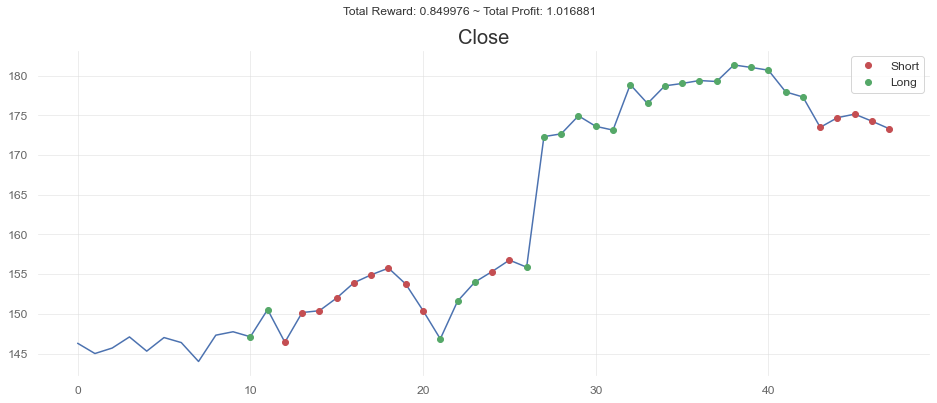

In [61]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓


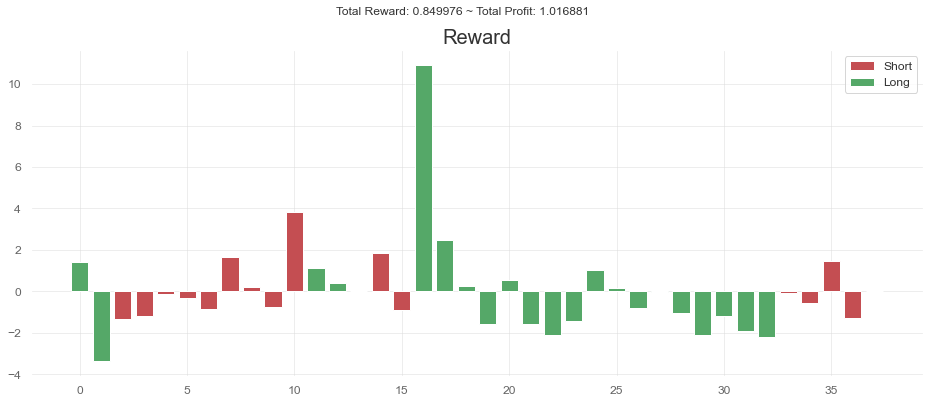

In [62]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


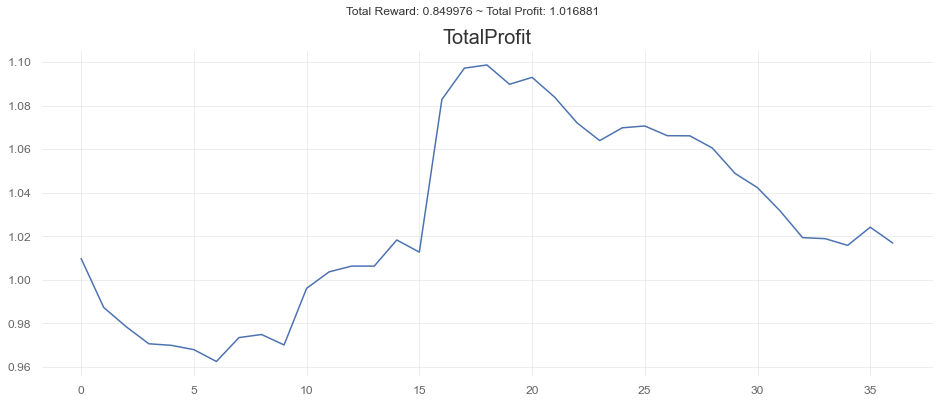

In [63]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [19]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)